In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
weight_bit_width = 8
act_bit_width = 8
kernel_size=(3,3)  
in_channel_0=1
out_channel_0=64 
in_channel_1=out_channel_0
out_channel_1=64
input_length = 7*7*out_channel_1
hidden_0 = 64   
output_length = 10 

In [3]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        
        self.input = qnn.QuantIdentity(
                         quant_type='int',
                         scaling_impl_type='const',
                         bit_width=act_bit_width,
                         min_val=-128.0,
                         max_val=127.0, 
                         return_quant_tensor=True
                     )
        
        self.conv0 = qnn.QuantConv2d( 
                         in_channels=in_channel_0,
                         out_channels=out_channel_0,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn0   = nn.BatchNorm2d(out_channel_0)
        self.act0  = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop0 = nn.Dropout(dropout)
        
        self.pool0 = nn.MaxPool2d(2)
        
        self.conv1 = qnn.QuantConv2d( 
                         in_channels=in_channel_1,
                         out_channels=out_channel_1,
                         kernel_size=kernel_size, 
                         stride=1, 
                         padding=1,
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn1   = nn.BatchNorm2d(out_channel_1)
        self.act1  = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop1 = nn.Dropout(dropout)
        
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2   = qnn.QuantLinear(
                         input_length, 
                         hidden_0, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )
        
        self.bn2   = nn.BatchNorm1d(hidden_0)
        self.act2  = qnn.QuantReLU(
                         bit_width=act_bit_width, 
                         return_quant_tensor=True
                     )
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(
                         hidden_0, 
                         output_length, 
                         weight_bit_width=weight_bit_width,
                         weight_quant_type=QuantType.INT,
                         bias=False
                     )

    def forward(self, x):
        out = self.input(x)
        out = self.pool0(self.drop0(self.act0(self.bn0(self.conv0(out)))))
        out = self.pool1(self.drop1(self.act1(self.bn1(self.conv1(out)))))
        out = out.reshape(out.shape[0], -1)
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    model = CNN(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
        
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  return F.conv2d(input, weight, bias, self.stride,
/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9659 | Val Loss: 0.0608, Acc: 0.9805


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9846 | Val Loss: 0.0415, Acc: 0.9879


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.0407, Acc: 0.9882


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.0416, Acc: 0.9881


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0427, Acc: 0.9876


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0417, Acc: 0.9888


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.0489, Acc: 0.9875


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9942 | Val Loss: 0.0450, Acc: 0.9872


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.0460, Acc: 0.9878


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9955 | Val Loss: 0.0483, Acc: 0.9888


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0530, Acc: 0.9890


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0547, Acc: 0.9878


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0497, Acc: 0.9890


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0512, Acc: 0.9890


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0427, Acc: 0.9906


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0610, Acc: 0.9880


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0631, Acc: 0.9873


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0535, Acc: 0.9889


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0658, Acc: 0.9883


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0544, Acc: 0.9906


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0510, Acc: 0.9899


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0587, Acc: 0.9891


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0588, Acc: 0.9892


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0731, Acc: 0.9883


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0660, Acc: 0.9886


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0724, Acc: 0.9885


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0609, Acc: 0.9903


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0602, Acc: 0.9896


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0725, Acc: 0.9905


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0748, Acc: 0.9882


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0684, Acc: 0.9900


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0742, Acc: 0.9905


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0741, Acc: 0.9892


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0895, Acc: 0.9868


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0740, Acc: 0.9895


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0772, Acc: 0.9896


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0756, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0756, Acc: 0.9897


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0787, Acc: 0.9891


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0914, Acc: 0.9878


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0823, Acc: 0.9890


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0873, Acc: 0.9892


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0738, Acc: 0.9894


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0792, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0859, Acc: 0.9879


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0964, Acc: 0.9885


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0839, Acc: 0.9906


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0815, Acc: 0.9902


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0917, Acc: 0.9891


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9985 | Val Loss: 0.0766, Acc: 0.9893


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0825, Acc: 0.9891


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0867, Acc: 0.9898


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0860, Acc: 0.9898


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0998, Acc: 0.9890


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0804, Acc: 0.9916


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0821, Acc: 0.9904


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0845, Acc: 0.9908


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0952, Acc: 0.9889


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0851, Acc: 0.9902


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0853, Acc: 0.9894


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0936, Acc: 0.9900


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1056, Acc: 0.9893


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0967, Acc: 0.9896


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.0820, Acc: 0.9915


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0791, Acc: 0.9916


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0910, Acc: 0.9903


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0994, Acc: 0.9883


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1042, Acc: 0.9891


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1094, Acc: 0.9888


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.0845, Acc: 0.9906


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0825, Acc: 0.9906


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0939, Acc: 0.9910


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.1122, Acc: 0.9878


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9991 | Val Loss: 0.0946, Acc: 0.9888


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0947, Acc: 0.9900


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0973, Acc: 0.9888


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.0879, Acc: 0.9898


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0911, Acc: 0.9905


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0905, Acc: 0.9909


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0870, Acc: 0.9902


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0935, Acc: 0.9911


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.0977, Acc: 0.9903


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0946, Acc: 0.9889


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9992 | Val Loss: 0.0972, Acc: 0.9897


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0900, Acc: 0.9910


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0985, Acc: 0.9907


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1026, Acc: 0.9903


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1133, Acc: 0.9899


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1178, Acc: 0.9904


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1121, Acc: 0.9908


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9995 | Val Loss: 0.1014, Acc: 0.9901


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1222, Acc: 0.9889


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1139, Acc: 0.9902


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.1050, Acc: 0.9913


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1109, Acc: 0.9888


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.1052, Acc: 0.9892


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1205, Acc: 0.9889


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1278, Acc: 0.9883


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1120, Acc: 0.9892


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9995 | Val Loss: 0.1132, Acc: 0.9887


Final Test Loss: 0.1041 Accuracy: 0.9898


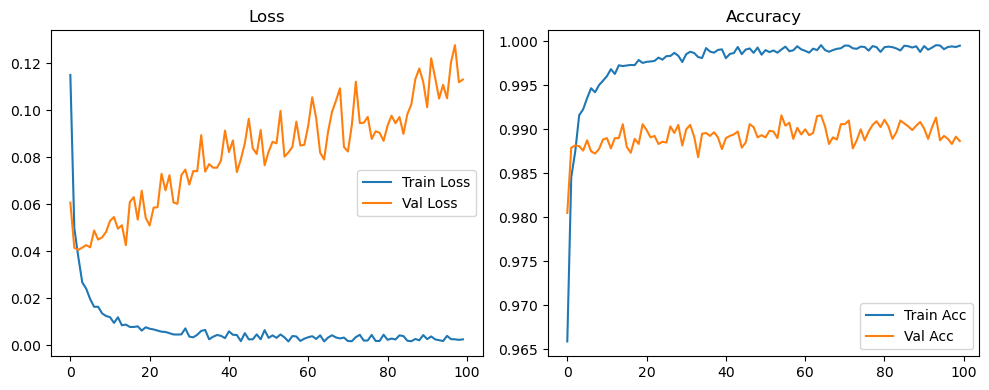

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1448, Acc: 0.9572 | Val Loss: 0.1160, Acc: 0.9625


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0708, Acc: 0.9786 | Val Loss: 0.0712, Acc: 0.9784


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9824 | Val Loss: 0.0743, Acc: 0.9774


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9843 | Val Loss: 0.0482, Acc: 0.9861


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.0530, Acc: 0.9822


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0496, Acc: 0.9864


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0477, Acc: 0.9864


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9884 | Val Loss: 0.0453, Acc: 0.9855


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.0506, Acc: 0.9848


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.0627, Acc: 0.9817


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0610, Acc: 0.9826


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9921 | Val Loss: 0.0480, Acc: 0.9852


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0693, Acc: 0.9805


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0481, Acc: 0.9874


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0443, Acc: 0.9868


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9931 | Val Loss: 0.0481, Acc: 0.9878


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0512, Acc: 0.9868


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0501, Acc: 0.9862


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0485, Acc: 0.9868


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0512, Acc: 0.9857


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.0444, Acc: 0.9862


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0405, Acc: 0.9884


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9943 | Val Loss: 0.0465, Acc: 0.9861


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0513, Acc: 0.9860


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0474, Acc: 0.9868


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0491, Acc: 0.9853


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.0481, Acc: 0.9869


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0591, Acc: 0.9840


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0585, Acc: 0.9849


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0471, Acc: 0.9864


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0475, Acc: 0.9865


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0630, Acc: 0.9837


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0405, Acc: 0.9895


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0544, Acc: 0.9852


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0457, Acc: 0.9871


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0446, Acc: 0.9883


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0509, Acc: 0.9863


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0546, Acc: 0.9858


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0469, Acc: 0.9862


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0476, Acc: 0.9886


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0489, Acc: 0.9872


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0510, Acc: 0.9859


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0592, Acc: 0.9858


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0557, Acc: 0.9862


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0573, Acc: 0.9851


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0497, Acc: 0.9881


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0699, Acc: 0.9804


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0539, Acc: 0.9845


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0477, Acc: 0.9882


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0539, Acc: 0.9868


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0504, Acc: 0.9862


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0536, Acc: 0.9861


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0551, Acc: 0.9858


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0453, Acc: 0.9866


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0601, Acc: 0.9829


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0505, Acc: 0.9872


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0523, Acc: 0.9850


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9973 | Val Loss: 0.0435, Acc: 0.9886


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.0481, Acc: 0.9862


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0543, Acc: 0.9855


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0540, Acc: 0.9852


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.0641, Acc: 0.9837


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0521, Acc: 0.9875


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0487, Acc: 0.9872


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0649, Acc: 0.9808


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0603, Acc: 0.9847


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0513, Acc: 0.9852


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0569, Acc: 0.9838


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0464, Acc: 0.9889


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0542, Acc: 0.9852


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0460, Acc: 0.9878


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0555, Acc: 0.9826


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0506, Acc: 0.9871


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9974 | Val Loss: 0.0573, Acc: 0.9842


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0541, Acc: 0.9854


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0471, Acc: 0.9862


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0621, Acc: 0.9832


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0545, Acc: 0.9852


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0598, Acc: 0.9841


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0529, Acc: 0.9847


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.0519, Acc: 0.9852


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0595, Acc: 0.9838


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0505, Acc: 0.9855


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0563, Acc: 0.9847


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0427, Acc: 0.9895


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0558, Acc: 0.9838


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0506, Acc: 0.9849


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0524, Acc: 0.9854


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0579, Acc: 0.9856


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.0446, Acc: 0.9887


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0583, Acc: 0.9832


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0474, Acc: 0.9870


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0456, Acc: 0.9872


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0471, Acc: 0.9863


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0550, Acc: 0.9848


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0534, Acc: 0.9859


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0579, Acc: 0.9828


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0653, Acc: 0.9822


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0625, Acc: 0.9809


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0503, Acc: 0.9864


Final Test Loss: 0.0507 Accuracy: 0.9848


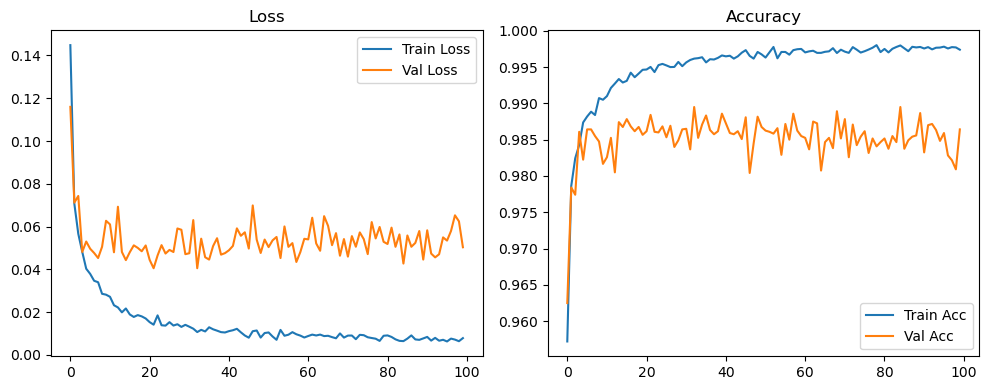

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2423, Acc: 0.9280 | Val Loss: 0.5624, Acc: 0.8053


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1322, Acc: 0.9609 | Val Loss: 0.2015, Acc: 0.9452


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9658 | Val Loss: 0.3408, Acc: 0.8897


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1065, Acc: 0.9682 | Val Loss: 0.2106, Acc: 0.9395


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9710 | Val Loss: 0.2486, Acc: 0.9169


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0917, Acc: 0.9730 | Val Loss: 0.2250, Acc: 0.9285


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9742 | Val Loss: 0.1255, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9746 | Val Loss: 0.1820, Acc: 0.9460


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9763 | Val Loss: 0.1960, Acc: 0.9423


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9765 | Val Loss: 0.1702, Acc: 0.9439


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0748, Acc: 0.9777 | Val Loss: 0.1305, Acc: 0.9610


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0751, Acc: 0.9771 | Val Loss: 0.1112, Acc: 0.9727


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9788 | Val Loss: 0.1632, Acc: 0.9563


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0699, Acc: 0.9788 | Val Loss: 0.1125, Acc: 0.9752


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0672, Acc: 0.9801 | Val Loss: 0.1396, Acc: 0.9599


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9791 | Val Loss: 0.1720, Acc: 0.9488


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0664, Acc: 0.9800 | Val Loss: 0.1251, Acc: 0.9665


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9810 | Val Loss: 0.1770, Acc: 0.9539


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9811 | Val Loss: 0.1247, Acc: 0.9713


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9815 | Val Loss: 0.1694, Acc: 0.9591


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0613, Acc: 0.9819 | Val Loss: 0.2153, Acc: 0.9399


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9823 | Val Loss: 0.1522, Acc: 0.9607


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9822 | Val Loss: 0.1378, Acc: 0.9722


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0585, Acc: 0.9822 | Val Loss: 0.1556, Acc: 0.9635


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9828 | Val Loss: 0.1627, Acc: 0.9578


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0569, Acc: 0.9829 | Val Loss: 0.1388, Acc: 0.9712


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9834 | Val Loss: 0.1545, Acc: 0.9712


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9834 | Val Loss: 0.1592, Acc: 0.9627


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9832 | Val Loss: 0.1654, Acc: 0.9613


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9829 | Val Loss: 0.2063, Acc: 0.9479


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9841 | Val Loss: 0.1509, Acc: 0.9770


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9841 | Val Loss: 0.2335, Acc: 0.9439


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9846 | Val Loss: 0.1621, Acc: 0.9706


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9840 | Val Loss: 0.2318, Acc: 0.9523


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9847 | Val Loss: 0.2169, Acc: 0.9520


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9849 | Val Loss: 0.1738, Acc: 0.9720


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9851 | Val Loss: 0.1872, Acc: 0.9662


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9847 | Val Loss: 0.1649, Acc: 0.9597


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9850 | Val Loss: 0.2296, Acc: 0.9475


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9852 | Val Loss: 0.2523, Acc: 0.9378


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9854 | Val Loss: 0.1703, Acc: 0.9655


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9854 | Val Loss: 0.1860, Acc: 0.9732


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9852 | Val Loss: 0.2406, Acc: 0.9362


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9867 | Val Loss: 0.2869, Acc: 0.9021


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.2223, Acc: 0.9543


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9859 | Val Loss: 0.2417, Acc: 0.9329


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9855 | Val Loss: 0.3127, Acc: 0.9411


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9857 | Val Loss: 0.3062, Acc: 0.9480


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9862 | Val Loss: 0.2967, Acc: 0.9508


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9860 | Val Loss: 0.2530, Acc: 0.9511


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9856 | Val Loss: 0.2242, Acc: 0.9688


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9860 | Val Loss: 0.1901, Acc: 0.9725


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9863 | Val Loss: 0.2564, Acc: 0.9480


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9869 | Val Loss: 0.2646, Acc: 0.9633


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9865 | Val Loss: 0.3882, Acc: 0.9045


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.2570, Acc: 0.9535


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9859 | Val Loss: 0.3204, Acc: 0.9394


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 0.2005, Acc: 0.9622


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9868 | Val Loss: 0.2705, Acc: 0.9356


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.2677, Acc: 0.9476


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9865 | Val Loss: 0.3354, Acc: 0.9320


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9863 | Val Loss: 0.2098, Acc: 0.9614


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9862 | Val Loss: 0.3964, Acc: 0.9038


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.4224, Acc: 0.9347


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9879 | Val Loss: 0.3577, Acc: 0.9192


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.2554, Acc: 0.9589


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9873 | Val Loss: 0.4157, Acc: 0.9221


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9865 | Val Loss: 0.4493, Acc: 0.9287


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9875 | Val Loss: 0.3697, Acc: 0.9395


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9870 | Val Loss: 0.4376, Acc: 0.9448


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9877 | Val Loss: 0.3680, Acc: 0.9563


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9876 | Val Loss: 0.3919, Acc: 0.9178


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9877 | Val Loss: 0.3388, Acc: 0.9390


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9864 | Val Loss: 0.4952, Acc: 0.8964


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9878 | Val Loss: 0.3891, Acc: 0.9463


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9883 | Val Loss: 0.3418, Acc: 0.9428


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9874 | Val Loss: 0.3354, Acc: 0.9292


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9872 | Val Loss: 0.4124, Acc: 0.9616


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9885 | Val Loss: 0.3481, Acc: 0.9464


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9868 | Val Loss: 0.4817, Acc: 0.9259


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.5069, Acc: 0.9437


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9880 | Val Loss: 0.4745, Acc: 0.9095


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9876 | Val Loss: 0.4593, Acc: 0.9357


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.3083, Acc: 0.9643


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9882 | Val Loss: 0.4430, Acc: 0.9129


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9882 | Val Loss: 0.4345, Acc: 0.9370


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.4664, Acc: 0.9346


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 0.5541, Acc: 0.8776


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.5679, Acc: 0.9223


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9882 | Val Loss: 0.6434, Acc: 0.8085


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9886 | Val Loss: 0.6092, Acc: 0.8477


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9873 | Val Loss: 0.6332, Acc: 0.8559


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9886 | Val Loss: 0.6108, Acc: 0.8981


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9895 | Val Loss: 0.5645, Acc: 0.9027


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.5284, Acc: 0.9203


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9881 | Val Loss: 0.7192, Acc: 0.8738


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 0.7626, Acc: 0.8745


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.6897, Acc: 0.8403


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9885 | Val Loss: 0.6972, Acc: 0.8309


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9886 | Val Loss: 0.5971, Acc: 0.8833


Final Test Loss: 0.5993 Accuracy: 0.8860


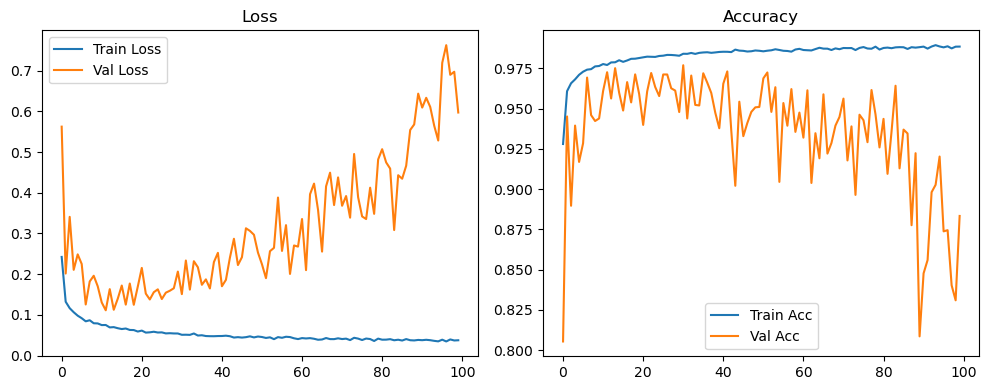

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9660 | Val Loss: 0.0532, Acc: 0.9842


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9847 | Val Loss: 0.0441, Acc: 0.9873


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9878 | Val Loss: 0.0415, Acc: 0.9872


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.0458, Acc: 0.9877


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.0424, Acc: 0.9876


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0497, Acc: 0.9855


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0417, Acc: 0.9889


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0648, Acc: 0.9823


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.0510, Acc: 0.9879


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0466, Acc: 0.9881


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0444, Acc: 0.9897


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0436, Acc: 0.9892


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0528, Acc: 0.9877


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0465, Acc: 0.9898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0475, Acc: 0.9904


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0521, Acc: 0.9893


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0550, Acc: 0.9897


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0575, Acc: 0.9884


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0481, Acc: 0.9901


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0480, Acc: 0.9899


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0503, Acc: 0.9902


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0672, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0487, Acc: 0.9902


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0761, Acc: 0.9882


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0607, Acc: 0.9882


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0523, Acc: 0.9905


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0776, Acc: 0.9866


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0562, Acc: 0.9901


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0726, Acc: 0.9892


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0615, Acc: 0.9906


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0603, Acc: 0.9911


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.0692, Acc: 0.9891


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0596, Acc: 0.9902


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0613, Acc: 0.9899


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0602, Acc: 0.9906


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0647, Acc: 0.9893


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.0860, Acc: 0.9885


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0665, Acc: 0.9904


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0610, Acc: 0.9916


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.0815, Acc: 0.9886


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.0764, Acc: 0.9887


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0744, Acc: 0.9902


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0914, Acc: 0.9874


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0754, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0953, Acc: 0.9878


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0757, Acc: 0.9902


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0918, Acc: 0.9892


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0720, Acc: 0.9892


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0650, Acc: 0.9904


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0585, Acc: 0.9906


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0536, Acc: 0.9922


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0516, Acc: 0.9928


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0558, Acc: 0.9918


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0560, Acc: 0.9915


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0603, Acc: 0.9915


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0615, Acc: 0.9918


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0589, Acc: 0.9921


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0718, Acc: 0.9910


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0659, Acc: 0.9913


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9912


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0728, Acc: 0.9913


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0791, Acc: 0.9913


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0746, Acc: 0.9911


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0764, Acc: 0.9913


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0768, Acc: 0.9916


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0710, Acc: 0.9929


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0726, Acc: 0.9921


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0938, Acc: 0.9896


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0769, Acc: 0.9920


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0740, Acc: 0.9912


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0762, Acc: 0.9910


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0730, Acc: 0.9921


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0873, Acc: 0.9908


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0779, Acc: 0.9922


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0802, Acc: 0.9917


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0743, Acc: 0.9915


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0860, Acc: 0.9913


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0805, Acc: 0.9910


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0878, Acc: 0.9918


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9998 | Val Loss: 0.0749, Acc: 0.9910


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0734, Acc: 0.9919


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0726, Acc: 0.9923


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0744, Acc: 0.9918


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0725, Acc: 0.9922


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0751, Acc: 0.9919


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0736, Acc: 0.9921


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0747, Acc: 0.9918


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0768, Acc: 0.9918


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0774, Acc: 0.9917


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0740, Acc: 0.9919


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0775, Acc: 0.9915


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0764, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0800, Acc: 0.9922


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0769, Acc: 0.9920


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0782, Acc: 0.9917


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0770, Acc: 0.9919


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0802, Acc: 0.9922


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0771, Acc: 0.9925


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0794, Acc: 0.9921


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0779, Acc: 0.9918


Final Test Loss: 0.0805 Accuracy: 0.9910


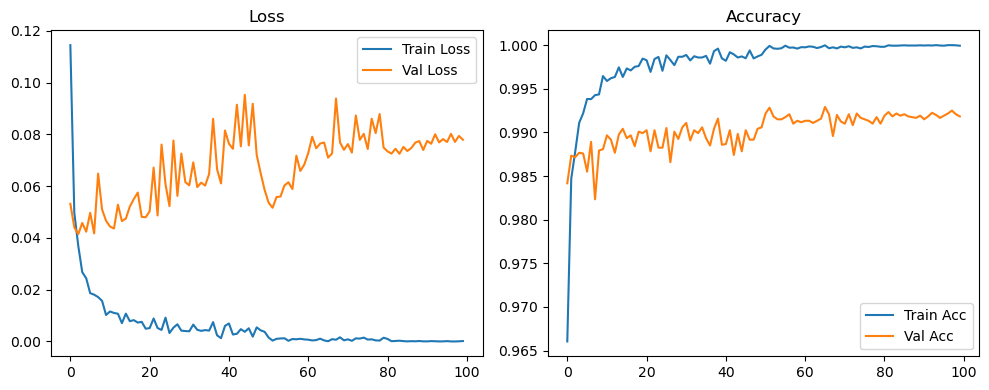

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1451, Acc: 0.9561 | Val Loss: 0.1329, Acc: 0.9578


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9782 | Val Loss: 0.0614, Acc: 0.9813


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0562, Acc: 0.9827


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9842 | Val Loss: 0.0626, Acc: 0.9812


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9865 | Val Loss: 0.0620, Acc: 0.9802


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9874 | Val Loss: 0.0704, Acc: 0.9791


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.0543, Acc: 0.9848


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9885 | Val Loss: 0.0444, Acc: 0.9870


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0533, Acc: 0.9842


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.0483, Acc: 0.9847


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9919 | Val Loss: 0.0662, Acc: 0.9828


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0461, Acc: 0.9869


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0636, Acc: 0.9836


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.0404, Acc: 0.9889


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.0461, Acc: 0.9859


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0450, Acc: 0.9875


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0540, Acc: 0.9845


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0467, Acc: 0.9864


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0449, Acc: 0.9874


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0352, Acc: 0.9897


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0536, Acc: 0.9836


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0588, Acc: 0.9854


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0477, Acc: 0.9880


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0446, Acc: 0.9882


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0519, Acc: 0.9862


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0448, Acc: 0.9869


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0477, Acc: 0.9871


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0516, Acc: 0.9861


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0424, Acc: 0.9893


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0674, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0523, Acc: 0.9861


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0517, Acc: 0.9871


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0465, Acc: 0.9883


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0542, Acc: 0.9869


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0527, Acc: 0.9877


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0481, Acc: 0.9865


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0507, Acc: 0.9875


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0490, Acc: 0.9878


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0477, Acc: 0.9866


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0454, Acc: 0.9886


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0458, Acc: 0.9875


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0436, Acc: 0.9882


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0565, Acc: 0.9852


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0731, Acc: 0.9792


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0683, Acc: 0.9807


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0418, Acc: 0.9890


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0499, Acc: 0.9868


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0467, Acc: 0.9874


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0538, Acc: 0.9852


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0532, Acc: 0.9870


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0463, Acc: 0.9862


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0489, Acc: 0.9868


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0502, Acc: 0.9862


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0510, Acc: 0.9867


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0507, Acc: 0.9864


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0462, Acc: 0.9890


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0543, Acc: 0.9874


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0442, Acc: 0.9888


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0488, Acc: 0.9860


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0476, Acc: 0.9875


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0421, Acc: 0.9892


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0481, Acc: 0.9878


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9983 | Val Loss: 0.0433, Acc: 0.9882


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0451, Acc: 0.9882


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0417, Acc: 0.9880


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0463, Acc: 0.9874


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0429, Acc: 0.9888


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0472, Acc: 0.9882


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0484, Acc: 0.9874


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0457, Acc: 0.9878


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0485, Acc: 0.9890


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0520, Acc: 0.9867


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0499, Acc: 0.9883


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0473, Acc: 0.9885


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0486, Acc: 0.9882


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0407, Acc: 0.9896


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0445, Acc: 0.9890


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0437, Acc: 0.9877


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0497, Acc: 0.9883


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0463, Acc: 0.9887


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0472, Acc: 0.9888


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0426, Acc: 0.9892


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0453, Acc: 0.9891


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0480, Acc: 0.9882


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0475, Acc: 0.9882


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9892


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0411, Acc: 0.9906


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0446, Acc: 0.9893


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0444, Acc: 0.9903


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0482, Acc: 0.9882


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0426, Acc: 0.9903


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0433, Acc: 0.9898


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0443, Acc: 0.9894


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0417, Acc: 0.9901


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0455, Acc: 0.9891


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0492, Acc: 0.9868


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9993 | Val Loss: 0.0496, Acc: 0.9880


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0459, Acc: 0.9888


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0428, Acc: 0.9902


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9903


Final Test Loss: 0.0352 Accuracy: 0.9905


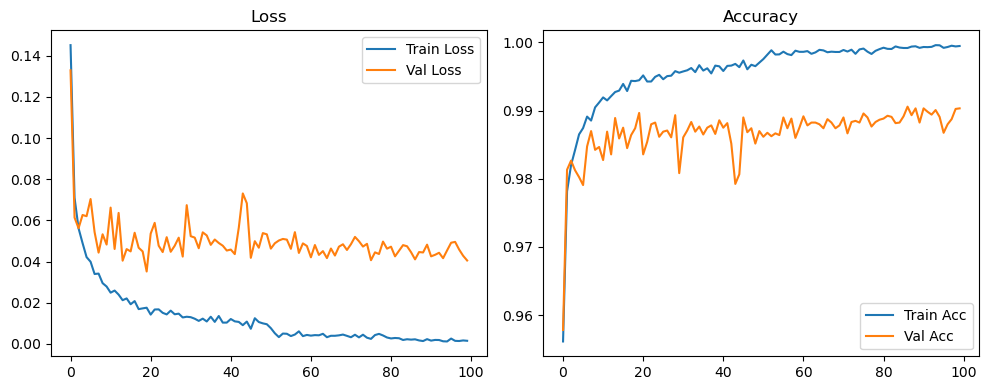

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2412, Acc: 0.9287 | Val Loss: 0.4384, Acc: 0.8529


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9600 | Val Loss: 0.2942, Acc: 0.9096


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9649 | Val Loss: 0.2442, Acc: 0.9325


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1046, Acc: 0.9692 | Val Loss: 0.1828, Acc: 0.9497


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0957, Acc: 0.9720 | Val Loss: 0.1500, Acc: 0.9577


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0924, Acc: 0.9728 | Val Loss: 0.1689, Acc: 0.9513


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0852, Acc: 0.9736 | Val Loss: 0.1328, Acc: 0.9698


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0868, Acc: 0.9748 | Val Loss: 0.1639, Acc: 0.9617


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0773, Acc: 0.9767 | Val Loss: 0.2778, Acc: 0.9057


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9762 | Val Loss: 0.1725, Acc: 0.9440


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9771 | Val Loss: 0.1348, Acc: 0.9611


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9779 | Val Loss: 0.1503, Acc: 0.9561


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9788 | Val Loss: 0.1630, Acc: 0.9539


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9801 | Val Loss: 0.1428, Acc: 0.9565


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9797 | Val Loss: 0.1208, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9803 | Val Loss: 0.1422, Acc: 0.9546


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9802 | Val Loss: 0.1376, Acc: 0.9583


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0636, Acc: 0.9806 | Val Loss: 0.1352, Acc: 0.9635


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0611, Acc: 0.9815 | Val Loss: 0.0986, Acc: 0.9757


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9817 | Val Loss: 0.1456, Acc: 0.9654


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9816 | Val Loss: 0.1802, Acc: 0.9428


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9826 | Val Loss: 0.1189, Acc: 0.9684


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0574, Acc: 0.9820 | Val Loss: 0.1320, Acc: 0.9668


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9822 | Val Loss: 0.1654, Acc: 0.9518


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9824 | Val Loss: 0.1342, Acc: 0.9728


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9832 | Val Loss: 0.1381, Acc: 0.9673


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9838 | Val Loss: 0.1203, Acc: 0.9729


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9831 | Val Loss: 0.1830, Acc: 0.9520


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9835 | Val Loss: 0.2108, Acc: 0.9533


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9836 | Val Loss: 0.1972, Acc: 0.9477


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9841 | Val Loss: 0.1691, Acc: 0.9611


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9843 | Val Loss: 0.2245, Acc: 0.9567


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9839 | Val Loss: 0.1825, Acc: 0.9505


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9844 | Val Loss: 0.2081, Acc: 0.9630


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9840 | Val Loss: 0.1873, Acc: 0.9719


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9851 | Val Loss: 0.1923, Acc: 0.9597


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9848 | Val Loss: 0.2148, Acc: 0.9443


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9851 | Val Loss: 0.2467, Acc: 0.9473


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9844 | Val Loss: 0.2434, Acc: 0.9604


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9851 | Val Loss: 0.3030, Acc: 0.9433


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9846 | Val Loss: 0.2313, Acc: 0.9512


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9855 | Val Loss: 0.2128, Acc: 0.9620


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9852 | Val Loss: 0.2040, Acc: 0.9622


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9861 | Val Loss: 0.2410, Acc: 0.9487


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9856 | Val Loss: 0.2769, Acc: 0.9459


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9853 | Val Loss: 0.2788, Acc: 0.9402


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9857 | Val Loss: 0.2973, Acc: 0.9321


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9851 | Val Loss: 0.3122, Acc: 0.9529


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9860 | Val Loss: 0.4557, Acc: 0.9328


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9854 | Val Loss: 0.3820, Acc: 0.9321


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 0.2968, Acc: 0.9608


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9888 | Val Loss: 0.3211, Acc: 0.9511


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9889 | Val Loss: 0.3774, Acc: 0.9389


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.3631, Acc: 0.9514


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.3048, Acc: 0.9425


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9900 | Val Loss: 0.3146, Acc: 0.9609


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9889 | Val Loss: 0.3272, Acc: 0.9495


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.2920, Acc: 0.9592


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.3109, Acc: 0.9370


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.2891, Acc: 0.9557


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.2800, Acc: 0.9542


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.2645, Acc: 0.9621


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.2890, Acc: 0.9577


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.2718, Acc: 0.9587


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.3954, Acc: 0.9380


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.2960, Acc: 0.9580


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.3037, Acc: 0.9542


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9898 | Val Loss: 0.4427, Acc: 0.9409


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.3763, Acc: 0.9547


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.3981, Acc: 0.9337


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.3865, Acc: 0.9461


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.3693, Acc: 0.9320


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.3621, Acc: 0.9436


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9901 | Val Loss: 0.4047, Acc: 0.9457


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.4164, Acc: 0.9346


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.4163, Acc: 0.9363


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.4374, Acc: 0.9403


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9906 | Val Loss: 0.5745, Acc: 0.9152


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.4627, Acc: 0.9393


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9902 | Val Loss: 0.5700, Acc: 0.8978


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.5189, Acc: 0.9354


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9920 | Val Loss: 0.5303, Acc: 0.9381


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.4870, Acc: 0.9361


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.5296, Acc: 0.9380


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9923 | Val Loss: 0.5452, Acc: 0.9365


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.5588, Acc: 0.9241


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9924 | Val Loss: 0.5725, Acc: 0.9337


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.5273, Acc: 0.9272


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.5682, Acc: 0.9186


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.5872, Acc: 0.9015


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.6050, Acc: 0.8978


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.5807, Acc: 0.9247


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.5967, Acc: 0.9143


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9927 | Val Loss: 0.6650, Acc: 0.9083


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9932 | Val Loss: 0.5559, Acc: 0.9067


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.5274, Acc: 0.9096


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.5040, Acc: 0.9303


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9919 | Val Loss: 0.5187, Acc: 0.9057


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.5651, Acc: 0.9285


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.5658, Acc: 0.9153


Final Test Loss: 0.5698 Accuracy: 0.9106


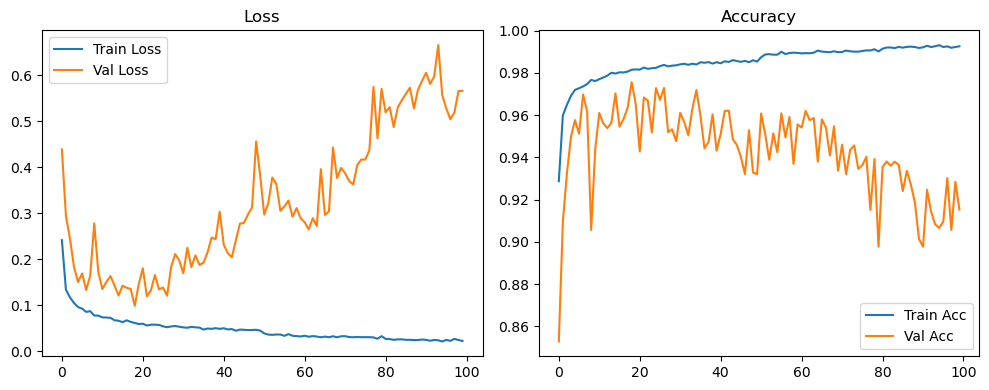

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9653 | Val Loss: 0.0536, Acc: 0.9838


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9850 | Val Loss: 0.0431, Acc: 0.9882


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9880 | Val Loss: 0.0508, Acc: 0.9851


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0416, Acc: 0.9885


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0480, Acc: 0.9857


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.0380, Acc: 0.9897


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9945 | Val Loss: 0.0471, Acc: 0.9882


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0415, Acc: 0.9899


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0442, Acc: 0.9897


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0484, Acc: 0.9882


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0499, Acc: 0.9890


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0542, Acc: 0.9878


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0455, Acc: 0.9902


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0493, Acc: 0.9891


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0486, Acc: 0.9902


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0489, Acc: 0.9900


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0609, Acc: 0.9879


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0601, Acc: 0.9888


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0522, Acc: 0.9903


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0595, Acc: 0.9896


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0656, Acc: 0.9890


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0635, Acc: 0.9885


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0687, Acc: 0.9880


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0604, Acc: 0.9906


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0690, Acc: 0.9879


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0566, Acc: 0.9918


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0604, Acc: 0.9908


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.0616, Acc: 0.9898


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0612, Acc: 0.9898


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0704, Acc: 0.9891


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0651, Acc: 0.9901


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0649, Acc: 0.9897


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0627, Acc: 0.9902


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0605, Acc: 0.9896


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0805, Acc: 0.9868


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0688, Acc: 0.9905


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0647, Acc: 0.9903


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0765, Acc: 0.9890


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0737, Acc: 0.9897


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0728, Acc: 0.9903


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9988 | Val Loss: 0.0703, Acc: 0.9902


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0903, Acc: 0.9883


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0680, Acc: 0.9895


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.0685, Acc: 0.9898


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0800, Acc: 0.9905


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0722, Acc: 0.9900


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.0748, Acc: 0.9899


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0923, Acc: 0.9887


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0676, Acc: 0.9901


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.0608, Acc: 0.9903


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0539, Acc: 0.9912


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0575, Acc: 0.9913


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0570, Acc: 0.9913


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0537, Acc: 0.9911


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0567, Acc: 0.9913


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0593, Acc: 0.9916


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0652, Acc: 0.9911


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0687, Acc: 0.9912


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0638, Acc: 0.9919


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0730, Acc: 0.9915


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0633, Acc: 0.9921


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0646, Acc: 0.9918


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0623, Acc: 0.9924


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0677, Acc: 0.9922


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0732, Acc: 0.9915


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0786, Acc: 0.9909


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0689, Acc: 0.9920


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0767, Acc: 0.9911


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0854, Acc: 0.9907


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0758, Acc: 0.9917


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0732, Acc: 0.9916


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0731, Acc: 0.9920


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0763, Acc: 0.9909


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0811, Acc: 0.9903


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0840, Acc: 0.9912


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0745, Acc: 0.9918


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0836, Acc: 0.9913


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0769, Acc: 0.9914


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0748, Acc: 0.9921


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0768, Acc: 0.9908


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0752, Acc: 0.9915


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0745, Acc: 0.9914


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0740, Acc: 0.9915


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0731, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0747, Acc: 0.9914


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0705, Acc: 0.9920


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0709, Acc: 0.9924


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0736, Acc: 0.9923


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0719, Acc: 0.9924


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0723, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0762, Acc: 0.9922


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0736, Acc: 0.9920


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0750, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0734, Acc: 0.9924


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0742, Acc: 0.9923


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0756, Acc: 0.9927


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0790, Acc: 0.9919


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0765, Acc: 0.9926


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0767, Acc: 0.9920


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0751, Acc: 0.9924


Final Test Loss: 0.0673 Accuracy: 0.9911


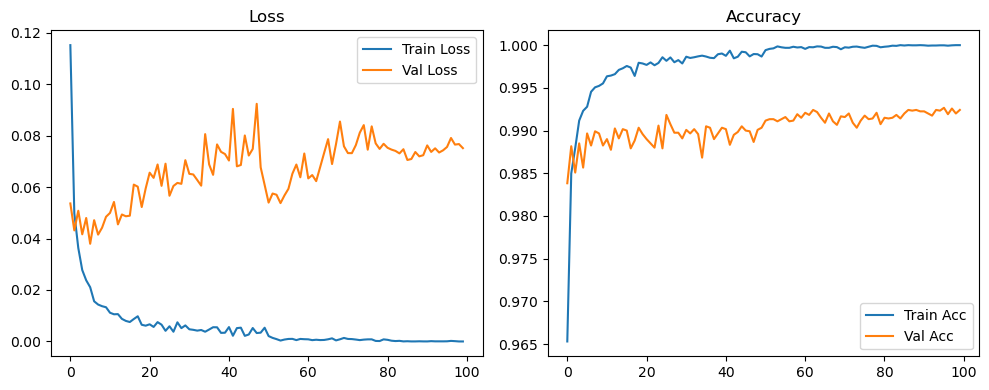

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1449, Acc: 0.9570 | Val Loss: 0.1118, Acc: 0.9638


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9788 | Val Loss: 0.0638, Acc: 0.9809


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9827 | Val Loss: 0.0726, Acc: 0.9775


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9851 | Val Loss: 0.0611, Acc: 0.9816


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 0.0477, Acc: 0.9863


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.0482, Acc: 0.9847


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0510, Acc: 0.9849


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0432, Acc: 0.9870


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0493, Acc: 0.9858


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0482, Acc: 0.9869


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0515, Acc: 0.9860


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0451, Acc: 0.9876


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0560, Acc: 0.9840


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9937 | Val Loss: 0.0495, Acc: 0.9867


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9932 | Val Loss: 0.0460, Acc: 0.9868


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0588, Acc: 0.9841


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0421, Acc: 0.9879


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0451, Acc: 0.9882


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0498, Acc: 0.9854


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9948 | Val Loss: 0.0493, Acc: 0.9856


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0444, Acc: 0.9888


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0501, Acc: 0.9862


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0391, Acc: 0.9894


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0513, Acc: 0.9852


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0478, Acc: 0.9864


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0397, Acc: 0.9891


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0431, Acc: 0.9901


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9958 | Val Loss: 0.0558, Acc: 0.9863


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0418, Acc: 0.9884


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0465, Acc: 0.9882


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0493, Acc: 0.9874


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0522, Acc: 0.9868


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0381, Acc: 0.9895


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0494, Acc: 0.9876


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0383, Acc: 0.9917


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0504, Acc: 0.9875


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0460, Acc: 0.9888


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0467, Acc: 0.9882


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0639, Acc: 0.9852


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0507, Acc: 0.9861


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0461, Acc: 0.9887


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0538, Acc: 0.9861


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0800, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.0559, Acc: 0.9848


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0457, Acc: 0.9881


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0432, Acc: 0.9882


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0560, Acc: 0.9858


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0479, Acc: 0.9880


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0456, Acc: 0.9878


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0551, Acc: 0.9856


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0391, Acc: 0.9893


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0527, Acc: 0.9848


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0431, Acc: 0.9884


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0458, Acc: 0.9881


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0474, Acc: 0.9878


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0379, Acc: 0.9915


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0430, Acc: 0.9896


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0371, Acc: 0.9908


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0388, Acc: 0.9902


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0415, Acc: 0.9902


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0411, Acc: 0.9899


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0403, Acc: 0.9904


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0389, Acc: 0.9902


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0423, Acc: 0.9891


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0456, Acc: 0.9888


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0407, Acc: 0.9887


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0362, Acc: 0.9908


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0434, Acc: 0.9900


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0458, Acc: 0.9886


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0462, Acc: 0.9874


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0466, Acc: 0.9875


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0558, Acc: 0.9850


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0430, Acc: 0.9895


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0526, Acc: 0.9869


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0461, Acc: 0.9882


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0480, Acc: 0.9880


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0511, Acc: 0.9883


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0415, Acc: 0.9887


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0497, Acc: 0.9870


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0534, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0487, Acc: 0.9861


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0426, Acc: 0.9886


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0460, Acc: 0.9874


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0456, Acc: 0.9882


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0479, Acc: 0.9872


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0428, Acc: 0.9888


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0425, Acc: 0.9892


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0423, Acc: 0.9891


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0429, Acc: 0.9895


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0432, Acc: 0.9892


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0456, Acc: 0.9883


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0421, Acc: 0.9894


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0423, Acc: 0.9889


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0413, Acc: 0.9895


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0436, Acc: 0.9897


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0447, Acc: 0.9891


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0432, Acc: 0.9896


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0420, Acc: 0.9892


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0407, Acc: 0.9903


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0371, Acc: 0.9905


Final Test Loss: 0.0351 Accuracy: 0.9913


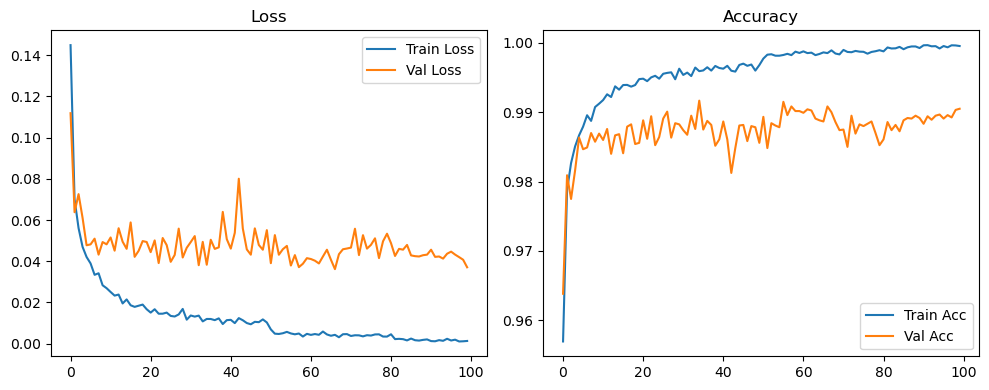

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2403, Acc: 0.9287 | Val Loss: 0.5216, Acc: 0.8147


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1338, Acc: 0.9609 | Val Loss: 0.3064, Acc: 0.9002


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1156, Acc: 0.9653 | Val Loss: 0.2609, Acc: 0.9213


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1047, Acc: 0.9684 | Val Loss: 0.1765, Acc: 0.9484


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0954, Acc: 0.9719 | Val Loss: 0.1526, Acc: 0.9588


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0914, Acc: 0.9725 | Val Loss: 0.2243, Acc: 0.9242


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0844, Acc: 0.9751 | Val Loss: 0.1081, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0861, Acc: 0.9743 | Val Loss: 0.1552, Acc: 0.9541


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9770 | Val Loss: 0.1497, Acc: 0.9574


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0781, Acc: 0.9764 | Val Loss: 0.1275, Acc: 0.9606


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0735, Acc: 0.9778 | Val Loss: 0.1166, Acc: 0.9663


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0719, Acc: 0.9782 | Val Loss: 0.1150, Acc: 0.9727


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9779 | Val Loss: 0.1401, Acc: 0.9621


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9788 | Val Loss: 0.1268, Acc: 0.9627


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9795 | Val Loss: 0.1395, Acc: 0.9599


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9812 | Val Loss: 0.1352, Acc: 0.9640


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0655, Acc: 0.9802 | Val Loss: 0.1227, Acc: 0.9646


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0635, Acc: 0.9800 | Val Loss: 0.1392, Acc: 0.9623


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0622, Acc: 0.9810 | Val Loss: 0.0968, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9819 | Val Loss: 0.1416, Acc: 0.9573


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9817 | Val Loss: 0.1588, Acc: 0.9493


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9826 | Val Loss: 0.1288, Acc: 0.9712


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9815 | Val Loss: 0.0918, Acc: 0.9747


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9828 | Val Loss: 0.1529, Acc: 0.9527


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9816 | Val Loss: 0.1503, Acc: 0.9577


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9826 | Val Loss: 0.1202, Acc: 0.9744


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9836 | Val Loss: 0.1484, Acc: 0.9591


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9829 | Val Loss: 0.1725, Acc: 0.9580


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0542, Acc: 0.9832 | Val Loss: 0.1705, Acc: 0.9666


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.1573, Acc: 0.9628


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0532, Acc: 0.9837 | Val Loss: 0.1992, Acc: 0.9468


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9842 | Val Loss: 0.1791, Acc: 0.9533


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9846 | Val Loss: 0.1645, Acc: 0.9593


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9845 | Val Loss: 0.1390, Acc: 0.9732


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9845 | Val Loss: 0.2192, Acc: 0.9364


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9845 | Val Loss: 0.1990, Acc: 0.9647


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9845 | Val Loss: 0.1619, Acc: 0.9627


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.1778, Acc: 0.9608


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9853 | Val Loss: 0.2569, Acc: 0.9520


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9859 | Val Loss: 0.2252, Acc: 0.9581


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9852 | Val Loss: 0.2120, Acc: 0.9591


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9855 | Val Loss: 0.1478, Acc: 0.9704


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9853 | Val Loss: 0.2190, Acc: 0.9322


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9854 | Val Loss: 0.2435, Acc: 0.9227


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9859 | Val Loss: 0.2599, Acc: 0.9423


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.1729, Acc: 0.9697


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9863 | Val Loss: 0.2769, Acc: 0.9163


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9863 | Val Loss: 0.1908, Acc: 0.9607


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9858 | Val Loss: 0.2385, Acc: 0.9386


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9863 | Val Loss: 0.2902, Acc: 0.9643


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9879 | Val Loss: 0.2763, Acc: 0.9587


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.2620, Acc: 0.9595


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.2362, Acc: 0.9653


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.1904, Acc: 0.9793


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.1913, Acc: 0.9686


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.2116, Acc: 0.9715


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9887 | Val Loss: 0.2514, Acc: 0.9534


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.2306, Acc: 0.9630


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.2486, Acc: 0.9483


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.2114, Acc: 0.9653


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.1833, Acc: 0.9719


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9890 | Val Loss: 0.2197, Acc: 0.9688


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.2315, Acc: 0.9607


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.2019, Acc: 0.9708


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.1872, Acc: 0.9643


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.2145, Acc: 0.9583


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9893 | Val Loss: 0.2681, Acc: 0.9611


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.2298, Acc: 0.9641


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.2961, Acc: 0.9590


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9898 | Val Loss: 0.3332, Acc: 0.9533


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 0.2699, Acc: 0.9603


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.2869, Acc: 0.9508


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.2406, Acc: 0.9576


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.3043, Acc: 0.9636


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9905 | Val Loss: 0.3416, Acc: 0.9548


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9908 | Val Loss: 0.2800, Acc: 0.9554


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.2363, Acc: 0.9677


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.2829, Acc: 0.9546


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9918 | Val Loss: 0.2533, Acc: 0.9602


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9905 | Val Loss: 0.3078, Acc: 0.9581


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9915 | Val Loss: 0.3240, Acc: 0.9546


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.3159, Acc: 0.9599


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.2996, Acc: 0.9637


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.2963, Acc: 0.9626


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.3042, Acc: 0.9574


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9926 | Val Loss: 0.3216, Acc: 0.9563


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9921 | Val Loss: 0.3126, Acc: 0.9639


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.3162, Acc: 0.9610


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.3263, Acc: 0.9565


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.3234, Acc: 0.9529


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9931 | Val Loss: 0.3409, Acc: 0.9443


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.3361, Acc: 0.9521


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9934 | Val Loss: 0.3160, Acc: 0.9596


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.3120, Acc: 0.9618


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.3126, Acc: 0.9560


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9928 | Val Loss: 0.3137, Acc: 0.9544


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.3300, Acc: 0.9557


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.3155, Acc: 0.9583


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.3541, Acc: 0.9539


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.3370, Acc: 0.9643


Final Test Loss: 0.3349 Accuracy: 0.9613


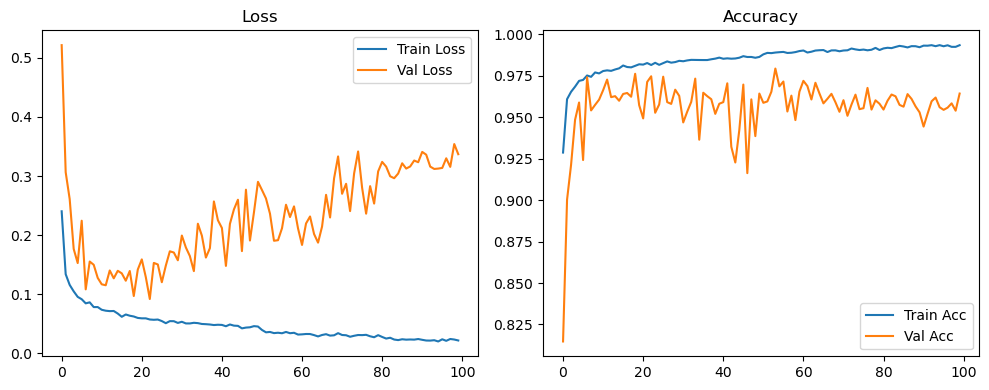

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1151, Acc: 0.9662 | Val Loss: 0.0585, Acc: 0.9815


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9844 | Val Loss: 0.0420, Acc: 0.9885


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9883 | Val Loss: 0.0440, Acc: 0.9863


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9910 | Val Loss: 0.0394, Acc: 0.9878


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0429, Acc: 0.9880


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0401, Acc: 0.9897


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0413, Acc: 0.9891


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.0417, Acc: 0.9885


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9956 | Val Loss: 0.0447, Acc: 0.9882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0633, Acc: 0.9863


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0476, Acc: 0.9889


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0547, Acc: 0.9873


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0463, Acc: 0.9894


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9970 | Val Loss: 0.0498, Acc: 0.9883


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0439, Acc: 0.9912


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9968 | Val Loss: 0.0481, Acc: 0.9903


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0703, Acc: 0.9865


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0466, Acc: 0.9911


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0466, Acc: 0.9912


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0508, Acc: 0.9919


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0537, Acc: 0.9913


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0503, Acc: 0.9904


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0602, Acc: 0.9893


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0576, Acc: 0.9898


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0519, Acc: 0.9902


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0601, Acc: 0.9900


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0817, Acc: 0.9862


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0644, Acc: 0.9899


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0622, Acc: 0.9898


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0743, Acc: 0.9901


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0722, Acc: 0.9899


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0715, Acc: 0.9886


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0740, Acc: 0.9885


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0763, Acc: 0.9906


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0794, Acc: 0.9894


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.0762, Acc: 0.9884


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0744, Acc: 0.9906


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0759, Acc: 0.9896


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0677, Acc: 0.9907


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0687, Acc: 0.9913


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0795, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0720, Acc: 0.9896


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0764, Acc: 0.9901


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0799, Acc: 0.9892


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0734, Acc: 0.9900


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0760, Acc: 0.9902


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0794, Acc: 0.9895


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0830, Acc: 0.9897


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0736, Acc: 0.9915


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0774, Acc: 0.9895


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0687, Acc: 0.9913


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0704, Acc: 0.9910


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0738, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0677, Acc: 0.9915


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0670, Acc: 0.9917


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0648, Acc: 0.9925


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0654, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0639, Acc: 0.9924


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0628, Acc: 0.9928


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0705, Acc: 0.9923


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0703, Acc: 0.9925


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9928


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0680, Acc: 0.9925


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0740, Acc: 0.9919


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0738, Acc: 0.9921


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0714, Acc: 0.9922


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0725, Acc: 0.9924


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0702, Acc: 0.9918


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0721, Acc: 0.9924


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0781, Acc: 0.9927


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0739, Acc: 0.9928


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0720, Acc: 0.9927


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0811, Acc: 0.9918


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0802, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0758, Acc: 0.9930


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0757, Acc: 0.9932


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0809, Acc: 0.9924


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0772, Acc: 0.9922


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0802, Acc: 0.9921


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0772, Acc: 0.9928


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0766, Acc: 0.9926


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0758, Acc: 0.9929


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0759, Acc: 0.9925


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0803, Acc: 0.9931


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0802, Acc: 0.9931


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0788, Acc: 0.9927


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0797, Acc: 0.9929


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0798, Acc: 0.9931


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0826, Acc: 0.9928


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0816, Acc: 0.9926


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0842, Acc: 0.9926


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0784, Acc: 0.9932


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0787, Acc: 0.9933


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0773, Acc: 0.9932


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0803, Acc: 0.9929


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0787, Acc: 0.9929


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0799, Acc: 0.9930


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0764, Acc: 0.9938


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0774, Acc: 0.9936


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0750, Acc: 0.9932


Final Test Loss: 0.0808 Accuracy: 0.9926


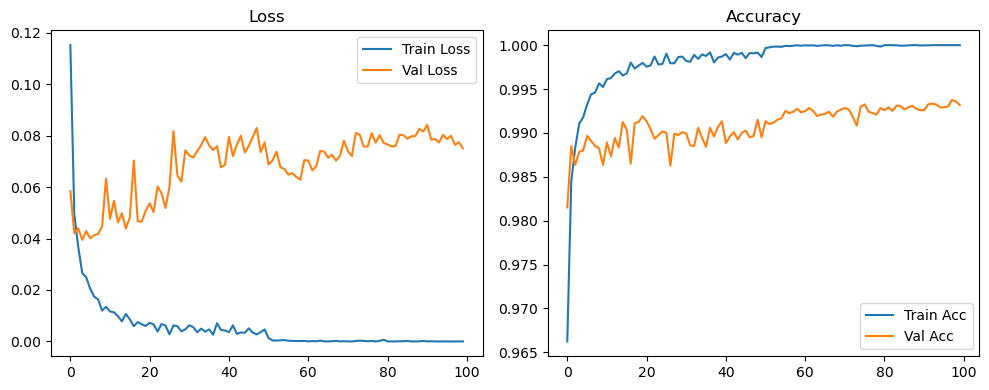

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1472, Acc: 0.9564 | Val Loss: 0.1103, Acc: 0.9644


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9788 | Val Loss: 0.0732, Acc: 0.9771


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9817 | Val Loss: 0.0549, Acc: 0.9840


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9847 | Val Loss: 0.0570, Acc: 0.9822


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9871 | Val Loss: 0.0612, Acc: 0.9815


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9888 | Val Loss: 0.0460, Acc: 0.9862


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0476, Acc: 0.9869


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.0482, Acc: 0.9850


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.0515, Acc: 0.9857


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9904 | Val Loss: 0.0602, Acc: 0.9824


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.0757, Acc: 0.9788


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.0393, Acc: 0.9887


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0524, Acc: 0.9851


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0572, Acc: 0.9853


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0671, Acc: 0.9818


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.0538, Acc: 0.9843


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.0569, Acc: 0.9856


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0573, Acc: 0.9848


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0384, Acc: 0.9902


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0583, Acc: 0.9838


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.0521, Acc: 0.9858


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0504, Acc: 0.9858


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9943 | Val Loss: 0.0445, Acc: 0.9893


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0589, Acc: 0.9835


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0478, Acc: 0.9862


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9948 | Val Loss: 0.0578, Acc: 0.9839


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0617, Acc: 0.9838


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.0620, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0439, Acc: 0.9886


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0587, Acc: 0.9831


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0524, Acc: 0.9872


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0703, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0492, Acc: 0.9878


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0504, Acc: 0.9874


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0483, Acc: 0.9870


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0508, Acc: 0.9867


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0657, Acc: 0.9829


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0475, Acc: 0.9876


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0520, Acc: 0.9870


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0398, Acc: 0.9897


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0528, Acc: 0.9855


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.0436, Acc: 0.9908


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0584, Acc: 0.9853


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0705, Acc: 0.9821


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0713, Acc: 0.9822


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0484, Acc: 0.9866


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0781, Acc: 0.9792


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0557, Acc: 0.9846


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0519, Acc: 0.9861


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0527, Acc: 0.9860


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0482, Acc: 0.9862


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9984 | Val Loss: 0.0489, Acc: 0.9863


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0443, Acc: 0.9889


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0447, Acc: 0.9885


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0452, Acc: 0.9879


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0383, Acc: 0.9894


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0443, Acc: 0.9889


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0410, Acc: 0.9902


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0422, Acc: 0.9898


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0438, Acc: 0.9892


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0435, Acc: 0.9892


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0407, Acc: 0.9900


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0420, Acc: 0.9899


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0431, Acc: 0.9904


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0438, Acc: 0.9902


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0429, Acc: 0.9896


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0459, Acc: 0.9898


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9990 | Val Loss: 0.0448, Acc: 0.9893


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0420, Acc: 0.9902


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0442, Acc: 0.9892


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0448, Acc: 0.9897


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0471, Acc: 0.9894


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0445, Acc: 0.9895


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0409, Acc: 0.9903


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0434, Acc: 0.9901


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0468, Acc: 0.9892


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0473, Acc: 0.9888


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0401, Acc: 0.9908


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0495, Acc: 0.9892


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0467, Acc: 0.9888


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0456, Acc: 0.9895


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0408, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0447, Acc: 0.9899


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0442, Acc: 0.9896


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0445, Acc: 0.9905


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0426, Acc: 0.9905


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0408, Acc: 0.9903


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0475, Acc: 0.9885


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0463, Acc: 0.9897


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0447, Acc: 0.9892


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0463, Acc: 0.9892


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0424, Acc: 0.9902


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0439, Acc: 0.9901


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0423, Acc: 0.9903


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0457, Acc: 0.9899


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0458, Acc: 0.9893


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0453, Acc: 0.9901


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0452, Acc: 0.9899


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0439, Acc: 0.9906


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0404, Acc: 0.9910


Final Test Loss: 0.0373 Accuracy: 0.9901


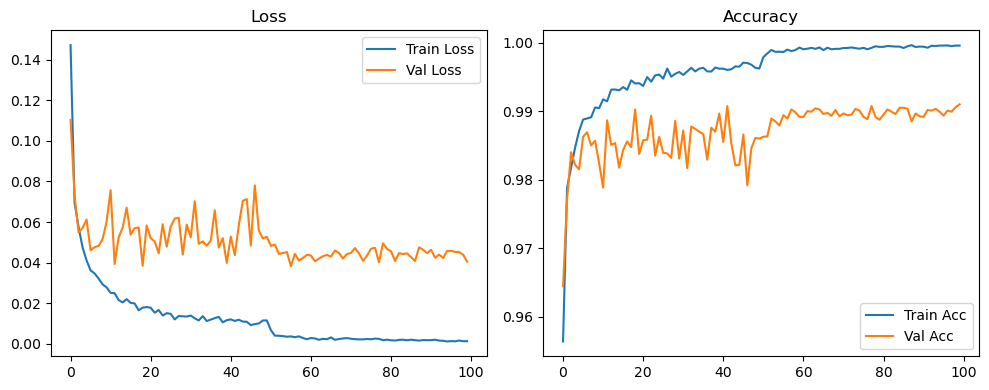

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2406, Acc: 0.9290 | Val Loss: 0.4363, Acc: 0.8539


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1337, Acc: 0.9604 | Val Loss: 0.3074, Acc: 0.9032


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1160, Acc: 0.9648 | Val Loss: 0.2916, Acc: 0.9037


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1067, Acc: 0.9683 | Val Loss: 0.1952, Acc: 0.9460


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0973, Acc: 0.9714 | Val Loss: 0.1969, Acc: 0.9346


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9721 | Val Loss: 0.1741, Acc: 0.9499


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9743 | Val Loss: 0.1175, Acc: 0.9718


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9736 | Val Loss: 0.1485, Acc: 0.9653


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9765 | Val Loss: 0.2432, Acc: 0.9177


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9772 | Val Loss: 0.1941, Acc: 0.9378


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0732, Acc: 0.9775 | Val Loss: 0.1221, Acc: 0.9664


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9779 | Val Loss: 0.1187, Acc: 0.9728


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9790 | Val Loss: 0.1658, Acc: 0.9504


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0705, Acc: 0.9790 | Val Loss: 0.1274, Acc: 0.9628


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0695, Acc: 0.9793 | Val Loss: 0.1419, Acc: 0.9658


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9806 | Val Loss: 0.1487, Acc: 0.9584


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9809 | Val Loss: 0.1446, Acc: 0.9613


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9802 | Val Loss: 0.1321, Acc: 0.9654


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0643, Acc: 0.9809 | Val Loss: 0.0953, Acc: 0.9766


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9812 | Val Loss: 0.1182, Acc: 0.9698


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0614, Acc: 0.9807 | Val Loss: 0.1325, Acc: 0.9729


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9821 | Val Loss: 0.1329, Acc: 0.9692


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9822 | Val Loss: 0.1355, Acc: 0.9646


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9823 | Val Loss: 0.1278, Acc: 0.9708


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9818 | Val Loss: 0.1587, Acc: 0.9623


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9822 | Val Loss: 0.1555, Acc: 0.9672


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9831 | Val Loss: 0.1984, Acc: 0.9517


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9830 | Val Loss: 0.1914, Acc: 0.9420


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9835 | Val Loss: 0.1881, Acc: 0.9605


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9835 | Val Loss: 0.1723, Acc: 0.9560


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9842 | Val Loss: 0.2029, Acc: 0.9556


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9844 | Val Loss: 0.1711, Acc: 0.9668


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0523, Acc: 0.9839 | Val Loss: 0.1897, Acc: 0.9573


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9845 | Val Loss: 0.1658, Acc: 0.9610


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9847 | Val Loss: 0.1629, Acc: 0.9696


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9860 | Val Loss: 0.1686, Acc: 0.9611


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9845 | Val Loss: 0.1934, Acc: 0.9535


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9850 | Val Loss: 0.2216, Acc: 0.9574


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9855 | Val Loss: 0.2476, Acc: 0.9593


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9854 | Val Loss: 0.1912, Acc: 0.9677


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9850 | Val Loss: 0.2623, Acc: 0.9536


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9854 | Val Loss: 0.1716, Acc: 0.9692


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9854 | Val Loss: 0.2134, Acc: 0.9531


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9862 | Val Loss: 0.2162, Acc: 0.9619


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9847 | Val Loss: 0.3094, Acc: 0.9528


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9864 | Val Loss: 0.2833, Acc: 0.9559


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.3017, Acc: 0.9262


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9862 | Val Loss: 0.2289, Acc: 0.9562


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9856 | Val Loss: 0.2780, Acc: 0.9519


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9859 | Val Loss: 0.2679, Acc: 0.9525


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9871 | Val Loss: 0.2916, Acc: 0.9593


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0354, Acc: 0.9890 | Val Loss: 0.3212, Acc: 0.9510


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9900 | Val Loss: 0.2829, Acc: 0.9571


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.2745, Acc: 0.9657


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9903 | Val Loss: 0.2441, Acc: 0.9583


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9906 | Val Loss: 0.2323, Acc: 0.9663


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9897 | Val Loss: 0.2885, Acc: 0.9539


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9896 | Val Loss: 0.2572, Acc: 0.9632


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.2649, Acc: 0.9521


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.2527, Acc: 0.9555


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9909 | Val Loss: 0.2599, Acc: 0.9587


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9911 | Val Loss: 0.2251, Acc: 0.9655


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.2330, Acc: 0.9689


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.2522, Acc: 0.9674


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.2457, Acc: 0.9627


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.2497, Acc: 0.9661


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.2701, Acc: 0.9617


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.2480, Acc: 0.9645


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.2609, Acc: 0.9621


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9907 | Val Loss: 0.3022, Acc: 0.9553


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.2917, Acc: 0.9609


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.2918, Acc: 0.9577


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.3288, Acc: 0.9407


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.2947, Acc: 0.9571


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.2918, Acc: 0.9563


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.3274, Acc: 0.9616


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.3413, Acc: 0.9558


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9919 | Val Loss: 0.3102, Acc: 0.9555


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.2738, Acc: 0.9635


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9912 | Val Loss: 0.3000, Acc: 0.9607


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.3078, Acc: 0.9599


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.3215, Acc: 0.9611


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.3174, Acc: 0.9600


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.3362, Acc: 0.9580


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.3395, Acc: 0.9573


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.3414, Acc: 0.9554


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.3607, Acc: 0.9571


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.3714, Acc: 0.9523


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.4034, Acc: 0.9451


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.3897, Acc: 0.9470


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9933 | Val Loss: 0.3762, Acc: 0.9481


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9928 | Val Loss: 0.3594, Acc: 0.9487


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.3604, Acc: 0.9537


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.3633, Acc: 0.9539


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9934 | Val Loss: 0.3391, Acc: 0.9493


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9921 | Val Loss: 0.3463, Acc: 0.9479


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.3862, Acc: 0.9442


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.3698, Acc: 0.9501


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9924 | Val Loss: 0.3926, Acc: 0.9532


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.3703, Acc: 0.9573


Final Test Loss: 0.3698 Accuracy: 0.9549


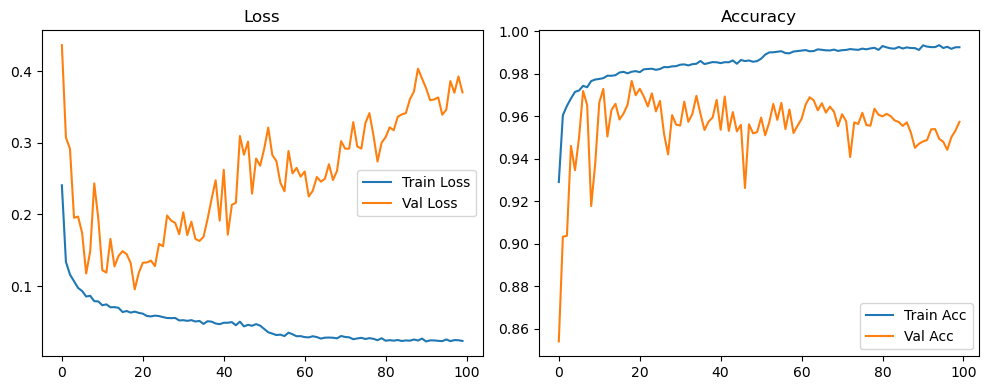

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1139, Acc: 0.9679 | Val Loss: 0.0530, Acc: 0.9838


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9859 | Val Loss: 0.0390, Acc: 0.9886


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.0418, Acc: 0.9880


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0406, Acc: 0.9887


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0407, Acc: 0.9884


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0388, Acc: 0.9900


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0430, Acc: 0.9888


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0404, Acc: 0.9900


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0409, Acc: 0.9900


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0467, Acc: 0.9898


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0483, Acc: 0.9890


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0428, Acc: 0.9907


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0558, Acc: 0.9891


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0477, Acc: 0.9909


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0493, Acc: 0.9899


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0576, Acc: 0.9885


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0416, Acc: 0.9909


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0486, Acc: 0.9888


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0502, Acc: 0.9900


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0436, Acc: 0.9904


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0475, Acc: 0.9910


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0594, Acc: 0.9889


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0572, Acc: 0.9902


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0563, Acc: 0.9898


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0713, Acc: 0.9865


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0504, Acc: 0.9913


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0664, Acc: 0.9879


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0551, Acc: 0.9898


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0534, Acc: 0.9902


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0473, Acc: 0.9925


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0499, Acc: 0.9904


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0553, Acc: 0.9914


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0600, Acc: 0.9904


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0570, Acc: 0.9900


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0554, Acc: 0.9901


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0606, Acc: 0.9908


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0589, Acc: 0.9909


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0610, Acc: 0.9902


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0605, Acc: 0.9895


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0622, Acc: 0.9901


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0649, Acc: 0.9902


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0685, Acc: 0.9898


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0722, Acc: 0.9895


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0701, Acc: 0.9897


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0737, Acc: 0.9887


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0614, Acc: 0.9915


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0714, Acc: 0.9910


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0644, Acc: 0.9916


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0636, Acc: 0.9916


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0843, Acc: 0.9889


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0652, Acc: 0.9903


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0673, Acc: 0.9909


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0717, Acc: 0.9896


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0637, Acc: 0.9911


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0669, Acc: 0.9901


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0690, Acc: 0.9898


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0620, Acc: 0.9911


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0836, Acc: 0.9883


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0610, Acc: 0.9906


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0764, Acc: 0.9902


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0729, Acc: 0.9904


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0677, Acc: 0.9908


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0714, Acc: 0.9900


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0744, Acc: 0.9919


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0658, Acc: 0.9908


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0647, Acc: 0.9912


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0741, Acc: 0.9905


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0743, Acc: 0.9896


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0670, Acc: 0.9912


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0653, Acc: 0.9907


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0837, Acc: 0.9885


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0803, Acc: 0.9908


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0760, Acc: 0.9912


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0751, Acc: 0.9901


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0761, Acc: 0.9909


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0700, Acc: 0.9897


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0808, Acc: 0.9902


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0819, Acc: 0.9905


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0725, Acc: 0.9910


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0706, Acc: 0.9916


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0763, Acc: 0.9918


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0733, Acc: 0.9908


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0655, Acc: 0.9915


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0654, Acc: 0.9917


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0831, Acc: 0.9901


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0701, Acc: 0.9905


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0745, Acc: 0.9914


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0790, Acc: 0.9912


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0731, Acc: 0.9918


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1011, Acc: 0.9890


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0741, Acc: 0.9914


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0822, Acc: 0.9898


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0765, Acc: 0.9905


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9911


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0696, Acc: 0.9911


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0839, Acc: 0.9917


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0931, Acc: 0.9887


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0896, Acc: 0.9898


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0804, Acc: 0.9900


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0831, Acc: 0.9910


Final Test Loss: 0.0848 Accuracy: 0.9902


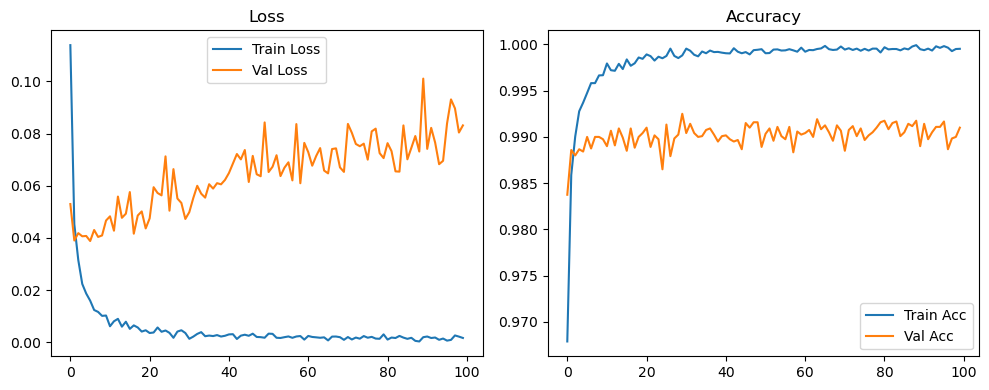

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1416, Acc: 0.9604 | Val Loss: 0.1479, Acc: 0.9543


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9801 | Val Loss: 0.0583, Acc: 0.9824


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9841 | Val Loss: 0.0597, Acc: 0.9813


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9865 | Val Loss: 0.0530, Acc: 0.9822


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9877 | Val Loss: 0.0531, Acc: 0.9837


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0524, Acc: 0.9846


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0501, Acc: 0.9852


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.0571, Acc: 0.9819


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9918 | Val Loss: 0.0444, Acc: 0.9876


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.0468, Acc: 0.9869


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9934 | Val Loss: 0.0592, Acc: 0.9837


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9929 | Val Loss: 0.0446, Acc: 0.9882


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0528, Acc: 0.9841


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.0443, Acc: 0.9872


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0554, Acc: 0.9846


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0496, Acc: 0.9862


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0441, Acc: 0.9868


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0434, Acc: 0.9888


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0444, Acc: 0.9876


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0474, Acc: 0.9869


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0480, Acc: 0.9865


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0382, Acc: 0.9894


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0429, Acc: 0.9880


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0412, Acc: 0.9885


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.0559, Acc: 0.9851


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0531, Acc: 0.9855


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0450, Acc: 0.9887


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0415, Acc: 0.9886


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0422, Acc: 0.9885


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0417, Acc: 0.9890


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0447, Acc: 0.9879


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0532, Acc: 0.9869


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0390, Acc: 0.9868


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0417, Acc: 0.9883


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0423, Acc: 0.9888


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0459, Acc: 0.9875


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0440, Acc: 0.9879


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0423, Acc: 0.9881


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0438, Acc: 0.9884


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0441, Acc: 0.9888


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0464, Acc: 0.9878


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0419, Acc: 0.9891


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0394, Acc: 0.9906


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0485, Acc: 0.9875


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0538, Acc: 0.9855


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0487, Acc: 0.9858


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0467, Acc: 0.9883


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0389, Acc: 0.9888


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0491, Acc: 0.9857


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0434, Acc: 0.9870


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0463, Acc: 0.9867


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0527, Acc: 0.9866


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0469, Acc: 0.9874


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0447, Acc: 0.9895


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0465, Acc: 0.9879


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0399, Acc: 0.9894


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0429, Acc: 0.9892


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0439, Acc: 0.9878


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0428, Acc: 0.9883


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0412, Acc: 0.9883


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0404, Acc: 0.9891


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0450, Acc: 0.9874


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0398, Acc: 0.9886


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0396, Acc: 0.9896


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0453, Acc: 0.9877


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0421, Acc: 0.9882


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0454, Acc: 0.9878


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0511, Acc: 0.9867


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0497, Acc: 0.9865


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0435, Acc: 0.9870


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0401, Acc: 0.9880


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0426, Acc: 0.9875


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0464, Acc: 0.9868


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0429, Acc: 0.9882


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0401, Acc: 0.9892


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0385, Acc: 0.9902


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0564, Acc: 0.9848


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0408, Acc: 0.9876


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0494, Acc: 0.9854


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0419, Acc: 0.9885


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0409, Acc: 0.9886


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0463, Acc: 0.9872


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0491, Acc: 0.9865


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.0419, Acc: 0.9885


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0469, Acc: 0.9871


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0406, Acc: 0.9887


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0417, Acc: 0.9887


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0488, Acc: 0.9869


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0489, Acc: 0.9861


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0577, Acc: 0.9839


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0490, Acc: 0.9867


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0409, Acc: 0.9886


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0449, Acc: 0.9874


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0439, Acc: 0.9876


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0472, Acc: 0.9876


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0527, Acc: 0.9859


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0528, Acc: 0.9855


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0588, Acc: 0.9842


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0467, Acc: 0.9882


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0430, Acc: 0.9885


Final Test Loss: 0.0450 Accuracy: 0.9870


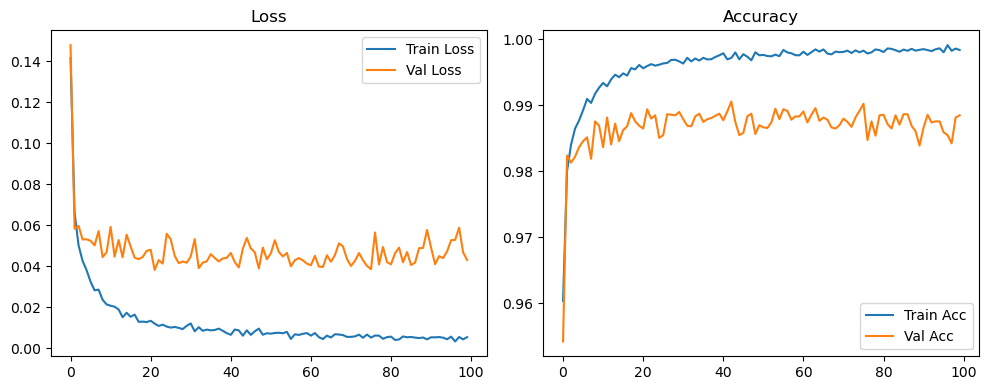

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2361, Acc: 0.9342 | Val Loss: 0.6423, Acc: 0.7758


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1277, Acc: 0.9619 | Val Loss: 0.2858, Acc: 0.9121


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9683 | Val Loss: 0.3504, Acc: 0.8846


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0963, Acc: 0.9705 | Val Loss: 0.2086, Acc: 0.9443


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0885, Acc: 0.9736 | Val Loss: 0.1521, Acc: 0.9595


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0840, Acc: 0.9745 | Val Loss: 0.1894, Acc: 0.9434


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9767 | Val Loss: 0.1571, Acc: 0.9543


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0785, Acc: 0.9769 | Val Loss: 0.1921, Acc: 0.9408


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0685, Acc: 0.9795 | Val Loss: 0.1691, Acc: 0.9517


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9801 | Val Loss: 0.1280, Acc: 0.9645


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0658, Acc: 0.9798 | Val Loss: 0.1250, Acc: 0.9661


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9802 | Val Loss: 0.1028, Acc: 0.9771


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9815 | Val Loss: 0.1733, Acc: 0.9433


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9817 | Val Loss: 0.1995, Acc: 0.9395


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9810 | Val Loss: 0.1306, Acc: 0.9636


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9827 | Val Loss: 0.1314, Acc: 0.9635


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9832 | Val Loss: 0.1122, Acc: 0.9720


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9830 | Val Loss: 0.1259, Acc: 0.9630


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9836 | Val Loss: 0.1019, Acc: 0.9748


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9840 | Val Loss: 0.1317, Acc: 0.9679


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0532, Acc: 0.9838 | Val Loss: 0.1275, Acc: 0.9698


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9847 | Val Loss: 0.1116, Acc: 0.9754


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0468, Acc: 0.9861 | Val Loss: 0.1449, Acc: 0.9684


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9850 | Val Loss: 0.1550, Acc: 0.9674


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9854 | Val Loss: 0.1574, Acc: 0.9669


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0488, Acc: 0.9843 | Val Loss: 0.1603, Acc: 0.9683


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9863 | Val Loss: 0.1517, Acc: 0.9792


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9853 | Val Loss: 0.1526, Acc: 0.9710


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9856 | Val Loss: 0.2344, Acc: 0.9633


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0444, Acc: 0.9857 | Val Loss: 0.2450, Acc: 0.9339


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9861 | Val Loss: 0.1818, Acc: 0.9657


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9861 | Val Loss: 0.2024, Acc: 0.9737


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9856 | Val Loss: 0.2116, Acc: 0.9634


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9873 | Val Loss: 0.1787, Acc: 0.9729


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9866 | Val Loss: 0.1731, Acc: 0.9728


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9877 | Val Loss: 0.1817, Acc: 0.9725


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9870 | Val Loss: 0.1983, Acc: 0.9653


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9870 | Val Loss: 0.1864, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9871 | Val Loss: 0.2280, Acc: 0.9659


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9859 | Val Loss: 0.2298, Acc: 0.9665


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9869 | Val Loss: 0.2446, Acc: 0.9628


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.2190, Acc: 0.9694


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9873 | Val Loss: 0.2903, Acc: 0.9517


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.2363, Acc: 0.9567


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9876 | Val Loss: 0.1625, Acc: 0.9768


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.2082, Acc: 0.9678


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.2322, Acc: 0.9595


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.1949, Acc: 0.9757


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.2457, Acc: 0.9712


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9878 | Val Loss: 0.3257, Acc: 0.9557


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9870 | Val Loss: 0.2995, Acc: 0.9702


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.3137, Acc: 0.9578


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 0.2992, Acc: 0.9584


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9887 | Val Loss: 0.2245, Acc: 0.9716


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9888 | Val Loss: 0.2459, Acc: 0.9649


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.2605, Acc: 0.9627


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9887 | Val Loss: 0.3231, Acc: 0.9511


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9878 | Val Loss: 0.3198, Acc: 0.9516


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9887 | Val Loss: 0.3079, Acc: 0.9338


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9884 | Val Loss: 0.3610, Acc: 0.9494


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.3472, Acc: 0.9506


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9888 | Val Loss: 0.3466, Acc: 0.9666


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.3079, Acc: 0.9754


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9892 | Val Loss: 0.3887, Acc: 0.9587


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.4102, Acc: 0.9273


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.2967, Acc: 0.9521


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9891 | Val Loss: 0.2377, Acc: 0.9656


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.2854, Acc: 0.9532


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.3324, Acc: 0.9413


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.3039, Acc: 0.9513


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9888 | Val Loss: 0.2920, Acc: 0.9563


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.3226, Acc: 0.9487


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.3497, Acc: 0.9493


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9891 | Val Loss: 0.4968, Acc: 0.9237


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9897 | Val Loss: 0.4795, Acc: 0.9469


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.4808, Acc: 0.9363


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.4530, Acc: 0.9271


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.4014, Acc: 0.9543


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.3457, Acc: 0.9469


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9893 | Val Loss: 0.5098, Acc: 0.9331


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.4477, Acc: 0.9535


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.5312, Acc: 0.9266


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9904 | Val Loss: 0.4640, Acc: 0.9511


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.5301, Acc: 0.9329


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9907 | Val Loss: 0.3898, Acc: 0.9480


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.4353, Acc: 0.9347


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.5378, Acc: 0.9295


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.4920, Acc: 0.9235


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9897 | Val Loss: 0.5225, Acc: 0.9394


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9900 | Val Loss: 0.5044, Acc: 0.9499


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9905 | Val Loss: 0.4031, Acc: 0.9551


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.7325, Acc: 0.9267


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9901 | Val Loss: 0.7247, Acc: 0.9088


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9906 | Val Loss: 0.6033, Acc: 0.9060


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.4655, Acc: 0.9513


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.4595, Acc: 0.9573


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9905 | Val Loss: 0.5221, Acc: 0.9357


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.5980, Acc: 0.9127


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9897 | Val Loss: 0.6638, Acc: 0.9265


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9913 | Val Loss: 0.4525, Acc: 0.9617


Final Test Loss: 0.4485 Accuracy: 0.9617


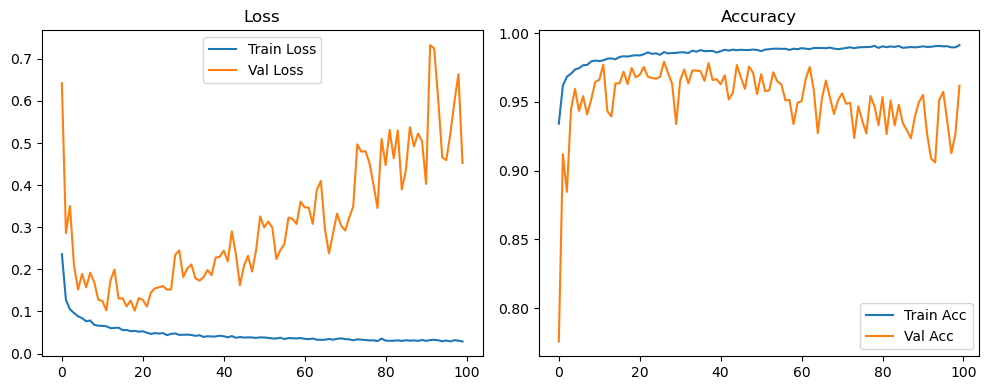

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1133, Acc: 0.9682 | Val Loss: 0.0554, Acc: 0.9826


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9856 | Val Loss: 0.0387, Acc: 0.9888


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0472, Acc: 0.9865


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0372, Acc: 0.9882


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.0412, Acc: 0.9871


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0391, Acc: 0.9889


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0412, Acc: 0.9882


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0492, Acc: 0.9870


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0499, Acc: 0.9875


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0406, Acc: 0.9892


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0480, Acc: 0.9886


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0442, Acc: 0.9890


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0589, Acc: 0.9872


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0448, Acc: 0.9907


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0534, Acc: 0.9887


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0457, Acc: 0.9906


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0508, Acc: 0.9878


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0500, Acc: 0.9903


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0461, Acc: 0.9902


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0546, Acc: 0.9884


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0445, Acc: 0.9912


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0477, Acc: 0.9902


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0541, Acc: 0.9906


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0481, Acc: 0.9902


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0567, Acc: 0.9891


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0596, Acc: 0.9886


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0676, Acc: 0.9868


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0553, Acc: 0.9892


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0559, Acc: 0.9894


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0492, Acc: 0.9915


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0616, Acc: 0.9904


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0600, Acc: 0.9898


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0580, Acc: 0.9908


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0555, Acc: 0.9906


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0660, Acc: 0.9892


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0649, Acc: 0.9903


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0563, Acc: 0.9910


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0556, Acc: 0.9907


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0590, Acc: 0.9899


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0604, Acc: 0.9904


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0637, Acc: 0.9902


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0543, Acc: 0.9911


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0641, Acc: 0.9902


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0650, Acc: 0.9888


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0675, Acc: 0.9883


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0681, Acc: 0.9896


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0637, Acc: 0.9902


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0560, Acc: 0.9894


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0565, Acc: 0.9910


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0611, Acc: 0.9901


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0559, Acc: 0.9915


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0539, Acc: 0.9914


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0504, Acc: 0.9921


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9921


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0563, Acc: 0.9921


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0536, Acc: 0.9925


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0610, Acc: 0.9918


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0589, Acc: 0.9912


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0572, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0578, Acc: 0.9919


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0634, Acc: 0.9908


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9915


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0593, Acc: 0.9918


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9919


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0583, Acc: 0.9916


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0680, Acc: 0.9904


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0679, Acc: 0.9914


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0635, Acc: 0.9918


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0612, Acc: 0.9916


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0679, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0645, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0635, Acc: 0.9917


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0682, Acc: 0.9908


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0642, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0660, Acc: 0.9917


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0665, Acc: 0.9911


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0737, Acc: 0.9915


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0731, Acc: 0.9903


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0688, Acc: 0.9916


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0693, Acc: 0.9915


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0672, Acc: 0.9917


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0641, Acc: 0.9921


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0685, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0658, Acc: 0.9918


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0661, Acc: 0.9916


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9918


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0654, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0718, Acc: 0.9913


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9918


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0713, Acc: 0.9918


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0665, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9925


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0676, Acc: 0.9923


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0687, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0693, Acc: 0.9924


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0675, Acc: 0.9919


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0706, Acc: 0.9920


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0692, Acc: 0.9925


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9921


Final Test Loss: 0.0588 Accuracy: 0.9918


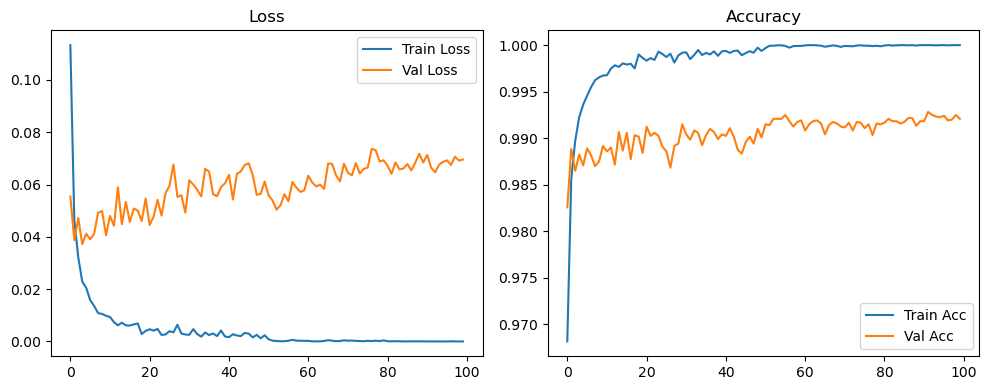

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1409, Acc: 0.9601 | Val Loss: 0.1367, Acc: 0.9557


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9798 | Val Loss: 0.0545, Acc: 0.9842


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0513, Acc: 0.9835 | Val Loss: 0.0608, Acc: 0.9807


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.0527, Acc: 0.9836


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.0541, Acc: 0.9820


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.0517, Acc: 0.9843


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9904 | Val Loss: 0.0486, Acc: 0.9859


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.0420, Acc: 0.9871


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0404, Acc: 0.9873


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9928 | Val Loss: 0.0531, Acc: 0.9839


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0466, Acc: 0.9867


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9942 | Val Loss: 0.0432, Acc: 0.9878


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0407, Acc: 0.9877


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9944 | Val Loss: 0.0340, Acc: 0.9900


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0501, Acc: 0.9858


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0424, Acc: 0.9882


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0458, Acc: 0.9870


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9950 | Val Loss: 0.0468, Acc: 0.9866


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9951 | Val Loss: 0.0421, Acc: 0.9888


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0471, Acc: 0.9861


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0434, Acc: 0.9885


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0380, Acc: 0.9898


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0360, Acc: 0.9909


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0342, Acc: 0.9916


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0584, Acc: 0.9837


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.0418, Acc: 0.9878


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.0466, Acc: 0.9881


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0395, Acc: 0.9894


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0436, Acc: 0.9880


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0415, Acc: 0.9887


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.0566, Acc: 0.9849


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0453, Acc: 0.9884


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0449, Acc: 0.9881


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0425, Acc: 0.9884


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0350, Acc: 0.9898


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0490, Acc: 0.9874


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0397, Acc: 0.9889


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0505, Acc: 0.9868


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0393, Acc: 0.9898


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0464, Acc: 0.9881


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0392, Acc: 0.9898


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0402, Acc: 0.9893


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0479, Acc: 0.9870


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0536, Acc: 0.9850


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0418, Acc: 0.9887


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0411, Acc: 0.9885


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0468, Acc: 0.9875


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0440, Acc: 0.9883


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0522, Acc: 0.9871


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0426, Acc: 0.9885


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0374, Acc: 0.9905


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0443, Acc: 0.9893


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0376, Acc: 0.9907


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0353, Acc: 0.9912


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0386, Acc: 0.9903


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0392, Acc: 0.9904


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0409, Acc: 0.9906


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0341, Acc: 0.9912


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0390, Acc: 0.9893


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0407, Acc: 0.9902


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0348, Acc: 0.9914


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0377, Acc: 0.9913


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0348, Acc: 0.9909


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0372, Acc: 0.9910


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0394, Acc: 0.9898


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0379, Acc: 0.9907


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0386, Acc: 0.9893


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0378, Acc: 0.9909


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0402, Acc: 0.9901


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0384, Acc: 0.9902


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0394, Acc: 0.9897


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0460, Acc: 0.9878


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0433, Acc: 0.9894


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0433, Acc: 0.9896


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0403, Acc: 0.9901


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0385, Acc: 0.9898


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0462, Acc: 0.9893


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0405, Acc: 0.9905


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9902


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0424, Acc: 0.9892


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0432, Acc: 0.9896


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0381, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0412, Acc: 0.9893


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0432, Acc: 0.9898


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0401, Acc: 0.9900


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0405, Acc: 0.9897


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0399, Acc: 0.9903


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0419, Acc: 0.9893


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0388, Acc: 0.9902


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0396, Acc: 0.9896


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0412, Acc: 0.9901


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0389, Acc: 0.9903


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0408, Acc: 0.9905


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0350, Acc: 0.9908


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0388, Acc: 0.9900


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0394, Acc: 0.9908


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0419, Acc: 0.9901


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0412, Acc: 0.9898


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0394, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0368, Acc: 0.9903


Final Test Loss: 0.0374 Accuracy: 0.9898


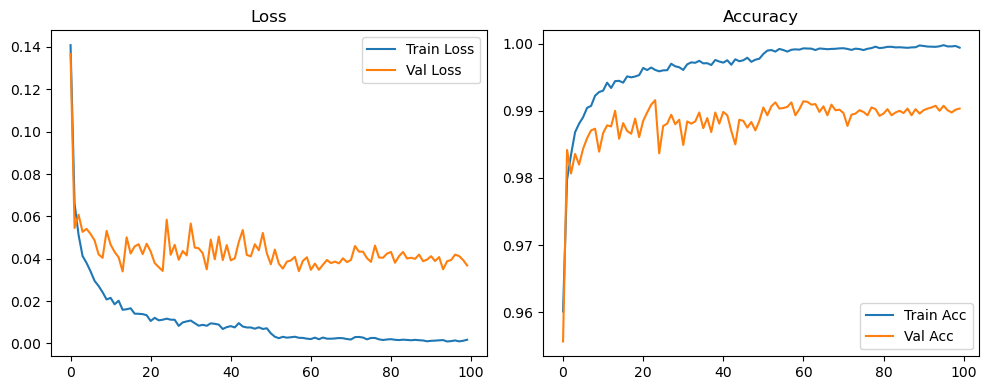

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2378, Acc: 0.9334 | Val Loss: 0.8344, Acc: 0.6987


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1270, Acc: 0.9621 | Val Loss: 0.2577, Acc: 0.9193


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1044, Acc: 0.9687 | Val Loss: 0.3205, Acc: 0.8960


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0963, Acc: 0.9714 | Val Loss: 0.2709, Acc: 0.9144


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0890, Acc: 0.9734 | Val Loss: 0.1431, Acc: 0.9609


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0824, Acc: 0.9754 | Val Loss: 0.2257, Acc: 0.9263


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0763, Acc: 0.9766 | Val Loss: 0.1222, Acc: 0.9660


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9764 | Val Loss: 0.1723, Acc: 0.9489


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0698, Acc: 0.9793 | Val Loss: 0.1784, Acc: 0.9473


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9791 | Val Loss: 0.1700, Acc: 0.9471


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0649, Acc: 0.9798 | Val Loss: 0.1388, Acc: 0.9590


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0643, Acc: 0.9799 | Val Loss: 0.1124, Acc: 0.9702


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9813 | Val Loss: 0.1556, Acc: 0.9534


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0604, Acc: 0.9818 | Val Loss: 0.0995, Acc: 0.9772


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9824 | Val Loss: 0.1037, Acc: 0.9748


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0544, Acc: 0.9821 | Val Loss: 0.1175, Acc: 0.9693


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9832 | Val Loss: 0.1137, Acc: 0.9735


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9832 | Val Loss: 0.1357, Acc: 0.9630


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9835 | Val Loss: 0.1005, Acc: 0.9793


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.1582, Acc: 0.9567


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9835 | Val Loss: 0.1103, Acc: 0.9748


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0502, Acc: 0.9843 | Val Loss: 0.1112, Acc: 0.9756


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9850 | Val Loss: 0.1331, Acc: 0.9688


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0511, Acc: 0.9840 | Val Loss: 0.1530, Acc: 0.9627


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9852 | Val Loss: 0.1462, Acc: 0.9597


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9845 | Val Loss: 0.1441, Acc: 0.9734


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9860 | Val Loss: 0.1624, Acc: 0.9648


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9848 | Val Loss: 0.1261, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0474, Acc: 0.9853 | Val Loss: 0.1548, Acc: 0.9746


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9859 | Val Loss: 0.1653, Acc: 0.9639


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9865 | Val Loss: 0.1335, Acc: 0.9725


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9861 | Val Loss: 0.1304, Acc: 0.9772


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9869 | Val Loss: 0.1408, Acc: 0.9712


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9876 | Val Loss: 0.1620, Acc: 0.9703


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9869 | Val Loss: 0.1648, Acc: 0.9713


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9873 | Val Loss: 0.1379, Acc: 0.9698


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9864 | Val Loss: 0.1760, Acc: 0.9561


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9861 | Val Loss: 0.2000, Acc: 0.9611


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9877 | Val Loss: 0.1865, Acc: 0.9636


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9866 | Val Loss: 0.1549, Acc: 0.9706


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9873 | Val Loss: 0.2055, Acc: 0.9655


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9883 | Val Loss: 0.2068, Acc: 0.9702


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9869 | Val Loss: 0.2202, Acc: 0.9605


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9878 | Val Loss: 0.2209, Acc: 0.9607


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9879 | Val Loss: 0.1749, Acc: 0.9741


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.1686, Acc: 0.9715


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9885 | Val Loss: 0.1830, Acc: 0.9637


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9877 | Val Loss: 0.1816, Acc: 0.9762


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9884 | Val Loss: 0.2253, Acc: 0.9674


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9879 | Val Loss: 0.2361, Acc: 0.9644


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9891 | Val Loss: 0.2231, Acc: 0.9688


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1895, Acc: 0.9712


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.2218, Acc: 0.9722


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.2341, Acc: 0.9756


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.2344, Acc: 0.9707


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.2651, Acc: 0.9761


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9908 | Val Loss: 0.2573, Acc: 0.9668


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9906 | Val Loss: 0.2308, Acc: 0.9726


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.2678, Acc: 0.9624


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.2757, Acc: 0.9683


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9908 | Val Loss: 0.2822, Acc: 0.9703


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.2190, Acc: 0.9732


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.2660, Acc: 0.9750


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.2453, Acc: 0.9721


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9920 | Val Loss: 0.2867, Acc: 0.9691


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.2354, Acc: 0.9747


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.2538, Acc: 0.9738


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.2908, Acc: 0.9702


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9917 | Val Loss: 0.2550, Acc: 0.9666


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.2448, Acc: 0.9713


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.2627, Acc: 0.9678


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.2519, Acc: 0.9631


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9915 | Val Loss: 0.2986, Acc: 0.9583


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.2920, Acc: 0.9538


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9915 | Val Loss: 0.3162, Acc: 0.9635


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9921 | Val Loss: 0.3135, Acc: 0.9726


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9921 | Val Loss: 0.3158, Acc: 0.9669


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.3477, Acc: 0.9664


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9925 | Val Loss: 0.3044, Acc: 0.9722


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.3675, Acc: 0.9631


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.3751, Acc: 0.9679


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9930 | Val Loss: 0.3892, Acc: 0.9648


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.3459, Acc: 0.9677


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.3569, Acc: 0.9685


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9934 | Val Loss: 0.3446, Acc: 0.9697


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.4051, Acc: 0.9589


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.4186, Acc: 0.9632


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.4065, Acc: 0.9564


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.3812, Acc: 0.9572


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.3724, Acc: 0.9629


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.3691, Acc: 0.9622


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.4069, Acc: 0.9601


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9936 | Val Loss: 0.4528, Acc: 0.9553


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.4509, Acc: 0.9469


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.4148, Acc: 0.9503


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.3402, Acc: 0.9556


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.3602, Acc: 0.9583


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.3888, Acc: 0.9583


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.4839, Acc: 0.9409


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.4566, Acc: 0.9591


Final Test Loss: 0.4569 Accuracy: 0.9609


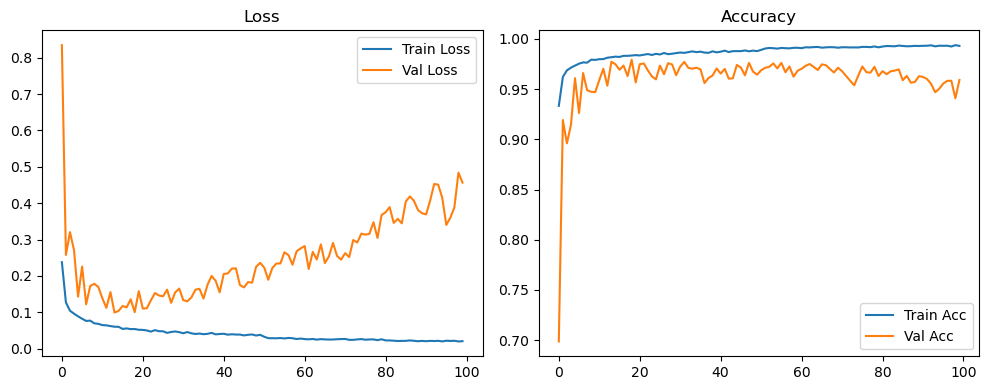

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1273, Acc: 0.9697 | Val Loss: 0.0516, Acc: 0.9841


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9865 | Val Loss: 0.0395, Acc: 0.9892


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.0373, Acc: 0.9889


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.0469, Acc: 0.9848


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0370, Acc: 0.9893


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.0363, Acc: 0.9893


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0402, Acc: 0.9895


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0586, Acc: 0.9840


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0386, Acc: 0.9889


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0438, Acc: 0.9897


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0421, Acc: 0.9887


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0499, Acc: 0.9880


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0409, Acc: 0.9908


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0421, Acc: 0.9902


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0575, Acc: 0.9882


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0483, Acc: 0.9884


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0510, Acc: 0.9887


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0366, Acc: 0.9909


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0517, Acc: 0.9884


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0458, Acc: 0.9894


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0423, Acc: 0.9901


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0425, Acc: 0.9908


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0500, Acc: 0.9898


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0506, Acc: 0.9897


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0573, Acc: 0.9881


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0469, Acc: 0.9913


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0498, Acc: 0.9897


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0455, Acc: 0.9914


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0615, Acc: 0.9878


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0459, Acc: 0.9913


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0519, Acc: 0.9899


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0488, Acc: 0.9897


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0436, Acc: 0.9915


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0482, Acc: 0.9907


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0540, Acc: 0.9889


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0507, Acc: 0.9902


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0552, Acc: 0.9901


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0483, Acc: 0.9907


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0506, Acc: 0.9897


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0554, Acc: 0.9888


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0508, Acc: 0.9903


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0546, Acc: 0.9906


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0525, Acc: 0.9909


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0573, Acc: 0.9908


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0506, Acc: 0.9908


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0499, Acc: 0.9917


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0474, Acc: 0.9917


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0534, Acc: 0.9906


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0542, Acc: 0.9895


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0474, Acc: 0.9912


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0559, Acc: 0.9902


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0593, Acc: 0.9894


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0587, Acc: 0.9892


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0524, Acc: 0.9910


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0585, Acc: 0.9902


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0563, Acc: 0.9898


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0558, Acc: 0.9905


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0543, Acc: 0.9905


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0604, Acc: 0.9892


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0564, Acc: 0.9903


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0628, Acc: 0.9893


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0523, Acc: 0.9909


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0585, Acc: 0.9899


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0587, Acc: 0.9906


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0584, Acc: 0.9912


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0543, Acc: 0.9908


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0621, Acc: 0.9894


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0522, Acc: 0.9908


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0513, Acc: 0.9920


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0512, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0514, Acc: 0.9910


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0520, Acc: 0.9920


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0567, Acc: 0.9906


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0613, Acc: 0.9901


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0603, Acc: 0.9904


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0623, Acc: 0.9904


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0552, Acc: 0.9919


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0509, Acc: 0.9912


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0555, Acc: 0.9905


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0518, Acc: 0.9907


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0547, Acc: 0.9914


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0502, Acc: 0.9920


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0520, Acc: 0.9912


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0624, Acc: 0.9899


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0650, Acc: 0.9898


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0528, Acc: 0.9913


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0581, Acc: 0.9912


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0587, Acc: 0.9912


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0602, Acc: 0.9911


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0569, Acc: 0.9909


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0632, Acc: 0.9907


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0573, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0539, Acc: 0.9918


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0561, Acc: 0.9913


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0617, Acc: 0.9909


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0636, Acc: 0.9909


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0595, Acc: 0.9905


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0567, Acc: 0.9912


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0558, Acc: 0.9908


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0670, Acc: 0.9904


Final Test Loss: 0.0570 Accuracy: 0.9905


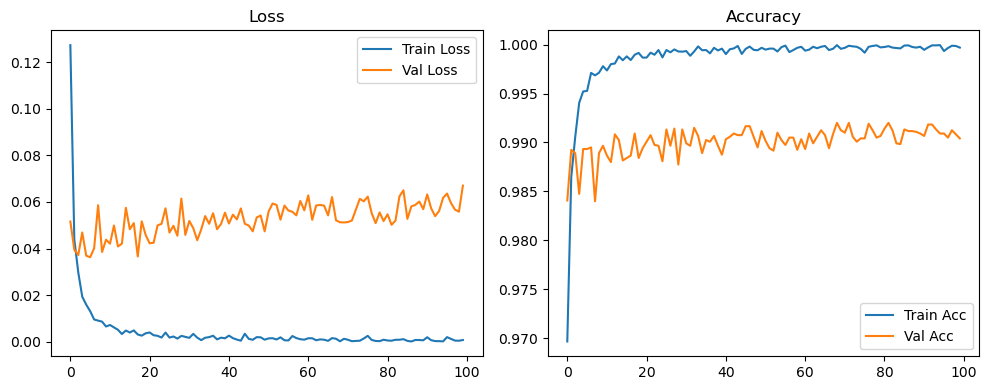

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1563, Acc: 0.9631 | Val Loss: 0.1252, Acc: 0.9585


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0634, Acc: 0.9805 | Val Loss: 0.0650, Acc: 0.9806


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.0628, Acc: 0.9811


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9867 | Val Loss: 0.0504, Acc: 0.9843


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.0522, Acc: 0.9834


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0450, Acc: 0.9858


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0500, Acc: 0.9850


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0405, Acc: 0.9872


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0359, Acc: 0.9901


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9935 | Val Loss: 0.0369, Acc: 0.9900


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.0381, Acc: 0.9887


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0414, Acc: 0.9889


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.0409, Acc: 0.9883


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0329, Acc: 0.9912


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0357, Acc: 0.9902


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0468, Acc: 0.9877


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0380, Acc: 0.9895


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0360, Acc: 0.9910


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0407, Acc: 0.9898


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0357, Acc: 0.9908


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0444, Acc: 0.9880


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9961 | Val Loss: 0.0364, Acc: 0.9912


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0398, Acc: 0.9905


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0369, Acc: 0.9911


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0478, Acc: 0.9867


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0439, Acc: 0.9897


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0426, Acc: 0.9896


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0455, Acc: 0.9898


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0363, Acc: 0.9913


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9973 | Val Loss: 0.0425, Acc: 0.9897


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.0389, Acc: 0.9898


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0396, Acc: 0.9892


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0392, Acc: 0.9897


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0386, Acc: 0.9902


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0370, Acc: 0.9892


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0426, Acc: 0.9890


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0410, Acc: 0.9904


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0382, Acc: 0.9907


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0381, Acc: 0.9908


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0425, Acc: 0.9890


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0360, Acc: 0.9904


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0376, Acc: 0.9906


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0370, Acc: 0.9915


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0354, Acc: 0.9915


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0411, Acc: 0.9898


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0358, Acc: 0.9908


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0426, Acc: 0.9904


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0368, Acc: 0.9911


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0453, Acc: 0.9898


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0321, Acc: 0.9918


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0410, Acc: 0.9895


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0401, Acc: 0.9898


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0415, Acc: 0.9899


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0421, Acc: 0.9902


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0468, Acc: 0.9892


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0362, Acc: 0.9906


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0413, Acc: 0.9897


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0399, Acc: 0.9901


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0401, Acc: 0.9897


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0376, Acc: 0.9905


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0413, Acc: 0.9894


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0373, Acc: 0.9908


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0341, Acc: 0.9913


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0420, Acc: 0.9899


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0400, Acc: 0.9899


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0389, Acc: 0.9895


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0360, Acc: 0.9912


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0415, Acc: 0.9892


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0436, Acc: 0.9887


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0358, Acc: 0.9907


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0365, Acc: 0.9905


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0368, Acc: 0.9901


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0404, Acc: 0.9895


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0351, Acc: 0.9905


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0456, Acc: 0.9894


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0380, Acc: 0.9905


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0455, Acc: 0.9900


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0362, Acc: 0.9898


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0365, Acc: 0.9903


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.0338, Acc: 0.9911


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0370, Acc: 0.9902


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0353, Acc: 0.9908


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0391, Acc: 0.9899


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0355, Acc: 0.9908


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0402, Acc: 0.9902


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0333, Acc: 0.9915


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0350, Acc: 0.9905


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0423, Acc: 0.9892


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0392, Acc: 0.9895


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0434, Acc: 0.9893


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0450, Acc: 0.9880


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0384, Acc: 0.9910


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0372, Acc: 0.9909


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0375, Acc: 0.9900


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0407, Acc: 0.9890


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0380, Acc: 0.9906


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0393, Acc: 0.9906


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0392, Acc: 0.9897


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0372, Acc: 0.9902


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0393, Acc: 0.9885


Final Test Loss: 0.0372 Accuracy: 0.9893


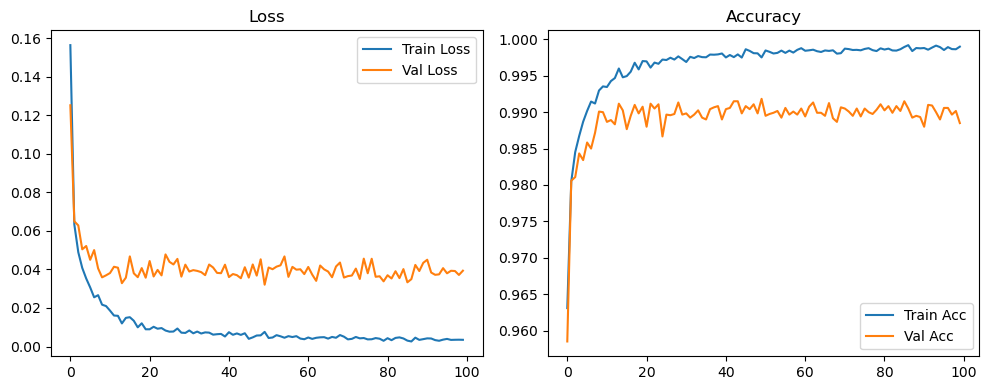

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2661, Acc: 0.9323 | Val Loss: 0.9634, Acc: 0.6348


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1267, Acc: 0.9631 | Val Loss: 0.3970, Acc: 0.8552


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1040, Acc: 0.9696 | Val Loss: 0.3590, Acc: 0.8729


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0934, Acc: 0.9721 | Val Loss: 0.1665, Acc: 0.9533


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0867, Acc: 0.9739 | Val Loss: 0.1514, Acc: 0.9576


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0800, Acc: 0.9760 | Val Loss: 0.1985, Acc: 0.9393


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9788 | Val Loss: 0.1092, Acc: 0.9713


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0732, Acc: 0.9780 | Val Loss: 0.1406, Acc: 0.9622


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9798 | Val Loss: 0.1723, Acc: 0.9516


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9806 | Val Loss: 0.1295, Acc: 0.9655


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0626, Acc: 0.9804 | Val Loss: 0.1025, Acc: 0.9724


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0590, Acc: 0.9817 | Val Loss: 0.0959, Acc: 0.9765


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9826 | Val Loss: 0.1500, Acc: 0.9543


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9822 | Val Loss: 0.1185, Acc: 0.9643


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0556, Acc: 0.9828 | Val Loss: 0.0964, Acc: 0.9756


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9841 | Val Loss: 0.1214, Acc: 0.9672


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9840 | Val Loss: 0.0959, Acc: 0.9745


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0495, Acc: 0.9847 | Val Loss: 0.1483, Acc: 0.9572


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9842 | Val Loss: 0.1083, Acc: 0.9712


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9844 | Val Loss: 0.1373, Acc: 0.9616


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9861 | Val Loss: 0.1417, Acc: 0.9618


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9852 | Val Loss: 0.1031, Acc: 0.9751


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9865 | Val Loss: 0.1024, Acc: 0.9715


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0470, Acc: 0.9857 | Val Loss: 0.1155, Acc: 0.9708


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9857 | Val Loss: 0.1279, Acc: 0.9691


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9861 | Val Loss: 0.1308, Acc: 0.9687


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0393, Acc: 0.9869 | Val Loss: 0.1112, Acc: 0.9717


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9863 | Val Loss: 0.1346, Acc: 0.9672


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9869 | Val Loss: 0.1197, Acc: 0.9698


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 0.1309, Acc: 0.9667


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1438, Acc: 0.9600


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.1458, Acc: 0.9637


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9884 | Val Loss: 0.1336, Acc: 0.9670


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.1207, Acc: 0.9748


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.1288, Acc: 0.9742


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9886 | Val Loss: 0.1392, Acc: 0.9772


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.1369, Acc: 0.9758


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9882 | Val Loss: 0.1368, Acc: 0.9745


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9874 | Val Loss: 0.1471, Acc: 0.9719


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9887 | Val Loss: 0.1617, Acc: 0.9698


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.1651, Acc: 0.9684


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9888 | Val Loss: 0.1833, Acc: 0.9601


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9884 | Val Loss: 0.1928, Acc: 0.9609


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.1928, Acc: 0.9598


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9887 | Val Loss: 0.1511, Acc: 0.9695


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.1629, Acc: 0.9724


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9893 | Val Loss: 0.1927, Acc: 0.9573


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.2064, Acc: 0.9746


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0334, Acc: 0.9898 | Val Loss: 0.1872, Acc: 0.9775


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9895 | Val Loss: 0.2313, Acc: 0.9693


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.2016, Acc: 0.9633


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9889 | Val Loss: 0.1568, Acc: 0.9711


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.2021, Acc: 0.9701


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.1798, Acc: 0.9767


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9901 | Val Loss: 0.1765, Acc: 0.9730


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9898 | Val Loss: 0.1834, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9890 | Val Loss: 0.1978, Acc: 0.9727


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.2255, Acc: 0.9656


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.2227, Acc: 0.9732


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.2171, Acc: 0.9636


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9902 | Val Loss: 0.2270, Acc: 0.9723


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.2029, Acc: 0.9709


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.1568, Acc: 0.9829


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9900 | Val Loss: 0.2024, Acc: 0.9764


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9906 | Val Loss: 0.2432, Acc: 0.9776


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.3085, Acc: 0.9657


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.2916, Acc: 0.9708


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.2945, Acc: 0.9670


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.3052, Acc: 0.9628


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.3240, Acc: 0.9597


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9908 | Val Loss: 0.2694, Acc: 0.9681


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9908 | Val Loss: 0.2540, Acc: 0.9637


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.2300, Acc: 0.9696


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9899 | Val Loss: 0.2578, Acc: 0.9630


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.2815, Acc: 0.9716


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.3079, Acc: 0.9666


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9912 | Val Loss: 0.3205, Acc: 0.9537


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.3123, Acc: 0.9600


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.2199, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9909 | Val Loss: 0.3358, Acc: 0.9665


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.3533, Acc: 0.9666


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.3237, Acc: 0.9583


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.4023, Acc: 0.9491


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.3660, Acc: 0.9673


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.4596, Acc: 0.9233


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9895 | Val Loss: 0.4068, Acc: 0.9466


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.4164, Acc: 0.9445


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.4766, Acc: 0.9325


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.4244, Acc: 0.9493


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.3346, Acc: 0.9638


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.3961, Acc: 0.9553


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.4315, Acc: 0.9607


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.4024, Acc: 0.9546


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9909 | Val Loss: 0.3731, Acc: 0.9597


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.4115, Acc: 0.9499


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.3052, Acc: 0.9608


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.3725, Acc: 0.9528


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.3817, Acc: 0.9457


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.3922, Acc: 0.9586


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.4244, Acc: 0.9546


Final Test Loss: 0.4206 Accuracy: 0.9597


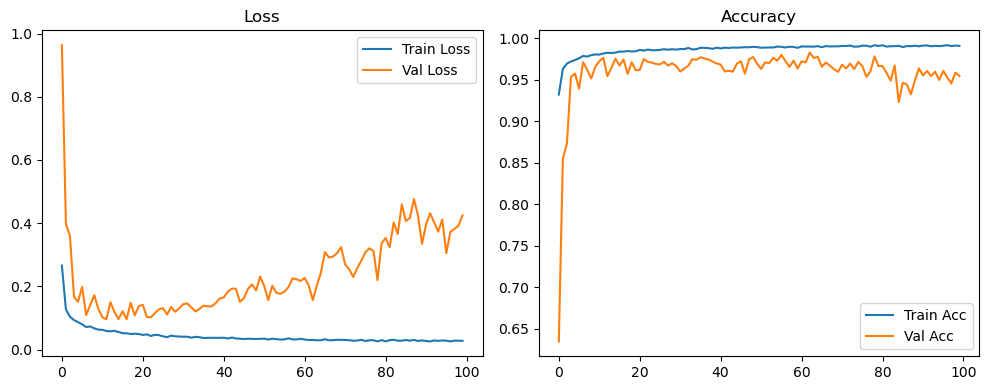

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1572, Acc: 0.9690 | Val Loss: 0.0553, Acc: 0.9844


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9867 | Val Loss: 0.0414, Acc: 0.9883


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9915 | Val Loss: 0.0398, Acc: 0.9882


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9942 | Val Loss: 0.0369, Acc: 0.9892


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9954 | Val Loss: 0.0393, Acc: 0.9880


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9964 | Val Loss: 0.0451, Acc: 0.9855


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.0390, Acc: 0.9895


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0492, Acc: 0.9855


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0432, Acc: 0.9882


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0386, Acc: 0.9901


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0466, Acc: 0.9881


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0379, Acc: 0.9886


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0385, Acc: 0.9910


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0393, Acc: 0.9899


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0498, Acc: 0.9882


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0448, Acc: 0.9899


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0489, Acc: 0.9892


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0442, Acc: 0.9892


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0473, Acc: 0.9887


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0420, Acc: 0.9901


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0429, Acc: 0.9901


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0511, Acc: 0.9877


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0455, Acc: 0.9902


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0467, Acc: 0.9892


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.0439, Acc: 0.9907


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0475, Acc: 0.9903


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0509, Acc: 0.9895


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0456, Acc: 0.9904


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0437, Acc: 0.9897


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0465, Acc: 0.9905


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0482, Acc: 0.9903


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0504, Acc: 0.9900


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0471, Acc: 0.9902


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0480, Acc: 0.9899


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0517, Acc: 0.9894


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0507, Acc: 0.9901


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0526, Acc: 0.9894


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0527, Acc: 0.9888


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0511, Acc: 0.9898


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0540, Acc: 0.9893


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0479, Acc: 0.9910


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0498, Acc: 0.9905


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0490, Acc: 0.9902


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0499, Acc: 0.9903


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0474, Acc: 0.9912


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0517, Acc: 0.9898


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0452, Acc: 0.9913


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0446, Acc: 0.9913


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0475, Acc: 0.9910


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0411, Acc: 0.9919


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0444, Acc: 0.9917


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0529, Acc: 0.9893


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0443, Acc: 0.9918


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0463, Acc: 0.9909


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0436, Acc: 0.9918


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0438, Acc: 0.9915


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0498, Acc: 0.9902


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0463, Acc: 0.9913


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0536, Acc: 0.9898


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0503, Acc: 0.9903


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0510, Acc: 0.9906


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0589, Acc: 0.9902


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0490, Acc: 0.9906


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0511, Acc: 0.9907


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0521, Acc: 0.9908


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0548, Acc: 0.9910


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0571, Acc: 0.9908


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0564, Acc: 0.9908


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0545, Acc: 0.9902


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0498, Acc: 0.9909


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9913


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0704, Acc: 0.9877


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0563, Acc: 0.9902


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0549, Acc: 0.9908


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0530, Acc: 0.9918


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0511, Acc: 0.9920


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0617, Acc: 0.9899


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0607, Acc: 0.9878


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0563, Acc: 0.9904


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0500, Acc: 0.9910


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0523, Acc: 0.9918


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9913


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0453, Acc: 0.9910


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0608, Acc: 0.9897


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0523, Acc: 0.9912


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0497, Acc: 0.9913


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9912


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0510, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0539, Acc: 0.9906


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0604, Acc: 0.9898


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0570, Acc: 0.9907


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0560, Acc: 0.9909


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0508, Acc: 0.9912


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0658, Acc: 0.9889


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0596, Acc: 0.9908


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0605, Acc: 0.9905


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0619, Acc: 0.9909


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0536, Acc: 0.9914


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0518, Acc: 0.9902


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0572, Acc: 0.9902


Final Test Loss: 0.0521 Accuracy: 0.9908


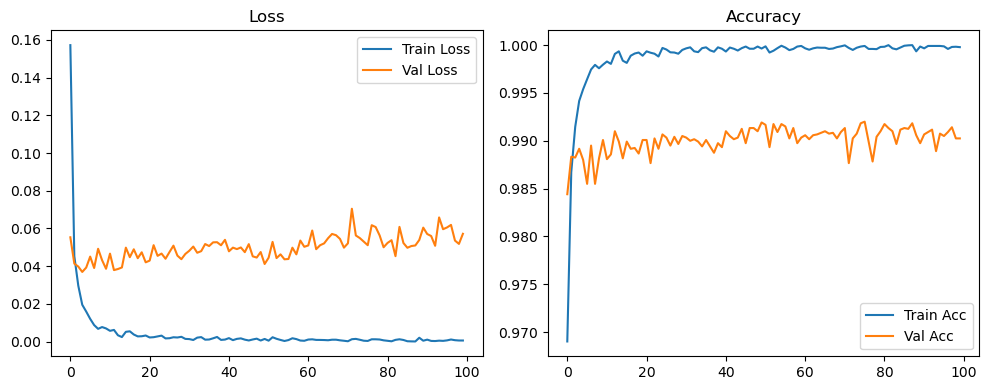

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1927, Acc: 0.9622 | Val Loss: 0.1484, Acc: 0.9563


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0661, Acc: 0.9807 | Val Loss: 0.0667, Acc: 0.9824


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9846 | Val Loss: 0.0803, Acc: 0.9740


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9868 | Val Loss: 0.0607, Acc: 0.9812


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9881 | Val Loss: 0.0574, Acc: 0.9818


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9905 | Val Loss: 0.0525, Acc: 0.9841


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0539, Acc: 0.9836


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0377, Acc: 0.9886


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0376, Acc: 0.9892


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9937 | Val Loss: 0.0456, Acc: 0.9866


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0506, Acc: 0.9855


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0388, Acc: 0.9897


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0429, Acc: 0.9884


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0419, Acc: 0.9883


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0388, Acc: 0.9891


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0449, Acc: 0.9872


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0458, Acc: 0.9873


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0400, Acc: 0.9891


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0366, Acc: 0.9899


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0396, Acc: 0.9889


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0457, Acc: 0.9881


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0383, Acc: 0.9900


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0393, Acc: 0.9894


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0357, Acc: 0.9902


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.0477, Acc: 0.9868


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9970 | Val Loss: 0.0444, Acc: 0.9871


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0413, Acc: 0.9892


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0474, Acc: 0.9886


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9973 | Val Loss: 0.0379, Acc: 0.9902


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0385, Acc: 0.9886


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0380, Acc: 0.9903


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0435, Acc: 0.9898


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0404, Acc: 0.9891


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.0342, Acc: 0.9914


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0373, Acc: 0.9898


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0395, Acc: 0.9895


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.0429, Acc: 0.9896


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0406, Acc: 0.9898


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0411, Acc: 0.9899


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0343, Acc: 0.9912


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0435, Acc: 0.9891


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0373, Acc: 0.9904


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0368, Acc: 0.9908


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0364, Acc: 0.9911


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0396, Acc: 0.9902


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0389, Acc: 0.9898


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0425, Acc: 0.9891


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0386, Acc: 0.9902


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0383, Acc: 0.9907


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0368, Acc: 0.9908


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0374, Acc: 0.9898


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0406, Acc: 0.9904


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0376, Acc: 0.9907


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0350, Acc: 0.9914


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0461, Acc: 0.9882


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0391, Acc: 0.9903


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0421, Acc: 0.9898


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0417, Acc: 0.9896


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0409, Acc: 0.9897


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0403, Acc: 0.9901


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0407, Acc: 0.9900


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0417, Acc: 0.9898


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0345, Acc: 0.9913


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0386, Acc: 0.9908


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0383, Acc: 0.9896


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0361, Acc: 0.9913


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0406, Acc: 0.9892


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0484, Acc: 0.9879


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0419, Acc: 0.9887


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0400, Acc: 0.9901


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0369, Acc: 0.9914


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0442, Acc: 0.9888


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0417, Acc: 0.9889


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0403, Acc: 0.9905


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0419, Acc: 0.9898


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0395, Acc: 0.9898


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9985 | Val Loss: 0.0430, Acc: 0.9892


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0404, Acc: 0.9902


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0437, Acc: 0.9888


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0385, Acc: 0.9902


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0402, Acc: 0.9901


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0410, Acc: 0.9899


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0407, Acc: 0.9903


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0422, Acc: 0.9900


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0448, Acc: 0.9893


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0431, Acc: 0.9892


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0376, Acc: 0.9907


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0502, Acc: 0.9875


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0434, Acc: 0.9893


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0447, Acc: 0.9892


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0510, Acc: 0.9873


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0442, Acc: 0.9894


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0403, Acc: 0.9915


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0423, Acc: 0.9905


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0437, Acc: 0.9900


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0443, Acc: 0.9892


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0392, Acc: 0.9908


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0448, Acc: 0.9898


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0406, Acc: 0.9903


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0391, Acc: 0.9912


Final Test Loss: 0.0328 Accuracy: 0.9895


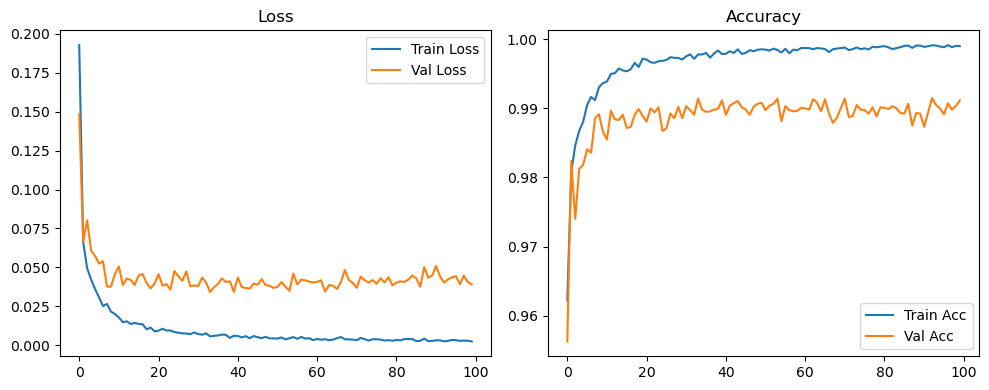

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3210, Acc: 0.9281 | Val Loss: 1.4003, Acc: 0.4768


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1328, Acc: 0.9631 | Val Loss: 0.8338, Acc: 0.6831


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1101, Acc: 0.9681 | Val Loss: 0.6073, Acc: 0.7746


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0946, Acc: 0.9716 | Val Loss: 0.3385, Acc: 0.8791


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0885, Acc: 0.9735 | Val Loss: 0.2871, Acc: 0.9008


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0851, Acc: 0.9744 | Val Loss: 0.2019, Acc: 0.9364


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0754, Acc: 0.9774 | Val Loss: 0.1283, Acc: 0.9669


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0762, Acc: 0.9775 | Val Loss: 0.1363, Acc: 0.9635


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0691, Acc: 0.9795 | Val Loss: 0.1360, Acc: 0.9631


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0654, Acc: 0.9798 | Val Loss: 0.1518, Acc: 0.9536


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0634, Acc: 0.9807 | Val Loss: 0.1123, Acc: 0.9690


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0607, Acc: 0.9814 | Val Loss: 0.0953, Acc: 0.9763


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0597, Acc: 0.9817 | Val Loss: 0.1274, Acc: 0.9627


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0578, Acc: 0.9824 | Val Loss: 0.1020, Acc: 0.9713


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9827 | Val Loss: 0.0866, Acc: 0.9775


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0535, Acc: 0.9827 | Val Loss: 0.1145, Acc: 0.9654


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0542, Acc: 0.9826 | Val Loss: 0.1054, Acc: 0.9703


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9839 | Val Loss: 0.1189, Acc: 0.9659


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9842 | Val Loss: 0.1042, Acc: 0.9704


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0469, Acc: 0.9858 | Val Loss: 0.1723, Acc: 0.9444


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9850 | Val Loss: 0.1171, Acc: 0.9673


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9851 | Val Loss: 0.1106, Acc: 0.9686


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0453, Acc: 0.9857 | Val Loss: 0.0882, Acc: 0.9777


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9850 | Val Loss: 0.0948, Acc: 0.9749


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9861 | Val Loss: 0.1292, Acc: 0.9624


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9853 | Val Loss: 0.1034, Acc: 0.9724


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9873 | Val Loss: 0.1132, Acc: 0.9683


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9861 | Val Loss: 0.1292, Acc: 0.9647


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9871 | Val Loss: 0.1010, Acc: 0.9773


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.0958, Acc: 0.9765


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.1222, Acc: 0.9696


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9879 | Val Loss: 0.1294, Acc: 0.9704


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.1196, Acc: 0.9734


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9880 | Val Loss: 0.0975, Acc: 0.9794


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.0987, Acc: 0.9791


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9886 | Val Loss: 0.1086, Acc: 0.9778


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9890 | Val Loss: 0.1035, Acc: 0.9819


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9884 | Val Loss: 0.1055, Acc: 0.9771


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9879 | Val Loss: 0.1093, Acc: 0.9805


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9889 | Val Loss: 0.1170, Acc: 0.9783


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9880 | Val Loss: 0.1234, Acc: 0.9778


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9886 | Val Loss: 0.1242, Acc: 0.9756


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0372, Acc: 0.9885 | Val Loss: 0.1347, Acc: 0.9782


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9900 | Val Loss: 0.1359, Acc: 0.9759


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9892 | Val Loss: 0.1322, Acc: 0.9754


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9896 | Val Loss: 0.1164, Acc: 0.9821


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9892 | Val Loss: 0.1555, Acc: 0.9676


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.1309, Acc: 0.9784


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9897 | Val Loss: 0.1391, Acc: 0.9744


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.1348, Acc: 0.9817


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9892 | Val Loss: 0.1461, Acc: 0.9730


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.1345, Acc: 0.9785


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9897 | Val Loss: 0.1608, Acc: 0.9785


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9899 | Val Loss: 0.1360, Acc: 0.9798


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9903 | Val Loss: 0.1577, Acc: 0.9779


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.1580, Acc: 0.9812


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9894 | Val Loss: 0.1536, Acc: 0.9764


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.1527, Acc: 0.9768


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.1716, Acc: 0.9738


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.1726, Acc: 0.9728


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.2293, Acc: 0.9610


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.1811, Acc: 0.9750


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.1766, Acc: 0.9809


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9905 | Val Loss: 0.1598, Acc: 0.9753


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.1700, Acc: 0.9779


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9902 | Val Loss: 0.2021, Acc: 0.9766


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.2077, Acc: 0.9757


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.2066, Acc: 0.9787


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.1662, Acc: 0.9808


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.2017, Acc: 0.9747


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9912 | Val Loss: 0.2195, Acc: 0.9802


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.2472, Acc: 0.9708


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.2142, Acc: 0.9682


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.2122, Acc: 0.9707


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9913 | Val Loss: 0.2239, Acc: 0.9700


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9915 | Val Loss: 0.2433, Acc: 0.9654


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.2162, Acc: 0.9672


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.2177, Acc: 0.9719


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.2171, Acc: 0.9730


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.2152, Acc: 0.9742


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.2547, Acc: 0.9720


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.2147, Acc: 0.9733


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.2070, Acc: 0.9730


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.2243, Acc: 0.9688


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.2577, Acc: 0.9606


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9906 | Val Loss: 0.2566, Acc: 0.9668


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.2393, Acc: 0.9755


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.2374, Acc: 0.9637


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.2862, Acc: 0.9698


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.3117, Acc: 0.9617


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.3297, Acc: 0.9560


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.3249, Acc: 0.9625


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.3469, Acc: 0.9641


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.2610, Acc: 0.9671


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.3308, Acc: 0.9574


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.3111, Acc: 0.9602


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.3963, Acc: 0.9627


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.4192, Acc: 0.9557


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.4038, Acc: 0.9604


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9913 | Val Loss: 0.4155, Acc: 0.9582


Final Test Loss: 0.4128 Accuracy: 0.9599


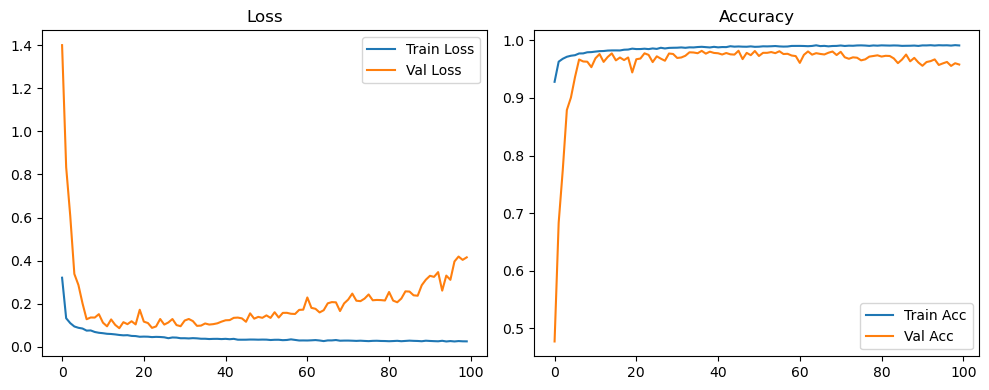

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1187, Acc: 0.9654 | Val Loss: 0.0593, Acc: 0.9827


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9862 | Val Loss: 0.0377, Acc: 0.9882


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0497, Acc: 0.9842


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.0472, Acc: 0.9854


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0458, Acc: 0.9869


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0420, Acc: 0.9881


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0392, Acc: 0.9896


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0493, Acc: 0.9869


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0373, Acc: 0.9907


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0436, Acc: 0.9888


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.0619, Acc: 0.9864


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.0529, Acc: 0.9874


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0530, Acc: 0.9889


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0454, Acc: 0.9902


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0466, Acc: 0.9894


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9972 | Val Loss: 0.0574, Acc: 0.9877


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0503, Acc: 0.9888


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0503, Acc: 0.9882


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0605, Acc: 0.9872


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0477, Acc: 0.9893


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0475, Acc: 0.9902


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0700, Acc: 0.9853


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0549, Acc: 0.9886


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0568, Acc: 0.9878


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0570, Acc: 0.9900


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0630, Acc: 0.9892


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0597, Acc: 0.9890


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0535, Acc: 0.9901


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0547, Acc: 0.9891


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0670, Acc: 0.9880


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0582, Acc: 0.9903


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0576, Acc: 0.9906


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0629, Acc: 0.9892


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0574, Acc: 0.9902


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0606, Acc: 0.9898


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0619, Acc: 0.9900


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0623, Acc: 0.9890


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0662, Acc: 0.9898


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0510, Acc: 0.9911


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0759, Acc: 0.9884


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0721, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0554, Acc: 0.9907


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0663, Acc: 0.9892


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0648, Acc: 0.9896


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0580, Acc: 0.9911


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0622, Acc: 0.9914


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0611, Acc: 0.9911


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0662, Acc: 0.9900


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0718, Acc: 0.9898


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0641, Acc: 0.9914


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0600, Acc: 0.9908


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0770, Acc: 0.9896


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0607, Acc: 0.9914


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0632, Acc: 0.9909


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0600, Acc: 0.9913


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0745, Acc: 0.9900


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0683, Acc: 0.9910


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0637, Acc: 0.9913


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0630, Acc: 0.9905


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0645, Acc: 0.9902


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0722, Acc: 0.9902


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0666, Acc: 0.9906


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0891, Acc: 0.9888


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0713, Acc: 0.9898


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0755, Acc: 0.9906


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0689, Acc: 0.9905


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0687, Acc: 0.9914


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0633, Acc: 0.9905


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0701, Acc: 0.9910


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0750, Acc: 0.9904


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9993 | Val Loss: 0.0767, Acc: 0.9892


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0777, Acc: 0.9889


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0765, Acc: 0.9898


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0950, Acc: 0.9878


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0770, Acc: 0.9903


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0783, Acc: 0.9909


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0770, Acc: 0.9908


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0719, Acc: 0.9913


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0824, Acc: 0.9901


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0755, Acc: 0.9908


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0799, Acc: 0.9907


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0766, Acc: 0.9913


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0837, Acc: 0.9905


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0785, Acc: 0.9912


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0856, Acc: 0.9899


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0859, Acc: 0.9902


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0947, Acc: 0.9898


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0814, Acc: 0.9906


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1040, Acc: 0.9886


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0892, Acc: 0.9891


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0804, Acc: 0.9902


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0784, Acc: 0.9904


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0859, Acc: 0.9906


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1000, Acc: 0.9882


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.0851, Acc: 0.9902


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0775, Acc: 0.9905


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.0814, Acc: 0.9908


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0959, Acc: 0.9901


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0859, Acc: 0.9899


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1081, Acc: 0.9897


Final Test Loss: 0.1114 Accuracy: 0.9890


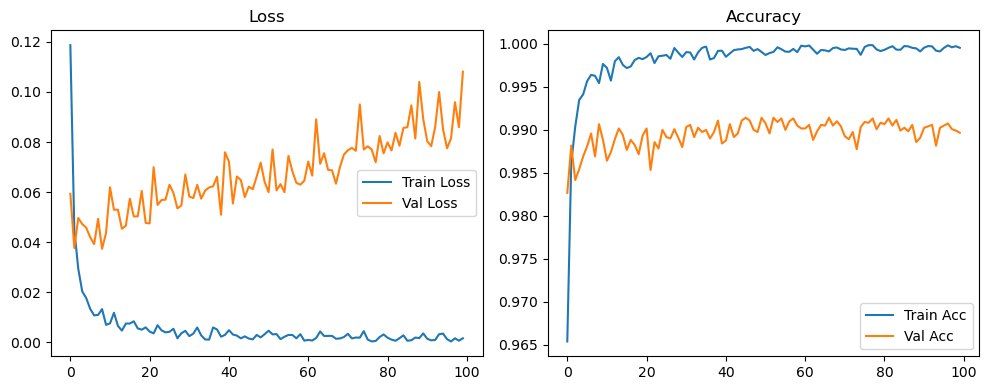

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1471, Acc: 0.9576 | Val Loss: 0.1470, Acc: 0.9533


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0648, Acc: 0.9799 | Val Loss: 0.0550, Acc: 0.9830


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9841 | Val Loss: 0.0597, Acc: 0.9829


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9872 | Val Loss: 0.0580, Acc: 0.9823


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.0519, Acc: 0.9848


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.0562, Acc: 0.9828


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.0741, Acc: 0.9786


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9914 | Val Loss: 0.0407, Acc: 0.9878


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0389, Acc: 0.9882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0506, Acc: 0.9850


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0492, Acc: 0.9860


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0463, Acc: 0.9868


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0779, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0411, Acc: 0.9888


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0506, Acc: 0.9862


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0484, Acc: 0.9864


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.0562, Acc: 0.9856


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0479, Acc: 0.9868


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0424, Acc: 0.9883


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0457, Acc: 0.9874


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.0487, Acc: 0.9868


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0517, Acc: 0.9862


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.0453, Acc: 0.9892


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0441, Acc: 0.9880


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0490, Acc: 0.9865


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0381, Acc: 0.9900


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0534, Acc: 0.9849


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0454, Acc: 0.9878


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0534, Acc: 0.9863


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0437, Acc: 0.9891


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0454, Acc: 0.9886


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0497, Acc: 0.9868


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.0527, Acc: 0.9869


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0541, Acc: 0.9861


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0558, Acc: 0.9858


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0444, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0462, Acc: 0.9881


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0585, Acc: 0.9862


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0476, Acc: 0.9883


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0501, Acc: 0.9870


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0490, Acc: 0.9882


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0471, Acc: 0.9889


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0495, Acc: 0.9882


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0531, Acc: 0.9870


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0557, Acc: 0.9870


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0580, Acc: 0.9882


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0540, Acc: 0.9884


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0570, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0532, Acc: 0.9875


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0681, Acc: 0.9847


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0569, Acc: 0.9851


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0580, Acc: 0.9862


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.0614, Acc: 0.9858


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0506, Acc: 0.9877


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0551, Acc: 0.9868


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0492, Acc: 0.9889


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0523, Acc: 0.9880


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0460, Acc: 0.9900


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0506, Acc: 0.9892


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0454, Acc: 0.9898


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0552, Acc: 0.9866


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9973 | Val Loss: 0.0433, Acc: 0.9894


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0478, Acc: 0.9888


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0549, Acc: 0.9874


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0504, Acc: 0.9876


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0518, Acc: 0.9872


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0505, Acc: 0.9878


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0431, Acc: 0.9895


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0426, Acc: 0.9896


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0505, Acc: 0.9880


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0475, Acc: 0.9886


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0525, Acc: 0.9883


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0555, Acc: 0.9876


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0461, Acc: 0.9886


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0531, Acc: 0.9878


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0456, Acc: 0.9892


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0391, Acc: 0.9898


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0485, Acc: 0.9879


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0490, Acc: 0.9893


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0544, Acc: 0.9862


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0394, Acc: 0.9902


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0549, Acc: 0.9874


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0501, Acc: 0.9888


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0512, Acc: 0.9892


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0568, Acc: 0.9867


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0689, Acc: 0.9834


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0509, Acc: 0.9868


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0454, Acc: 0.9883


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0560, Acc: 0.9867


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0515, Acc: 0.9879


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0547, Acc: 0.9886


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0553, Acc: 0.9879


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0451, Acc: 0.9894


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0506, Acc: 0.9872


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0503, Acc: 0.9880


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0531, Acc: 0.9869


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0523, Acc: 0.9878


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0584, Acc: 0.9855


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0529, Acc: 0.9873


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0454, Acc: 0.9881


Final Test Loss: 0.0526 Accuracy: 0.9875


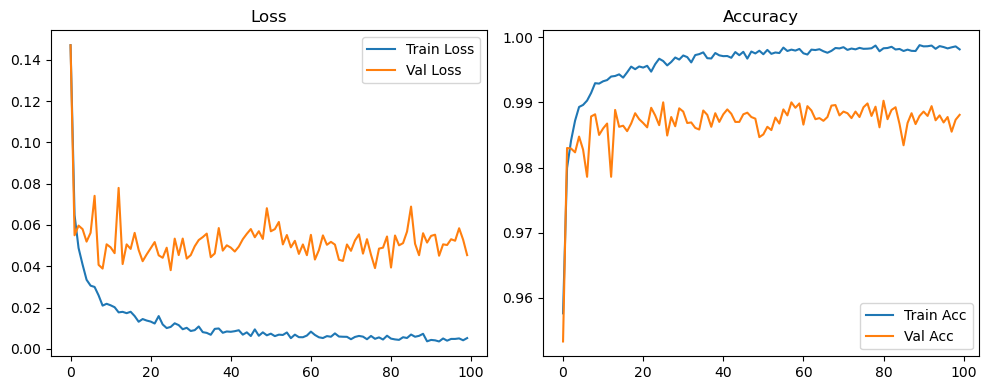

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2426, Acc: 0.9301 | Val Loss: 0.9910, Acc: 0.6232


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1260, Acc: 0.9631 | Val Loss: 0.3525, Acc: 0.8842


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9693 | Val Loss: 0.2526, Acc: 0.9198


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0976, Acc: 0.9706 | Val Loss: 0.2960, Acc: 0.9019


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0836, Acc: 0.9746 | Val Loss: 0.2461, Acc: 0.9170


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9743 | Val Loss: 0.1971, Acc: 0.9396


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9763 | Val Loss: 0.1708, Acc: 0.9473


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0750, Acc: 0.9772 | Val Loss: 0.1908, Acc: 0.9422


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9784 | Val Loss: 0.1353, Acc: 0.9631


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0670, Acc: 0.9790 | Val Loss: 0.1529, Acc: 0.9523


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9800 | Val Loss: 0.1297, Acc: 0.9607


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9799 | Val Loss: 0.1210, Acc: 0.9672


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.1642, Acc: 0.9479


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0594, Acc: 0.9821 | Val Loss: 0.1060, Acc: 0.9685


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0590, Acc: 0.9819 | Val Loss: 0.1368, Acc: 0.9583


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.0863, Acc: 0.9781


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0568, Acc: 0.9825 | Val Loss: 0.1411, Acc: 0.9543


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9830 | Val Loss: 0.1177, Acc: 0.9665


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9829 | Val Loss: 0.1451, Acc: 0.9563


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9835 | Val Loss: 0.1738, Acc: 0.9448


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0506, Acc: 0.9837 | Val Loss: 0.1299, Acc: 0.9613


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9846 | Val Loss: 0.0936, Acc: 0.9764


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9836 | Val Loss: 0.0830, Acc: 0.9785


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9851 | Val Loss: 0.1368, Acc: 0.9557


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9855 | Val Loss: 0.0974, Acc: 0.9710


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9848 | Val Loss: 0.0877, Acc: 0.9762


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9853 | Val Loss: 0.1112, Acc: 0.9669


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9849 | Val Loss: 0.1075, Acc: 0.9737


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9847 | Val Loss: 0.1264, Acc: 0.9656


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9852 | Val Loss: 0.1075, Acc: 0.9679


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9859 | Val Loss: 0.0937, Acc: 0.9753


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9861 | Val Loss: 0.0893, Acc: 0.9744


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9859 | Val Loss: 0.1014, Acc: 0.9708


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9862 | Val Loss: 0.1046, Acc: 0.9677


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.0829, Acc: 0.9768


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9863 | Val Loss: 0.0886, Acc: 0.9751


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9864 | Val Loss: 0.0771, Acc: 0.9834


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9866 | Val Loss: 0.0795, Acc: 0.9826


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9876 | Val Loss: 0.0745, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.0970, Acc: 0.9757


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.0736, Acc: 0.9815


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.0909, Acc: 0.9782


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9882 | Val Loss: 0.1029, Acc: 0.9700


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9875 | Val Loss: 0.1124, Acc: 0.9682


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9872 | Val Loss: 0.0869, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9867 | Val Loss: 0.0817, Acc: 0.9797


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9882 | Val Loss: 0.0937, Acc: 0.9792


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9893 | Val Loss: 0.0646, Acc: 0.9840


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9887 | Val Loss: 0.1067, Acc: 0.9707


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9884 | Val Loss: 0.0903, Acc: 0.9800


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9880 | Val Loss: 0.0944, Acc: 0.9764


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9892 | Val Loss: 0.0896, Acc: 0.9816


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.1261, Acc: 0.9630


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9890 | Val Loss: 0.1075, Acc: 0.9752


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9886 | Val Loss: 0.0715, Acc: 0.9817


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9890 | Val Loss: 0.1020, Acc: 0.9748


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.1042, Acc: 0.9769


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9895 | Val Loss: 0.0904, Acc: 0.9842


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9892 | Val Loss: 0.1201, Acc: 0.9708


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 0.1026, Acc: 0.9807


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9890 | Val Loss: 0.1187, Acc: 0.9824


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9895 | Val Loss: 0.1220, Acc: 0.9772


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0997, Acc: 0.9762


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9891 | Val Loss: 0.1256, Acc: 0.9768


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9888 | Val Loss: 0.1009, Acc: 0.9784


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.1090, Acc: 0.9748


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.0813, Acc: 0.9883


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.1067, Acc: 0.9798


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.1220, Acc: 0.9747


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0939, Acc: 0.9831


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.1038, Acc: 0.9842


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9900 | Val Loss: 0.1081, Acc: 0.9815


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9896 | Val Loss: 0.0927, Acc: 0.9792


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.1243, Acc: 0.9840


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.0906, Acc: 0.9843


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9900 | Val Loss: 0.0959, Acc: 0.9856


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.1291, Acc: 0.9801


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0884, Acc: 0.9825


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9905 | Val Loss: 0.1011, Acc: 0.9814


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.1213, Acc: 0.9823


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9901 | Val Loss: 0.1303, Acc: 0.9767


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.1309, Acc: 0.9798


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9904 | Val Loss: 0.1273, Acc: 0.9703


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.1116, Acc: 0.9785


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9903 | Val Loss: 0.1745, Acc: 0.9727


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.1750, Acc: 0.9742


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.1310, Acc: 0.9773


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9900 | Val Loss: 0.1020, Acc: 0.9801


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.1459, Acc: 0.9788


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9904 | Val Loss: 0.1544, Acc: 0.9788


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.1300, Acc: 0.9800


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.1570, Acc: 0.9728


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9907 | Val Loss: 0.1783, Acc: 0.9738


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.2292, Acc: 0.9688


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.1179, Acc: 0.9806


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.1545, Acc: 0.9809


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0291, Acc: 0.9907 | Val Loss: 0.1698, Acc: 0.9772


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.1305, Acc: 0.9771


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.1696, Acc: 0.9756


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1122, Acc: 0.9802


Final Test Loss: 0.1044 Accuracy: 0.9798


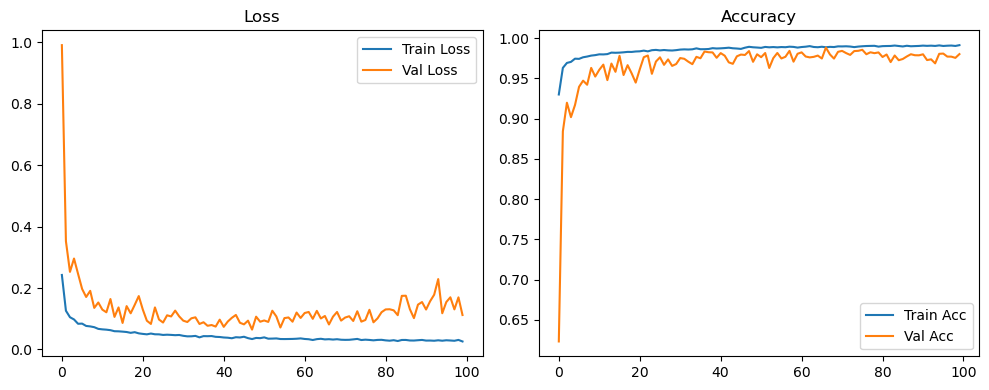

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9654 | Val Loss: 0.0614, Acc: 0.9812


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9855 | Val Loss: 0.0380, Acc: 0.9885


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9904 | Val Loss: 0.0597, Acc: 0.9827


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9928 | Val Loss: 0.0526, Acc: 0.9838


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0434, Acc: 0.9877


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0383, Acc: 0.9896


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0477, Acc: 0.9880


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.0723, Acc: 0.9815


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0459, Acc: 0.9882


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0470, Acc: 0.9895


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0470, Acc: 0.9882


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0558, Acc: 0.9885


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0392, Acc: 0.9916


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0434, Acc: 0.9914


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0623, Acc: 0.9868


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0555, Acc: 0.9875


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0514, Acc: 0.9883


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0571, Acc: 0.9884


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0534, Acc: 0.9889


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0545, Acc: 0.9888


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0960, Acc: 0.9823


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0698, Acc: 0.9871


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.0510, Acc: 0.9897


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0471, Acc: 0.9908


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0468, Acc: 0.9914


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0649, Acc: 0.9877


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0687, Acc: 0.9868


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0681, Acc: 0.9868


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0641, Acc: 0.9888


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0617, Acc: 0.9895


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0568, Acc: 0.9899


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0554, Acc: 0.9903


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0680, Acc: 0.9888


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0553, Acc: 0.9901


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0573, Acc: 0.9907


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0656, Acc: 0.9887


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0691, Acc: 0.9880


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0658, Acc: 0.9882


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0552, Acc: 0.9909


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0546, Acc: 0.9910


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0678, Acc: 0.9888


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0677, Acc: 0.9904


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0680, Acc: 0.9883


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0762, Acc: 0.9888


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0589, Acc: 0.9904


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0615, Acc: 0.9905


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0531, Acc: 0.9913


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0745, Acc: 0.9878


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0679, Acc: 0.9898


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0714, Acc: 0.9890


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0554, Acc: 0.9908


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0563, Acc: 0.9924


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9920


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0574, Acc: 0.9915


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0551, Acc: 0.9920


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0601, Acc: 0.9916


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0586, Acc: 0.9922


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9922


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9922


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0597, Acc: 0.9921


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0600, Acc: 0.9918


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0616, Acc: 0.9913


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0692, Acc: 0.9905


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0719, Acc: 0.9901


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0627, Acc: 0.9912


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0588, Acc: 0.9922


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0584, Acc: 0.9922


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0687, Acc: 0.9916


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0635, Acc: 0.9917


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0684, Acc: 0.9912


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0682, Acc: 0.9907


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0663, Acc: 0.9918


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0648, Acc: 0.9916


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9920


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0747, Acc: 0.9915


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0720, Acc: 0.9917


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0683, Acc: 0.9913


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0696, Acc: 0.9913


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0704, Acc: 0.9909


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0702, Acc: 0.9917


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0659, Acc: 0.9918


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0624, Acc: 0.9925


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0628, Acc: 0.9917


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0640, Acc: 0.9919


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9918


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9920


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0618, Acc: 0.9925


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0626, Acc: 0.9926


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9922


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0650, Acc: 0.9922


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0664, Acc: 0.9916


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9921


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9919


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9920


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0638, Acc: 0.9919


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0662, Acc: 0.9917


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0654, Acc: 0.9921


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0647, Acc: 0.9919


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0630, Acc: 0.9922


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9920


Final Test Loss: 0.0654 Accuracy: 0.9917


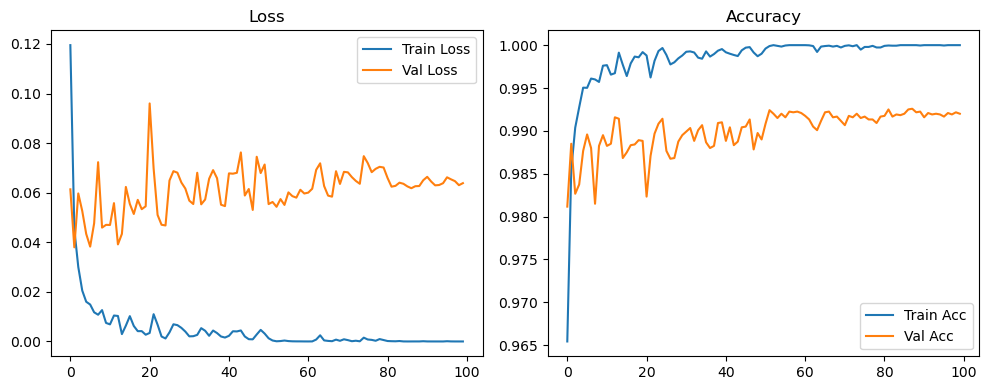

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1479, Acc: 0.9573 | Val Loss: 0.2028, Acc: 0.9360


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9796 | Val Loss: 0.0539, Acc: 0.9845


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9848 | Val Loss: 0.0675, Acc: 0.9796


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9865 | Val Loss: 0.0549, Acc: 0.9838


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.0584, Acc: 0.9817


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.0527, Acc: 0.9842


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.0752, Acc: 0.9780


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0516, Acc: 0.9836


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0440, Acc: 0.9869


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.0557, Acc: 0.9843


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0550, Acc: 0.9845


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.0511, Acc: 0.9861


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9936 | Val Loss: 0.0520, Acc: 0.9844


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0519, Acc: 0.9850


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0570, Acc: 0.9847


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0536, Acc: 0.9844


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0638, Acc: 0.9827


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0457, Acc: 0.9884


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0463, Acc: 0.9878


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0460, Acc: 0.9887


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0562, Acc: 0.9853


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0387, Acc: 0.9877


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0464, Acc: 0.9873


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0562, Acc: 0.9849


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9956 | Val Loss: 0.0499, Acc: 0.9864


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0575, Acc: 0.9851


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0532, Acc: 0.9862


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0514, Acc: 0.9866


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.0482, Acc: 0.9873


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0565, Acc: 0.9865


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0468, Acc: 0.9879


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0624, Acc: 0.9858


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0579, Acc: 0.9858


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0423, Acc: 0.9893


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0474, Acc: 0.9885


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0683, Acc: 0.9841


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.0465, Acc: 0.9869


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0472, Acc: 0.9884


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0543, Acc: 0.9871


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0506, Acc: 0.9887


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0446, Acc: 0.9882


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0567, Acc: 0.9862


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0730, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0667, Acc: 0.9843


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0590, Acc: 0.9865


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0578, Acc: 0.9855


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0630, Acc: 0.9855


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0473, Acc: 0.9886


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0487, Acc: 0.9876


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0595, Acc: 0.9862


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0511, Acc: 0.9877


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0649, Acc: 0.9850


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0540, Acc: 0.9873


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0541, Acc: 0.9882


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0597, Acc: 0.9872


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0473, Acc: 0.9888


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0602, Acc: 0.9873


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0582, Acc: 0.9878


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0505, Acc: 0.9897


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0548, Acc: 0.9886


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0536, Acc: 0.9881


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0576, Acc: 0.9875


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0578, Acc: 0.9888


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0558, Acc: 0.9890


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0559, Acc: 0.9891


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0497, Acc: 0.9902


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0499, Acc: 0.9886


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0511, Acc: 0.9892


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0519, Acc: 0.9898


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0500, Acc: 0.9886


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0498, Acc: 0.9892


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0503, Acc: 0.9894


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.0568, Acc: 0.9878


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0513, Acc: 0.9881


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0513, Acc: 0.9888


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0518, Acc: 0.9893


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0532, Acc: 0.9883


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0434, Acc: 0.9901


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0453, Acc: 0.9896


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0488, Acc: 0.9895


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0456, Acc: 0.9898


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0411, Acc: 0.9911


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0442, Acc: 0.9910


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0457, Acc: 0.9902


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0483, Acc: 0.9894


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0465, Acc: 0.9898


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0485, Acc: 0.9898


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0485, Acc: 0.9902


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0494, Acc: 0.9901


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0441, Acc: 0.9905


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0482, Acc: 0.9903


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0447, Acc: 0.9904


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0515, Acc: 0.9894


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0481, Acc: 0.9892


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0492, Acc: 0.9904


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0488, Acc: 0.9895


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0525, Acc: 0.9895


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0486, Acc: 0.9898


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0492, Acc: 0.9897


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0493, Acc: 0.9901


Final Test Loss: 0.0423 Accuracy: 0.9902


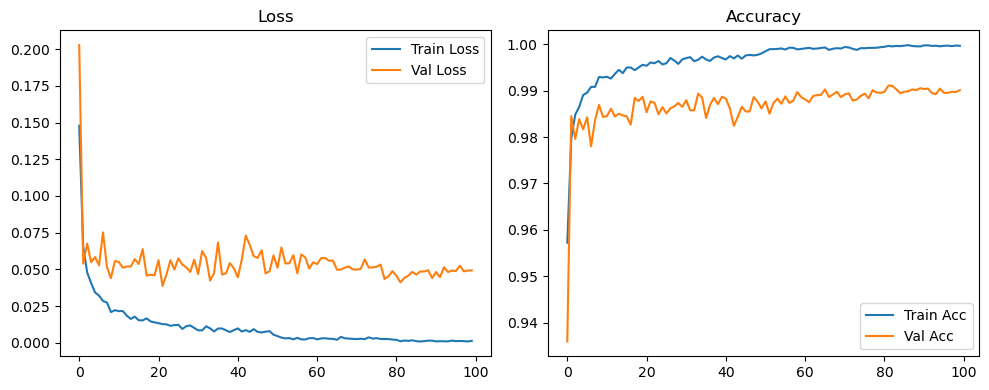

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2426, Acc: 0.9300 | Val Loss: 0.8199, Acc: 0.6840


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1254, Acc: 0.9637 | Val Loss: 0.4764, Acc: 0.8363


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1055, Acc: 0.9690 | Val Loss: 0.3376, Acc: 0.8832


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9713 | Val Loss: 0.3491, Acc: 0.8743


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9744 | Val Loss: 0.2810, Acc: 0.9042


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9752 | Val Loss: 0.2721, Acc: 0.9097


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9774 | Val Loss: 0.1439, Acc: 0.9592


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0744, Acc: 0.9772 | Val Loss: 0.2671, Acc: 0.9103


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9790 | Val Loss: 0.1123, Acc: 0.9694


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0657, Acc: 0.9799 | Val Loss: 0.1861, Acc: 0.9414


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9798 | Val Loss: 0.1230, Acc: 0.9660


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0649, Acc: 0.9798 | Val Loss: 0.1038, Acc: 0.9731


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9803 | Val Loss: 0.1513, Acc: 0.9550


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9813 | Val Loss: 0.1174, Acc: 0.9664


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9817 | Val Loss: 0.1432, Acc: 0.9592


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9812 | Val Loss: 0.1062, Acc: 0.9711


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9830 | Val Loss: 0.1066, Acc: 0.9694


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9834 | Val Loss: 0.1159, Acc: 0.9635


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9833 | Val Loss: 0.1017, Acc: 0.9702


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9836 | Val Loss: 0.1336, Acc: 0.9593


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 0.1064, Acc: 0.9698


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9843 | Val Loss: 0.1005, Acc: 0.9701


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9844 | Val Loss: 0.0725, Acc: 0.9821


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9851 | Val Loss: 0.0849, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9841 | Val Loss: 0.1027, Acc: 0.9701


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9848 | Val Loss: 0.0785, Acc: 0.9792


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0464, Acc: 0.9856 | Val Loss: 0.0962, Acc: 0.9733


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.1423, Acc: 0.9584


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9852 | Val Loss: 0.1059, Acc: 0.9699


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9852 | Val Loss: 0.0972, Acc: 0.9718


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 0.1048, Acc: 0.9686


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.0957, Acc: 0.9717


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9864 | Val Loss: 0.0889, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9859 | Val Loss: 0.0981, Acc: 0.9718


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9863 | Val Loss: 0.0822, Acc: 0.9812


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9871 | Val Loss: 0.0888, Acc: 0.9759


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9862 | Val Loss: 0.1006, Acc: 0.9741


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9869 | Val Loss: 0.1287, Acc: 0.9653


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.0811, Acc: 0.9792


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0923, Acc: 0.9776


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.0974, Acc: 0.9755


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9872 | Val Loss: 0.1170, Acc: 0.9680


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 0.1034, Acc: 0.9724


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.1034, Acc: 0.9732


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.0751, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9882 | Val Loss: 0.0791, Acc: 0.9778


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9873 | Val Loss: 0.0850, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9889 | Val Loss: 0.0707, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9888 | Val Loss: 0.0851, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9883 | Val Loss: 0.1003, Acc: 0.9748


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9886 | Val Loss: 0.0862, Acc: 0.9826


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.0891, Acc: 0.9799


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0746, Acc: 0.9840


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.0741, Acc: 0.9864


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0766, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0777, Acc: 0.9838


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.0801, Acc: 0.9833


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0748, Acc: 0.9849


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9917 | Val Loss: 0.0827, Acc: 0.9823


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.0698, Acc: 0.9871


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9915 | Val Loss: 0.0773, Acc: 0.9846


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9916 | Val Loss: 0.0830, Acc: 0.9847


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0829, Acc: 0.9847


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.0850, Acc: 0.9841


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0850, Acc: 0.9813


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0850, Acc: 0.9809


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9914 | Val Loss: 0.0726, Acc: 0.9856


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0779, Acc: 0.9826


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.0846, Acc: 0.9838


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.0850, Acc: 0.9818


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.0703, Acc: 0.9877


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.0839, Acc: 0.9834


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.1002, Acc: 0.9796


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0759, Acc: 0.9862


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0786, Acc: 0.9858


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0893, Acc: 0.9839


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0938, Acc: 0.9830


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.0764, Acc: 0.9825


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0958, Acc: 0.9827


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.0902, Acc: 0.9816


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.0960, Acc: 0.9818


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.0875, Acc: 0.9832


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0905, Acc: 0.9838


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9934 | Val Loss: 0.0909, Acc: 0.9843


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0908, Acc: 0.9831


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0977, Acc: 0.9831


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9935 | Val Loss: 0.0936, Acc: 0.9831


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9942 | Val Loss: 0.0905, Acc: 0.9828


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0901, Acc: 0.9853


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0874, Acc: 0.9852


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0841, Acc: 0.9836


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9939 | Val Loss: 0.0896, Acc: 0.9858


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0867, Acc: 0.9850


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0870, Acc: 0.9852


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0853, Acc: 0.9841


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.0827, Acc: 0.9850


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0971, Acc: 0.9832


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9934 | Val Loss: 0.0985, Acc: 0.9794


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0971, Acc: 0.9828


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9942 | Val Loss: 0.0875, Acc: 0.9849


Final Test Loss: 0.0832 Accuracy: 0.9837


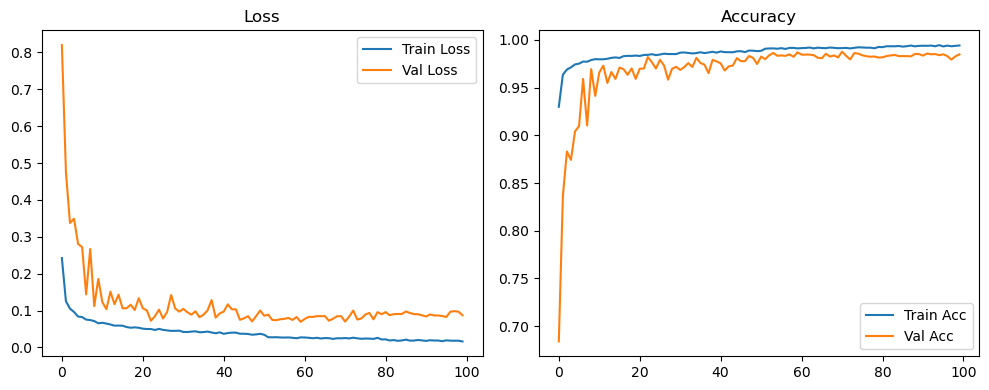

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1185, Acc: 0.9651 | Val Loss: 0.0604, Acc: 0.9822


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9857 | Val Loss: 0.0391, Acc: 0.9882


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.0565, Acc: 0.9830


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0493, Acc: 0.9846


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0509, Acc: 0.9845


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0391, Acc: 0.9890


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0461, Acc: 0.9875


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.0625, Acc: 0.9837


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0449, Acc: 0.9893


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0473, Acc: 0.9888


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0486, Acc: 0.9885


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0546, Acc: 0.9879


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0544, Acc: 0.9887


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0503, Acc: 0.9898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0556, Acc: 0.9884


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0553, Acc: 0.9881


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0509, Acc: 0.9894


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0456, Acc: 0.9893


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0601, Acc: 0.9878


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0553, Acc: 0.9892


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0526, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0542, Acc: 0.9899


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0793, Acc: 0.9858


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0590, Acc: 0.9885


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0549, Acc: 0.9890


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0526, Acc: 0.9901


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0578, Acc: 0.9890


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0593, Acc: 0.9894


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0563, Acc: 0.9895


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0606, Acc: 0.9884


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0619, Acc: 0.9885


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0501, Acc: 0.9911


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0582, Acc: 0.9902


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0638, Acc: 0.9893


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0628, Acc: 0.9895


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0569, Acc: 0.9905


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0616, Acc: 0.9894


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0808, Acc: 0.9872


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0598, Acc: 0.9906


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0635, Acc: 0.9907


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0740, Acc: 0.9891


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0760, Acc: 0.9891


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0667, Acc: 0.9891


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0681, Acc: 0.9899


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0642, Acc: 0.9904


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0795, Acc: 0.9877


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0747, Acc: 0.9895


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0708, Acc: 0.9912


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0824, Acc: 0.9888


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0866, Acc: 0.9885


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0664, Acc: 0.9904


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0613, Acc: 0.9912


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0572, Acc: 0.9922


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0595, Acc: 0.9912


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9924


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0661, Acc: 0.9907


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0630, Acc: 0.9906


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0640, Acc: 0.9909


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0640, Acc: 0.9922


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9920


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0659, Acc: 0.9919


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0637, Acc: 0.9918


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9925


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9923


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0653, Acc: 0.9919


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0676, Acc: 0.9911


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0726, Acc: 0.9900


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0761, Acc: 0.9907


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0709, Acc: 0.9914


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0850, Acc: 0.9899


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0723, Acc: 0.9917


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0689, Acc: 0.9922


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0744, Acc: 0.9907


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9919


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0704, Acc: 0.9913


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0677, Acc: 0.9922


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0723, Acc: 0.9911


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0752, Acc: 0.9904


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0729, Acc: 0.9912


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0749, Acc: 0.9908


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0696, Acc: 0.9911


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0678, Acc: 0.9911


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9913


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0683, Acc: 0.9915


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0690, Acc: 0.9914


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0697, Acc: 0.9914


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0685, Acc: 0.9919


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0688, Acc: 0.9919


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0689, Acc: 0.9914


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0696, Acc: 0.9918


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0699, Acc: 0.9917


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0670, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0668, Acc: 0.9918


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0684, Acc: 0.9911


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0693, Acc: 0.9917


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0692, Acc: 0.9915


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0677, Acc: 0.9918


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0682, Acc: 0.9916


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0649, Acc: 0.9919


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0655, Acc: 0.9926


Final Test Loss: 0.0593 Accuracy: 0.9918


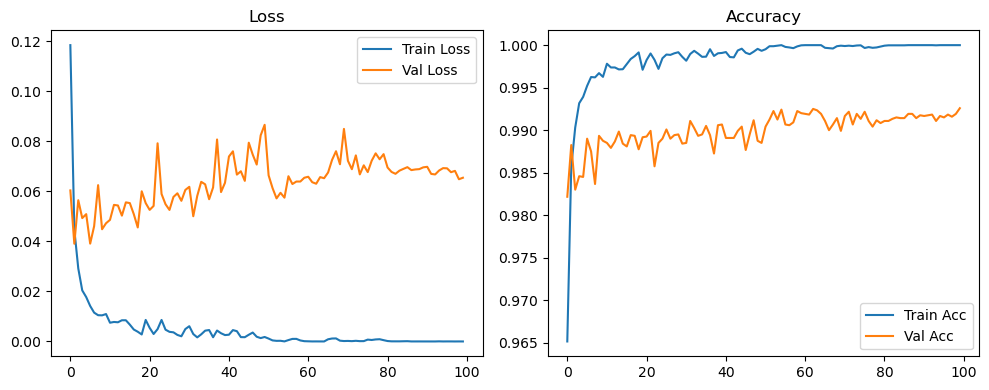

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1468, Acc: 0.9576 | Val Loss: 0.1590, Acc: 0.9507


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0654, Acc: 0.9800 | Val Loss: 0.0564, Acc: 0.9832


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9844 | Val Loss: 0.0608, Acc: 0.9811


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9866 | Val Loss: 0.0638, Acc: 0.9814


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9893 | Val Loss: 0.0567, Acc: 0.9820


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9890 | Val Loss: 0.0507, Acc: 0.9846


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.0656, Acc: 0.9799


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 0.0412, Acc: 0.9867


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.0420, Acc: 0.9879


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.0489, Acc: 0.9866


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0523, Acc: 0.9847


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.0377, Acc: 0.9902


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0543, Acc: 0.9839


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0494, Acc: 0.9854


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9941 | Val Loss: 0.0468, Acc: 0.9863


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.0441, Acc: 0.9872


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0469, Acc: 0.9871


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0443, Acc: 0.9875


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0419, Acc: 0.9886


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.0417, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.0574, Acc: 0.9838


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0488, Acc: 0.9874


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0527, Acc: 0.9857


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0461, Acc: 0.9874


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0474, Acc: 0.9871


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0465, Acc: 0.9886


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0541, Acc: 0.9862


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0393, Acc: 0.9898


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0479, Acc: 0.9886


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0499, Acc: 0.9866


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0461, Acc: 0.9877


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9964 | Val Loss: 0.0428, Acc: 0.9879


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0475, Acc: 0.9888


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0472, Acc: 0.9884


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0485, Acc: 0.9881


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0504, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0540, Acc: 0.9869


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0526, Acc: 0.9873


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0419, Acc: 0.9901


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0444, Acc: 0.9892


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0536, Acc: 0.9858


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0485, Acc: 0.9886


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0504, Acc: 0.9888


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0499, Acc: 0.9884


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0470, Acc: 0.9889


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0490, Acc: 0.9872


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0604, Acc: 0.9861


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0487, Acc: 0.9876


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0457, Acc: 0.9887


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0479, Acc: 0.9878


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0451, Acc: 0.9888


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0478, Acc: 0.9896


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0414, Acc: 0.9909


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0395, Acc: 0.9920


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0432, Acc: 0.9899


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0402, Acc: 0.9910


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0429, Acc: 0.9915


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0418, Acc: 0.9921


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0420, Acc: 0.9917


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0463, Acc: 0.9907


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0488, Acc: 0.9892


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0415, Acc: 0.9909


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0439, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0474, Acc: 0.9912


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0454, Acc: 0.9893


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0495, Acc: 0.9898


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0466, Acc: 0.9911


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0461, Acc: 0.9899


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0475, Acc: 0.9904


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0465, Acc: 0.9907


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0457, Acc: 0.9907


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0502, Acc: 0.9897


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0491, Acc: 0.9906


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0441, Acc: 0.9916


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0463, Acc: 0.9909


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0466, Acc: 0.9901


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0524, Acc: 0.9895


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0489, Acc: 0.9902


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0434, Acc: 0.9912


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0491, Acc: 0.9898


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0441, Acc: 0.9916


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0431, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0438, Acc: 0.9918


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0426, Acc: 0.9919


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0449, Acc: 0.9919


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0429, Acc: 0.9915


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0423, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0431, Acc: 0.9920


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0423, Acc: 0.9923


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0403, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0430, Acc: 0.9917


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0432, Acc: 0.9915


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0427, Acc: 0.9919


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0425, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0459, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0430, Acc: 0.9918


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0439, Acc: 0.9925


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0427, Acc: 0.9920


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0392, Acc: 0.9923


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0395, Acc: 0.9923


Final Test Loss: 0.0375 Accuracy: 0.9911


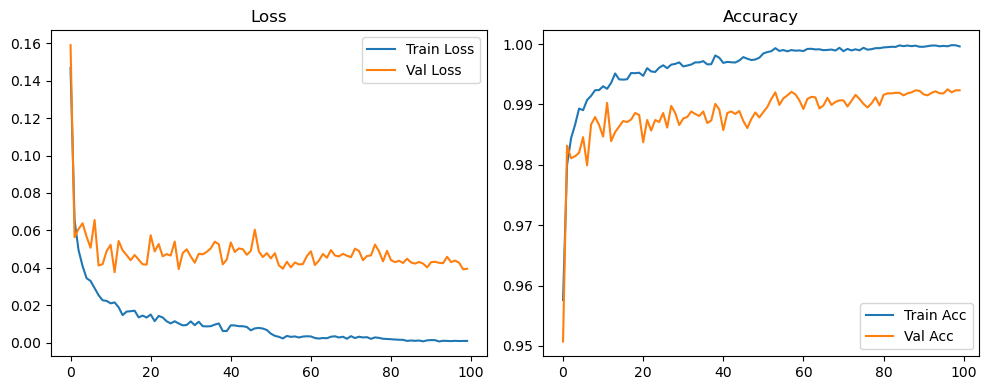

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2429, Acc: 0.9301 | Val Loss: 0.8379, Acc: 0.6883


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1241, Acc: 0.9634 | Val Loss: 0.2824, Acc: 0.9130


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1056, Acc: 0.9691 | Val Loss: 0.3121, Acc: 0.9001


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0959, Acc: 0.9722 | Val Loss: 0.2977, Acc: 0.9019


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9763 | Val Loss: 0.3785, Acc: 0.8652


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9748 | Val Loss: 0.2317, Acc: 0.9287


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0758, Acc: 0.9768 | Val Loss: 0.1676, Acc: 0.9474


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9770 | Val Loss: 0.1637, Acc: 0.9514


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9786 | Val Loss: 0.0791, Acc: 0.9818


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0693, Acc: 0.9787 | Val Loss: 0.1091, Acc: 0.9685


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9803 | Val Loss: 0.1044, Acc: 0.9700


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0658, Acc: 0.9800 | Val Loss: 0.0883, Acc: 0.9786


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9804 | Val Loss: 0.1156, Acc: 0.9712


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9815 | Val Loss: 0.0773, Acc: 0.9824


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9809 | Val Loss: 0.1723, Acc: 0.9465


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9824 | Val Loss: 0.0811, Acc: 0.9813


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9827 | Val Loss: 0.1053, Acc: 0.9698


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9829 | Val Loss: 0.1016, Acc: 0.9711


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0562, Acc: 0.9822 | Val Loss: 0.0763, Acc: 0.9828


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.1245, Acc: 0.9611


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9838 | Val Loss: 0.0844, Acc: 0.9810


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9849 | Val Loss: 0.0962, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9853 | Val Loss: 0.0829, Acc: 0.9781


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9842 | Val Loss: 0.0797, Acc: 0.9781


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9848 | Val Loss: 0.0842, Acc: 0.9787


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.0646, Acc: 0.9828


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9864 | Val Loss: 0.0757, Acc: 0.9809


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9852 | Val Loss: 0.0775, Acc: 0.9818


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9855 | Val Loss: 0.1014, Acc: 0.9730


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0457, Acc: 0.9852 | Val Loss: 0.0908, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0650, Acc: 0.9812


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9861 | Val Loss: 0.0636, Acc: 0.9820


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 0.0723, Acc: 0.9807


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9860 | Val Loss: 0.0728, Acc: 0.9822


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.0728, Acc: 0.9839


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9862 | Val Loss: 0.0800, Acc: 0.9798


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9872 | Val Loss: 0.0787, Acc: 0.9830


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9871 | Val Loss: 0.0917, Acc: 0.9745


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9870 | Val Loss: 0.0755, Acc: 0.9808


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0852, Acc: 0.9788


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.0787, Acc: 0.9824


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9875 | Val Loss: 0.1066, Acc: 0.9754


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9875 | Val Loss: 0.0861, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.0856, Acc: 0.9823


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.0797, Acc: 0.9838


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.0848, Acc: 0.9784


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9882 | Val Loss: 0.1077, Acc: 0.9679


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.0727, Acc: 0.9839


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9879 | Val Loss: 0.0869, Acc: 0.9844


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.0777, Acc: 0.9863


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9898 | Val Loss: 0.0832, Acc: 0.9852


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 0.0690, Acc: 0.9861


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0678, Acc: 0.9862


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.0748, Acc: 0.9860


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0665, Acc: 0.9824


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9910 | Val Loss: 0.0696, Acc: 0.9881


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0691, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0675, Acc: 0.9875


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9918 | Val Loss: 0.0653, Acc: 0.9858


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9915 | Val Loss: 0.0729, Acc: 0.9878


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0754, Acc: 0.9862


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0793, Acc: 0.9820


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0686, Acc: 0.9868


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9914 | Val Loss: 0.0766, Acc: 0.9864


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.0656, Acc: 0.9862


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.0674, Acc: 0.9858


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.0708, Acc: 0.9840


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.0827, Acc: 0.9838


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0818, Acc: 0.9836


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.0937, Acc: 0.9857


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0767, Acc: 0.9858


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9918 | Val Loss: 0.0824, Acc: 0.9857


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.0916, Acc: 0.9859


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9918 | Val Loss: 0.0965, Acc: 0.9864


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0847, Acc: 0.9860


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.0762, Acc: 0.9878


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.0961, Acc: 0.9860


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0689, Acc: 0.9868


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.0873, Acc: 0.9850


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.0763, Acc: 0.9870


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0754, Acc: 0.9878


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9936 | Val Loss: 0.0779, Acc: 0.9882


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0810, Acc: 0.9861


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0780, Acc: 0.9874


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0756, Acc: 0.9872


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0763, Acc: 0.9874


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0735, Acc: 0.9876


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0734, Acc: 0.9878


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0710, Acc: 0.9888


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0708, Acc: 0.9887


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0770, Acc: 0.9861


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9935 | Val Loss: 0.0746, Acc: 0.9872


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0743, Acc: 0.9874


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0701, Acc: 0.9878


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0721, Acc: 0.9866


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0755, Acc: 0.9877


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9930 | Val Loss: 0.0766, Acc: 0.9869


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0759, Acc: 0.9872


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9935 | Val Loss: 0.0739, Acc: 0.9881


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0701, Acc: 0.9881


Final Test Loss: 0.0650 Accuracy: 0.9892


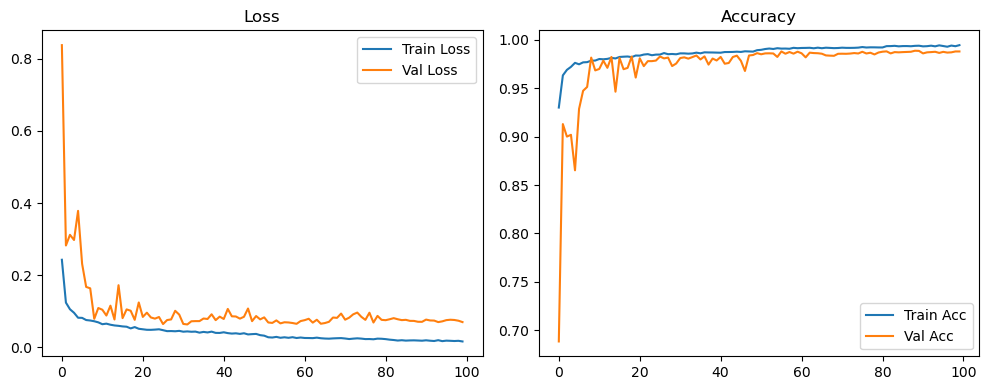

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1192, Acc: 0.9654 | Val Loss: 0.0572, Acc: 0.9829


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9855 | Val Loss: 0.0404, Acc: 0.9877


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.0486, Acc: 0.9856


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0423, Acc: 0.9868


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0452, Acc: 0.9862


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9951 | Val Loss: 0.0418, Acc: 0.9891


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0445, Acc: 0.9889


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0571, Acc: 0.9858


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0448, Acc: 0.9897


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.0500, Acc: 0.9857


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0531, Acc: 0.9885


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0508, Acc: 0.9885


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0488, Acc: 0.9896


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9975 | Val Loss: 0.0511, Acc: 0.9893


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9973 | Val Loss: 0.0528, Acc: 0.9898


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0511, Acc: 0.9892


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0562, Acc: 0.9884


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0701, Acc: 0.9862


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0665, Acc: 0.9852


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0471, Acc: 0.9908


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0488, Acc: 0.9907


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0473, Acc: 0.9907


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0584, Acc: 0.9883


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0709, Acc: 0.9875


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0579, Acc: 0.9897


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0688, Acc: 0.9873


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0598, Acc: 0.9884


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0643, Acc: 0.9891


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0638, Acc: 0.9878


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0639, Acc: 0.9888


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0613, Acc: 0.9892


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0863, Acc: 0.9877


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0569, Acc: 0.9894


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0631, Acc: 0.9886


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0725, Acc: 0.9858


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0638, Acc: 0.9892


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0574, Acc: 0.9900


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0587, Acc: 0.9900


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0719, Acc: 0.9888


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0765, Acc: 0.9882


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0627, Acc: 0.9899


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0603, Acc: 0.9900


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0613, Acc: 0.9908


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0674, Acc: 0.9904


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0713, Acc: 0.9887


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0649, Acc: 0.9899


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0714, Acc: 0.9889


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0746, Acc: 0.9888


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0798, Acc: 0.9875


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0848, Acc: 0.9875


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0606, Acc: 0.9911


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9912


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0594, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0591, Acc: 0.9913


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9916


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0572, Acc: 0.9919


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0582, Acc: 0.9915


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9918


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0580, Acc: 0.9915


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0574, Acc: 0.9921


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9911


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0582, Acc: 0.9918


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0608, Acc: 0.9919


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0581, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0583, Acc: 0.9928


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0564, Acc: 0.9927


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0566, Acc: 0.9926


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9923


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0575, Acc: 0.9930


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0596, Acc: 0.9928


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0577, Acc: 0.9927


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0610, Acc: 0.9920


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0621, Acc: 0.9923


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9915


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0639, Acc: 0.9916


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0615, Acc: 0.9918


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0631, Acc: 0.9918


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0625, Acc: 0.9915


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0619, Acc: 0.9923


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0657, Acc: 0.9916


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0643, Acc: 0.9924


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0637, Acc: 0.9923


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0632, Acc: 0.9924


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9924


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0638, Acc: 0.9923


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0640, Acc: 0.9921


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0627, Acc: 0.9924


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9919


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0636, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0638, Acc: 0.9922


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0612, Acc: 0.9921


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0613, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0619, Acc: 0.9920


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0614, Acc: 0.9926


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0622, Acc: 0.9922


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0645, Acc: 0.9919


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0648, Acc: 0.9919


Final Test Loss: 0.0624 Accuracy: 0.9910


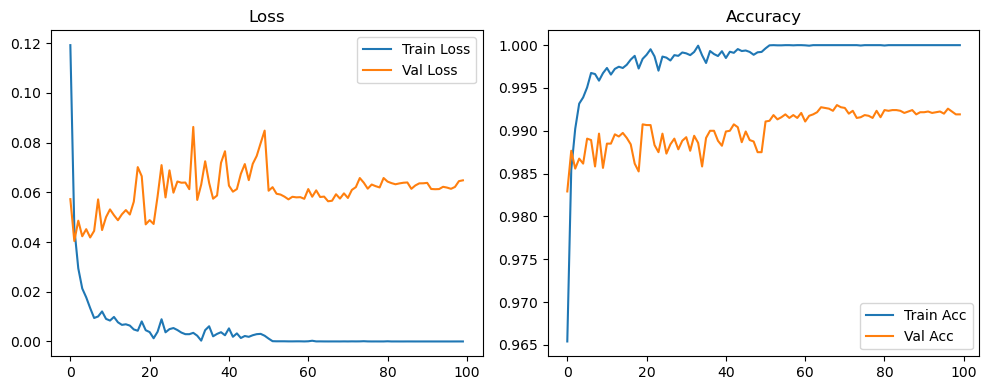

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1477, Acc: 0.9576 | Val Loss: 0.1956, Acc: 0.9396


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0651, Acc: 0.9796 | Val Loss: 0.0563, Acc: 0.9828


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9852 | Val Loss: 0.0538, Acc: 0.9845


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9866 | Val Loss: 0.0635, Acc: 0.9802


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.0641, Acc: 0.9795


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9890 | Val Loss: 0.0480, Acc: 0.9848


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0585, Acc: 0.9834


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0481, Acc: 0.9844


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0414, Acc: 0.9866


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0435, Acc: 0.9873


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0520, Acc: 0.9852


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9928 | Val Loss: 0.0423, Acc: 0.9881


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0526, Acc: 0.9845


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0410, Acc: 0.9894


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0486, Acc: 0.9859


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0486, Acc: 0.9869


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9948 | Val Loss: 0.0500, Acc: 0.9853


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9952 | Val Loss: 0.0433, Acc: 0.9902


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0456, Acc: 0.9868


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0427, Acc: 0.9874


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0407, Acc: 0.9885


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9955 | Val Loss: 0.0406, Acc: 0.9882


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0365, Acc: 0.9902


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0398, Acc: 0.9893


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0394, Acc: 0.9891


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0555, Acc: 0.9848


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0469, Acc: 0.9876


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0503, Acc: 0.9866


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0520, Acc: 0.9868


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0438, Acc: 0.9888


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0467, Acc: 0.9889


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0457, Acc: 0.9884


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0549, Acc: 0.9872


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0497, Acc: 0.9882


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0430, Acc: 0.9889


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0513, Acc: 0.9868


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0458, Acc: 0.9882


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0534, Acc: 0.9856


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0496, Acc: 0.9878


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0463, Acc: 0.9885


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0429, Acc: 0.9895


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0419, Acc: 0.9901


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0433, Acc: 0.9891


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0415, Acc: 0.9901


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0363, Acc: 0.9908


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0445, Acc: 0.9891


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0491, Acc: 0.9876


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0377, Acc: 0.9915


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0420, Acc: 0.9892


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.0460, Acc: 0.9893


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0408, Acc: 0.9901


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0394, Acc: 0.9908


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0384, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0382, Acc: 0.9920


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0386, Acc: 0.9915


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0366, Acc: 0.9916


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0369, Acc: 0.9920


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0375, Acc: 0.9923


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0370, Acc: 0.9922


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0381, Acc: 0.9922


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0398, Acc: 0.9918


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0433, Acc: 0.9909


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0377, Acc: 0.9918


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0412, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0435, Acc: 0.9906


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0390, Acc: 0.9922


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0381, Acc: 0.9923


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0407, Acc: 0.9918


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0429, Acc: 0.9916


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0396, Acc: 0.9921


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0407, Acc: 0.9917


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0402, Acc: 0.9918


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0414, Acc: 0.9914


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0400, Acc: 0.9918


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0424, Acc: 0.9920


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0380, Acc: 0.9922


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0402, Acc: 0.9922


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0381, Acc: 0.9921


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0393, Acc: 0.9920


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0410, Acc: 0.9920


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0373, Acc: 0.9928


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0365, Acc: 0.9925


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0393, Acc: 0.9923


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0395, Acc: 0.9923


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0400, Acc: 0.9920


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0380, Acc: 0.9924


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0388, Acc: 0.9924


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0397, Acc: 0.9927


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0400, Acc: 0.9928


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0385, Acc: 0.9931


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0412, Acc: 0.9924


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0404, Acc: 0.9923


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0410, Acc: 0.9927


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0384, Acc: 0.9927


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0400, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0386, Acc: 0.9924


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0412, Acc: 0.9921


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0399, Acc: 0.9924


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0379, Acc: 0.9922


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0364, Acc: 0.9928


Final Test Loss: 0.0422 Accuracy: 0.9902


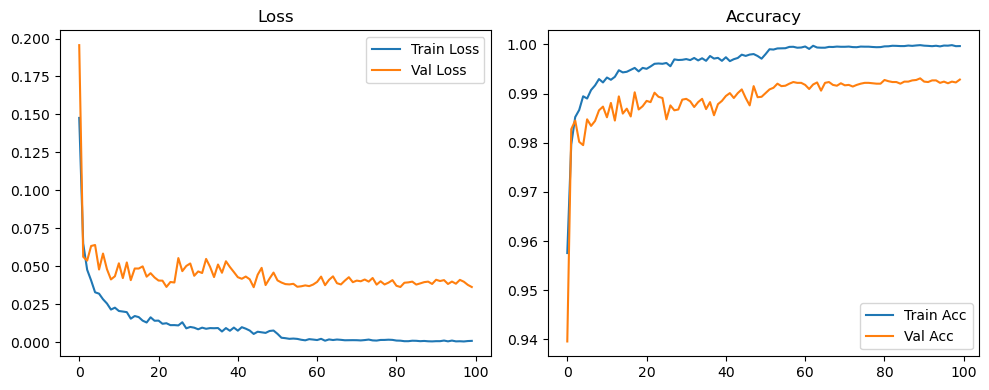

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2425, Acc: 0.9301 | Val Loss: 0.9050, Acc: 0.6591


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1248, Acc: 0.9629 | Val Loss: 0.3638, Acc: 0.8798


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1058, Acc: 0.9696 | Val Loss: 0.2595, Acc: 0.9137


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0984, Acc: 0.9718 | Val Loss: 0.2679, Acc: 0.9124


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0842, Acc: 0.9748 | Val Loss: 0.2556, Acc: 0.9149


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9743 | Val Loss: 0.2405, Acc: 0.9217


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9763 | Val Loss: 0.1700, Acc: 0.9469


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9775 | Val Loss: 0.1308, Acc: 0.9616


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9780 | Val Loss: 0.0817, Acc: 0.9812


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9785 | Val Loss: 0.2101, Acc: 0.9333


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0661, Acc: 0.9795 | Val Loss: 0.1089, Acc: 0.9692


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9803 | Val Loss: 0.1161, Acc: 0.9665


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9806 | Val Loss: 0.1292, Acc: 0.9639


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0597, Acc: 0.9814 | Val Loss: 0.1172, Acc: 0.9655


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9817 | Val Loss: 0.1545, Acc: 0.9527


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0586, Acc: 0.9817 | Val Loss: 0.1063, Acc: 0.9724


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9827 | Val Loss: 0.1121, Acc: 0.9657


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0535, Acc: 0.9836 | Val Loss: 0.0730, Acc: 0.9806


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9830 | Val Loss: 0.0848, Acc: 0.9763


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9830 | Val Loss: 0.1106, Acc: 0.9697


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9840 | Val Loss: 0.0829, Acc: 0.9808


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9850 | Val Loss: 0.1021, Acc: 0.9712


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9847 | Val Loss: 0.0725, Acc: 0.9824


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9843 | Val Loss: 0.0843, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0500, Acc: 0.9848 | Val Loss: 0.0987, Acc: 0.9733


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.0812, Acc: 0.9771


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9858 | Val Loss: 0.0731, Acc: 0.9804


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9853 | Val Loss: 0.0806, Acc: 0.9827


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 0.1417, Acc: 0.9577


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.0822, Acc: 0.9796


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.0721, Acc: 0.9802


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9867 | Val Loss: 0.0752, Acc: 0.9842


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9856 | Val Loss: 0.0941, Acc: 0.9742


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9864 | Val Loss: 0.0808, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9870 | Val Loss: 0.1120, Acc: 0.9667


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9868 | Val Loss: 0.0888, Acc: 0.9758


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9864 | Val Loss: 0.1038, Acc: 0.9729


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9868 | Val Loss: 0.0886, Acc: 0.9780


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9872 | Val Loss: 0.0915, Acc: 0.9779


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.1195, Acc: 0.9678


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.0970, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9874 | Val Loss: 0.0860, Acc: 0.9824


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9878 | Val Loss: 0.1356, Acc: 0.9567


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9876 | Val Loss: 0.1025, Acc: 0.9725


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.0874, Acc: 0.9780


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9874 | Val Loss: 0.0978, Acc: 0.9741


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9880 | Val Loss: 0.0993, Acc: 0.9780


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.0955, Acc: 0.9752


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.1000, Acc: 0.9771


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.1459, Acc: 0.9629


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9890 | Val Loss: 0.1183, Acc: 0.9727


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1067, Acc: 0.9748


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.0917, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9922 | Val Loss: 0.0846, Acc: 0.9831


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0861, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0823, Acc: 0.9829


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0797, Acc: 0.9827


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0816, Acc: 0.9803


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0828, Acc: 0.9812


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0859, Acc: 0.9807


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0856, Acc: 0.9815


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.0890, Acc: 0.9790


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0840, Acc: 0.9826


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0858, Acc: 0.9820


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0769, Acc: 0.9835


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.0759, Acc: 0.9842


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0784, Acc: 0.9835


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.0901, Acc: 0.9798


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0833, Acc: 0.9808


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.0883, Acc: 0.9804


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0759, Acc: 0.9849


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0918, Acc: 0.9789


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0861, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0822, Acc: 0.9847


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9928 | Val Loss: 0.0749, Acc: 0.9860


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0783, Acc: 0.9851


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9928 | Val Loss: 0.0850, Acc: 0.9824


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9934 | Val Loss: 0.0786, Acc: 0.9842


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.0910, Acc: 0.9825


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9932 | Val Loss: 0.0904, Acc: 0.9833


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0870, Acc: 0.9837


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0908, Acc: 0.9839


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0902, Acc: 0.9830


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0859, Acc: 0.9832


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0928, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0956, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0916, Acc: 0.9823


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9937 | Val Loss: 0.0864, Acc: 0.9833


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.0901, Acc: 0.9826


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.0901, Acc: 0.9814


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0916, Acc: 0.9803


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0869, Acc: 0.9826


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0846, Acc: 0.9839


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0872, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9941 | Val Loss: 0.0938, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.0919, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9943 | Val Loss: 0.0910, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0915, Acc: 0.9816


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0890, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0828, Acc: 0.9859


Final Test Loss: 0.0779 Accuracy: 0.9855


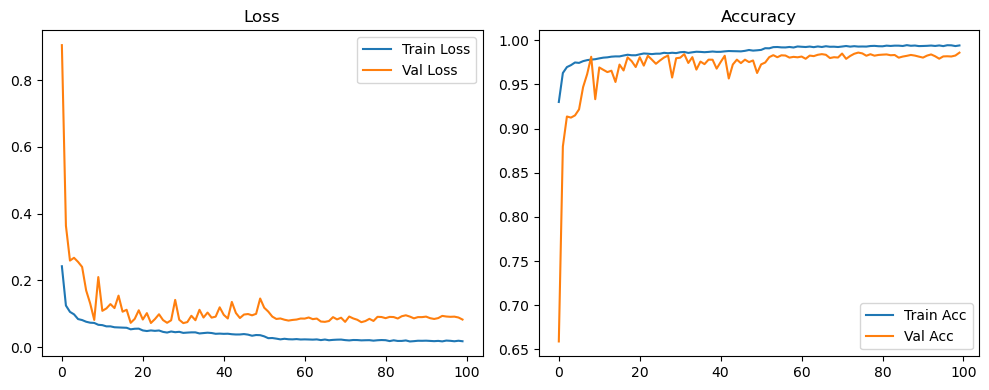

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1252, Acc: 0.9676 | Val Loss: 0.0519, Acc: 0.9852


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9864 | Val Loss: 0.0419, Acc: 0.9870


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0461, Acc: 0.9853


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0539, Acc: 0.9845


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0480, Acc: 0.9858


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0419, Acc: 0.9873


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0411, Acc: 0.9873


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0445, Acc: 0.9887


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0673, Acc: 0.9830


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0629, Acc: 0.9841


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0399, Acc: 0.9892


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0440, Acc: 0.9891


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0526, Acc: 0.9882


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0561, Acc: 0.9867


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0442, Acc: 0.9887


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0453, Acc: 0.9902


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0482, Acc: 0.9892


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0736, Acc: 0.9832


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0587, Acc: 0.9864


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0437, Acc: 0.9908


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0435, Acc: 0.9894


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0439, Acc: 0.9906


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0416, Acc: 0.9901


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0567, Acc: 0.9889


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0463, Acc: 0.9909


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0502, Acc: 0.9897


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0482, Acc: 0.9891


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0492, Acc: 0.9902


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0458, Acc: 0.9906


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0454, Acc: 0.9908


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0439, Acc: 0.9903


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0479, Acc: 0.9896


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0436, Acc: 0.9918


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0543, Acc: 0.9904


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0515, Acc: 0.9902


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0421, Acc: 0.9905


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0452, Acc: 0.9907


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0520, Acc: 0.9911


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.0523, Acc: 0.9897


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0548, Acc: 0.9905


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0542, Acc: 0.9900


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0533, Acc: 0.9902


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0643, Acc: 0.9902


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0549, Acc: 0.9911


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0600, Acc: 0.9902


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0486, Acc: 0.9920


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0654, Acc: 0.9892


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0608, Acc: 0.9905


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0587, Acc: 0.9897


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0634, Acc: 0.9887


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0551, Acc: 0.9897


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0555, Acc: 0.9905


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0463, Acc: 0.9916


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0563, Acc: 0.9899


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0507, Acc: 0.9911


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9919


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9925


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9920


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0633, Acc: 0.9900


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0605, Acc: 0.9895


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0520, Acc: 0.9908


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0519, Acc: 0.9908


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0436, Acc: 0.9910


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0571, Acc: 0.9908


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0645, Acc: 0.9900


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0572, Acc: 0.9911


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0582, Acc: 0.9900


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0656, Acc: 0.9898


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0575, Acc: 0.9903


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0559, Acc: 0.9910


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0618, Acc: 0.9898


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0542, Acc: 0.9920


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0579, Acc: 0.9908


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0556, Acc: 0.9904


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0671, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0638, Acc: 0.9906


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0602, Acc: 0.9907


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0508, Acc: 0.9921


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0544, Acc: 0.9923


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0537, Acc: 0.9901


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0667, Acc: 0.9897


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0528, Acc: 0.9912


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0500, Acc: 0.9922


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0509, Acc: 0.9922


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0568, Acc: 0.9912


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0586, Acc: 0.9908


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0565, Acc: 0.9910


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0790, Acc: 0.9877


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0712, Acc: 0.9905


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0581, Acc: 0.9914


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0724, Acc: 0.9902


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0709, Acc: 0.9898


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0659, Acc: 0.9894


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0664, Acc: 0.9911


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0727, Acc: 0.9897


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.0660, Acc: 0.9905


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0580, Acc: 0.9913


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0669, Acc: 0.9894


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0703, Acc: 0.9910


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0659, Acc: 0.9909


Final Test Loss: 0.0734 Accuracy: 0.9910


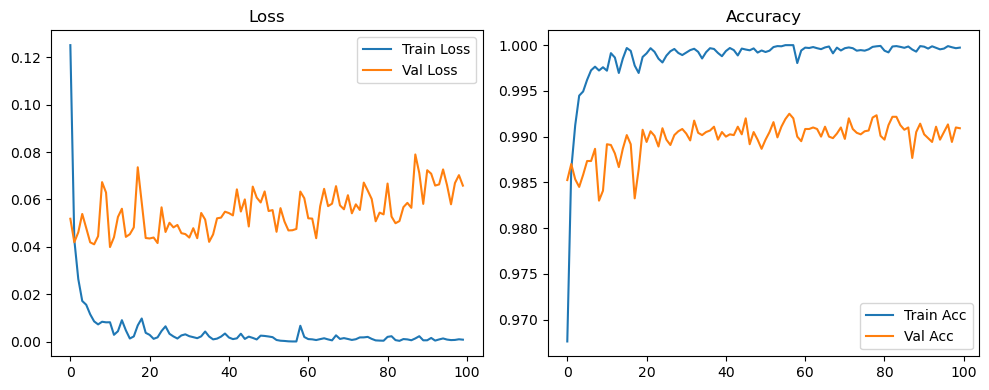

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1502, Acc: 0.9611 | Val Loss: 0.1390, Acc: 0.9560


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9805 | Val Loss: 0.0713, Acc: 0.9782


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.0631, Acc: 0.9805


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9875 | Val Loss: 0.0728, Acc: 0.9785


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0603, Acc: 0.9807


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.0605, Acc: 0.9815


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0561, Acc: 0.9836


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0453, Acc: 0.9839


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0448, Acc: 0.9870


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9937 | Val Loss: 0.0452, Acc: 0.9865


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9945 | Val Loss: 0.0412, Acc: 0.9886


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.0450, Acc: 0.9868


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.0449, Acc: 0.9868


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0486, Acc: 0.9867


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0397, Acc: 0.9873


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.0471, Acc: 0.9855


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0517, Acc: 0.9853


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0429, Acc: 0.9878


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0488, Acc: 0.9863


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9959 | Val Loss: 0.0422, Acc: 0.9882


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9962 | Val Loss: 0.0395, Acc: 0.9889


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0365, Acc: 0.9889


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0374, Acc: 0.9903


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9964 | Val Loss: 0.0341, Acc: 0.9902


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0394, Acc: 0.9890


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0475, Acc: 0.9872


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0364, Acc: 0.9894


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9968 | Val Loss: 0.0442, Acc: 0.9885


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0451, Acc: 0.9878


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0405, Acc: 0.9889


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0369, Acc: 0.9898


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0501, Acc: 0.9871


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0446, Acc: 0.9883


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0416, Acc: 0.9892


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0517, Acc: 0.9859


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0501, Acc: 0.9868


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0425, Acc: 0.9887


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0476, Acc: 0.9881


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.0391, Acc: 0.9900


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0395, Acc: 0.9904


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9974 | Val Loss: 0.0367, Acc: 0.9886


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0408, Acc: 0.9892


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0404, Acc: 0.9895


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0444, Acc: 0.9891


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0417, Acc: 0.9885


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0371, Acc: 0.9891


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0469, Acc: 0.9882


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0396, Acc: 0.9900


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0438, Acc: 0.9894


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0399, Acc: 0.9908


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0450, Acc: 0.9896


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0426, Acc: 0.9896


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0385, Acc: 0.9894


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0472, Acc: 0.9883


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9980 | Val Loss: 0.0483, Acc: 0.9885


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0411, Acc: 0.9904


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0485, Acc: 0.9870


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0369, Acc: 0.9912


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0374, Acc: 0.9904


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0411, Acc: 0.9901


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0467, Acc: 0.9889


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0497, Acc: 0.9882


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0361, Acc: 0.9911


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0500, Acc: 0.9875


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0429, Acc: 0.9882


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0426, Acc: 0.9897


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0448, Acc: 0.9891


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0485, Acc: 0.9888


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0401, Acc: 0.9902


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0331, Acc: 0.9912


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0379, Acc: 0.9912


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0392, Acc: 0.9890


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0384, Acc: 0.9910


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0481, Acc: 0.9889


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0446, Acc: 0.9898


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0371, Acc: 0.9909


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.0345, Acc: 0.9913


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0363, Acc: 0.9916


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0360, Acc: 0.9912


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0342, Acc: 0.9908


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0383, Acc: 0.9902


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0360, Acc: 0.9906


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0395, Acc: 0.9894


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0422, Acc: 0.9888


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0396, Acc: 0.9900


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0350, Acc: 0.9912


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0372, Acc: 0.9908


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0430, Acc: 0.9901


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0412, Acc: 0.9901


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0355, Acc: 0.9916


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0371, Acc: 0.9902


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0367, Acc: 0.9906


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0334, Acc: 0.9915


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0382, Acc: 0.9906


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0428, Acc: 0.9896


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0423, Acc: 0.9886


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0449, Acc: 0.9889


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0385, Acc: 0.9908


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0454, Acc: 0.9882


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0384, Acc: 0.9911


Final Test Loss: 0.0404 Accuracy: 0.9896


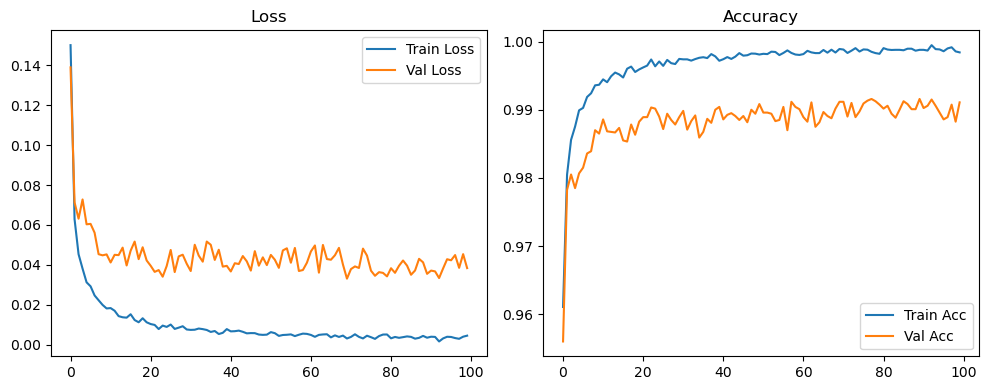

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2499, Acc: 0.9324 | Val Loss: 0.7677, Acc: 0.7116


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1224, Acc: 0.9642 | Val Loss: 0.2189, Acc: 0.9364


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1004, Acc: 0.9705 | Val Loss: 0.2344, Acc: 0.9289


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0894, Acc: 0.9729 | Val Loss: 0.2140, Acc: 0.9323


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0800, Acc: 0.9760 | Val Loss: 0.1420, Acc: 0.9587


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9765 | Val Loss: 0.1412, Acc: 0.9606


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0719, Acc: 0.9779 | Val Loss: 0.1319, Acc: 0.9627


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0684, Acc: 0.9791 | Val Loss: 0.1556, Acc: 0.9503


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9805 | Val Loss: 0.1232, Acc: 0.9656


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9812 | Val Loss: 0.1298, Acc: 0.9602


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9820 | Val Loss: 0.1008, Acc: 0.9702


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0584, Acc: 0.9824 | Val Loss: 0.0780, Acc: 0.9804


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9825 | Val Loss: 0.1098, Acc: 0.9688


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9840 | Val Loss: 0.1300, Acc: 0.9604


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0543, Acc: 0.9830 | Val Loss: 0.1143, Acc: 0.9673


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0541, Acc: 0.9839 | Val Loss: 0.1283, Acc: 0.9605


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9839 | Val Loss: 0.1027, Acc: 0.9709


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9851 | Val Loss: 0.0767, Acc: 0.9773


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0499, Acc: 0.9841 | Val Loss: 0.0739, Acc: 0.9808


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9849 | Val Loss: 0.1009, Acc: 0.9695


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9858 | Val Loss: 0.0960, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9861 | Val Loss: 0.0740, Acc: 0.9788


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.0741, Acc: 0.9803


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9865 | Val Loss: 0.0693, Acc: 0.9823


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9857 | Val Loss: 0.0823, Acc: 0.9758


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0710, Acc: 0.9812


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9871 | Val Loss: 0.0941, Acc: 0.9735


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.1018, Acc: 0.9730


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9869 | Val Loss: 0.1062, Acc: 0.9702


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9877 | Val Loss: 0.0742, Acc: 0.9796


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0714, Acc: 0.9804


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9883 | Val Loss: 0.0752, Acc: 0.9812


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 0.0729, Acc: 0.9805


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.0756, Acc: 0.9801


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9873 | Val Loss: 0.0806, Acc: 0.9778


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9881 | Val Loss: 0.0841, Acc: 0.9761


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9883 | Val Loss: 0.0885, Acc: 0.9765


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9881 | Val Loss: 0.0994, Acc: 0.9726


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.0718, Acc: 0.9841


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.1014, Acc: 0.9712


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.0848, Acc: 0.9774


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0882, Acc: 0.9775


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9889 | Val Loss: 0.0863, Acc: 0.9756


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9901 | Val Loss: 0.0951, Acc: 0.9732


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9893 | Val Loss: 0.0860, Acc: 0.9779


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.0788, Acc: 0.9814


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9896 | Val Loss: 0.0794, Acc: 0.9818


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0664, Acc: 0.9834


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.0839, Acc: 0.9798


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0330, Acc: 0.9894 | Val Loss: 0.1194, Acc: 0.9644


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.0949, Acc: 0.9754


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9902 | Val Loss: 0.0700, Acc: 0.9840


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.0717, Acc: 0.9825


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9887 | Val Loss: 0.0750, Acc: 0.9818


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.0825, Acc: 0.9781


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0790, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9898 | Val Loss: 0.0875, Acc: 0.9778


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.0628, Acc: 0.9857


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0829, Acc: 0.9813


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0789, Acc: 0.9787


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0878, Acc: 0.9780


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9902 | Val Loss: 0.0836, Acc: 0.9797


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9902 | Val Loss: 0.0896, Acc: 0.9772


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.0835, Acc: 0.9823


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0761, Acc: 0.9826


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0848, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0821, Acc: 0.9841


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.0895, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9900 | Val Loss: 0.0785, Acc: 0.9825


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0808, Acc: 0.9865


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.0822, Acc: 0.9859


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9909 | Val Loss: 0.0882, Acc: 0.9830


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0938, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9907 | Val Loss: 0.0870, Acc: 0.9820


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0820, Acc: 0.9826


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0931, Acc: 0.9815


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0978, Acc: 0.9822


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0871, Acc: 0.9826


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9908 | Val Loss: 0.1011, Acc: 0.9816


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.0747, Acc: 0.9862


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0827, Acc: 0.9849


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0802, Acc: 0.9844


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0908, Acc: 0.9833


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.0938, Acc: 0.9840


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9908 | Val Loss: 0.0764, Acc: 0.9854


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0840, Acc: 0.9841


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0678, Acc: 0.9872


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9920 | Val Loss: 0.0791, Acc: 0.9862


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0690, Acc: 0.9875


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9917 | Val Loss: 0.0905, Acc: 0.9839


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.1025, Acc: 0.9849


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.1204, Acc: 0.9820


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0868, Acc: 0.9879


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0870, Acc: 0.9865


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.0732, Acc: 0.9866


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1122, Acc: 0.9810


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1028, Acc: 0.9819


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.1223, Acc: 0.9768


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0938, Acc: 0.9832


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.1056, Acc: 0.9837


Final Test Loss: 0.1034 Accuracy: 0.9817


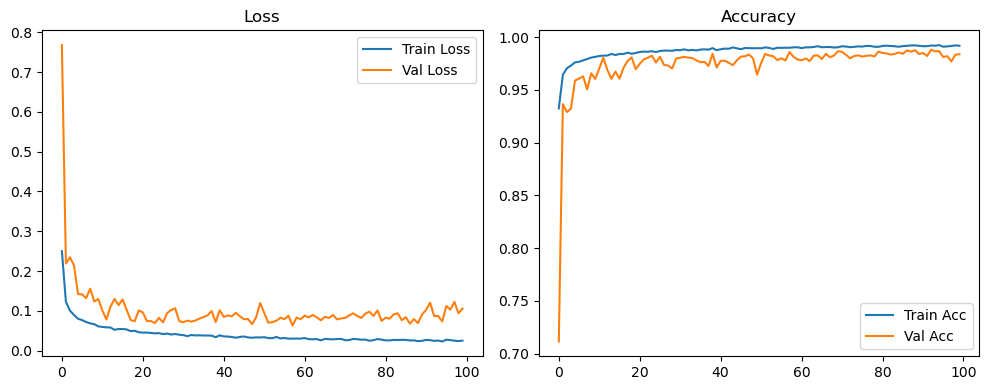

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1252, Acc: 0.9673 | Val Loss: 0.0519, Acc: 0.9843


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9863 | Val Loss: 0.0401, Acc: 0.9879


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0495, Acc: 0.9837


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.0457, Acc: 0.9866


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0402, Acc: 0.9885


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 0.0424, Acc: 0.9877


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0382, Acc: 0.9891


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0381, Acc: 0.9892


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0399, Acc: 0.9888


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0500, Acc: 0.9865


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0484, Acc: 0.9868


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0480, Acc: 0.9881


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0387, Acc: 0.9908


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0432, Acc: 0.9894


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0518, Acc: 0.9888


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0551, Acc: 0.9884


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0480, Acc: 0.9890


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0523, Acc: 0.9872


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0425, Acc: 0.9899


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9978 | Val Loss: 0.0507, Acc: 0.9890


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0451, Acc: 0.9901


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0460, Acc: 0.9892


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0410, Acc: 0.9914


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0554, Acc: 0.9876


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0601, Acc: 0.9881


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0461, Acc: 0.9912


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0475, Acc: 0.9912


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0428, Acc: 0.9912


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0442, Acc: 0.9912


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0494, Acc: 0.9894


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0585, Acc: 0.9891


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0525, Acc: 0.9906


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0472, Acc: 0.9918


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0544, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0523, Acc: 0.9902


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0609, Acc: 0.9884


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0518, Acc: 0.9912


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0534, Acc: 0.9896


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0531, Acc: 0.9894


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0526, Acc: 0.9907


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0578, Acc: 0.9902


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0603, Acc: 0.9892


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0512, Acc: 0.9921


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0486, Acc: 0.9918


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9925


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0618, Acc: 0.9897


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0596, Acc: 0.9894


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0531, Acc: 0.9915


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0490, Acc: 0.9906


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0485, Acc: 0.9900


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0483, Acc: 0.9904


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9914


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9916


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0432, Acc: 0.9918


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9919


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9922


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9920


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9923


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9926


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9930


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0488, Acc: 0.9916


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0533, Acc: 0.9911


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0508, Acc: 0.9920


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9926


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9922


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9919


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9922


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0486, Acc: 0.9923


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0519, Acc: 0.9926


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0553, Acc: 0.9916


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0532, Acc: 0.9911


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0494, Acc: 0.9922


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9923


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9926


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9921


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9928


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9928


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9927


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9927


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9928


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9926


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9924


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9922


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0494, Acc: 0.9923


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0493, Acc: 0.9926


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0502, Acc: 0.9926


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9928


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0507, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0515, Acc: 0.9925


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9920


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0543, Acc: 0.9927


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9921


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9923


Final Test Loss: 0.0587 Accuracy: 0.9916


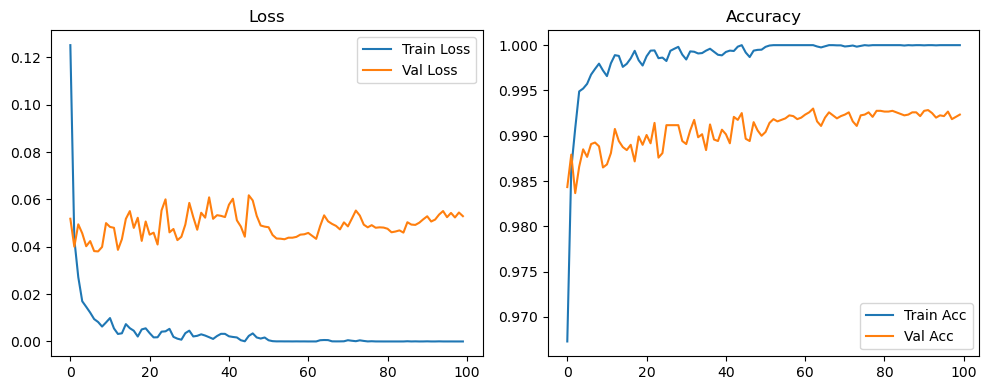

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1497, Acc: 0.9611 | Val Loss: 0.1770, Acc: 0.9453


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0629, Acc: 0.9804 | Val Loss: 0.0737, Acc: 0.9778


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9859 | Val Loss: 0.0674, Acc: 0.9790


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9884 | Val Loss: 0.0530, Acc: 0.9840


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.0598, Acc: 0.9814


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.0640, Acc: 0.9801


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9914 | Val Loss: 0.0833, Acc: 0.9741


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0443, Acc: 0.9862


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0422, Acc: 0.9872


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0526, Acc: 0.9848


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.0577, Acc: 0.9838


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0435, Acc: 0.9871


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0541, Acc: 0.9850


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0487, Acc: 0.9868


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0557, Acc: 0.9852


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0440, Acc: 0.9877


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0446, Acc: 0.9877


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9955 | Val Loss: 0.0453, Acc: 0.9882


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0429, Acc: 0.9879


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.0410, Acc: 0.9882


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9965 | Val Loss: 0.0485, Acc: 0.9863


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0402, Acc: 0.9886


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0421, Acc: 0.9880


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0407, Acc: 0.9882


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0388, Acc: 0.9894


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0433, Acc: 0.9888


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0486, Acc: 0.9872


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0450, Acc: 0.9882


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0448, Acc: 0.9889


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0445, Acc: 0.9873


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0405, Acc: 0.9885


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0509, Acc: 0.9868


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9976 | Val Loss: 0.0407, Acc: 0.9891


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0398, Acc: 0.9898


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0443, Acc: 0.9890


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9973 | Val Loss: 0.0522, Acc: 0.9866


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0376, Acc: 0.9900


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0471, Acc: 0.9882


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0413, Acc: 0.9898


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0473, Acc: 0.9889


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0438, Acc: 0.9896


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0431, Acc: 0.9900


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0402, Acc: 0.9902


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0489, Acc: 0.9878


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0446, Acc: 0.9891


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0413, Acc: 0.9898


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0439, Acc: 0.9889


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0391, Acc: 0.9898


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0420, Acc: 0.9889


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0383, Acc: 0.9901


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0399, Acc: 0.9903


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0425, Acc: 0.9899


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0384, Acc: 0.9909


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0362, Acc: 0.9908


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0360, Acc: 0.9918


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0361, Acc: 0.9918


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0382, Acc: 0.9909


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0439, Acc: 0.9910


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0361, Acc: 0.9920


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0405, Acc: 0.9917


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0388, Acc: 0.9920


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0387, Acc: 0.9912


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0369, Acc: 0.9920


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0434, Acc: 0.9907


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0418, Acc: 0.9901


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0359, Acc: 0.9925


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0386, Acc: 0.9922


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0367, Acc: 0.9911


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0367, Acc: 0.9914


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0380, Acc: 0.9915


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0389, Acc: 0.9915


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0403, Acc: 0.9909


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0394, Acc: 0.9914


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0451, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0417, Acc: 0.9906


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0421, Acc: 0.9906


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0410, Acc: 0.9912


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0388, Acc: 0.9918


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0385, Acc: 0.9918


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0412, Acc: 0.9912


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0394, Acc: 0.9912


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0365, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0379, Acc: 0.9914


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0359, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0371, Acc: 0.9919


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0383, Acc: 0.9917


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0350, Acc: 0.9918


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0395, Acc: 0.9910


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0399, Acc: 0.9908


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0374, Acc: 0.9913


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0392, Acc: 0.9915


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0375, Acc: 0.9918


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0358, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0374, Acc: 0.9919


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0392, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0390, Acc: 0.9922


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0394, Acc: 0.9917


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0382, Acc: 0.9915


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0372, Acc: 0.9919


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0364, Acc: 0.9918


Final Test Loss: 0.0363 Accuracy: 0.9901


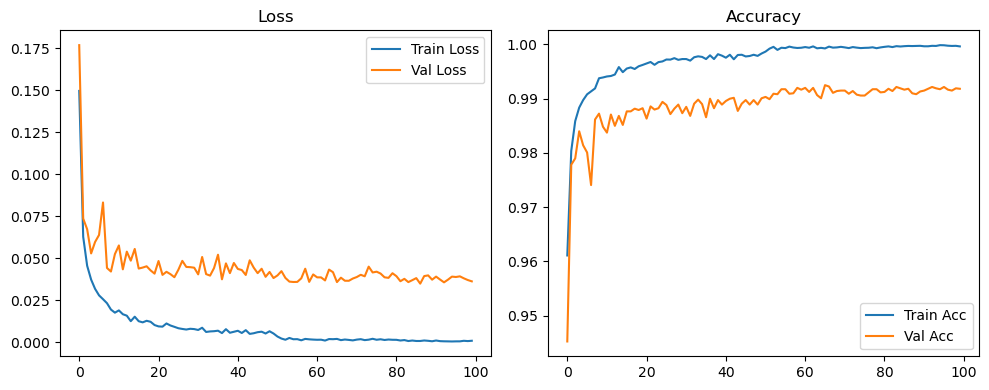

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2501, Acc: 0.9324 | Val Loss: 0.8084, Acc: 0.6946


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1222, Acc: 0.9645 | Val Loss: 0.3064, Acc: 0.9022


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1001, Acc: 0.9707 | Val Loss: 0.2206, Acc: 0.9322


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0892, Acc: 0.9735 | Val Loss: 0.2339, Acc: 0.9258


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0795, Acc: 0.9761 | Val Loss: 0.1904, Acc: 0.9397


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0750, Acc: 0.9771 | Val Loss: 0.1626, Acc: 0.9479


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0731, Acc: 0.9776 | Val Loss: 0.1689, Acc: 0.9483


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9792 | Val Loss: 0.1607, Acc: 0.9484


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9805 | Val Loss: 0.1442, Acc: 0.9604


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9808 | Val Loss: 0.1377, Acc: 0.9585


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0597, Acc: 0.9812 | Val Loss: 0.1175, Acc: 0.9654


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0585, Acc: 0.9821 | Val Loss: 0.0910, Acc: 0.9771


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0588, Acc: 0.9817 | Val Loss: 0.1065, Acc: 0.9688


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9839 | Val Loss: 0.1119, Acc: 0.9673


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9830 | Val Loss: 0.1104, Acc: 0.9680


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0523, Acc: 0.9841 | Val Loss: 0.1162, Acc: 0.9657


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9836 | Val Loss: 0.1210, Acc: 0.9630


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9849 | Val Loss: 0.0823, Acc: 0.9765


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9841 | Val Loss: 0.0812, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9856 | Val Loss: 0.1217, Acc: 0.9639


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9862 | Val Loss: 0.0733, Acc: 0.9812


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9860 | Val Loss: 0.0673, Acc: 0.9816


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9864 | Val Loss: 0.0800, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9873 | Val Loss: 0.0679, Acc: 0.9812


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9862 | Val Loss: 0.1052, Acc: 0.9683


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9869 | Val Loss: 0.0888, Acc: 0.9732


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.0672, Acc: 0.9838


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9871 | Val Loss: 0.0884, Acc: 0.9785


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9863 | Val Loss: 0.0922, Acc: 0.9762


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9876 | Val Loss: 0.0767, Acc: 0.9798


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9880 | Val Loss: 0.1167, Acc: 0.9652


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9879 | Val Loss: 0.0934, Acc: 0.9734


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0798, Acc: 0.9793


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9880 | Val Loss: 0.0769, Acc: 0.9783


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0818, Acc: 0.9778


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.1057, Acc: 0.9692


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.0861, Acc: 0.9757


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9884 | Val Loss: 0.1089, Acc: 0.9684


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9888 | Val Loss: 0.0800, Acc: 0.9796


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1051, Acc: 0.9702


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 0.0861, Acc: 0.9781


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1031, Acc: 0.9737


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9887 | Val Loss: 0.0851, Acc: 0.9770


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.1121, Acc: 0.9659


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.0879, Acc: 0.9788


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9886 | Val Loss: 0.1015, Acc: 0.9751


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9885 | Val Loss: 0.0904, Acc: 0.9777


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0672, Acc: 0.9850


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9896 | Val Loss: 0.0746, Acc: 0.9852


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0750, Acc: 0.9830


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9913 | Val Loss: 0.0726, Acc: 0.9846


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0662, Acc: 0.9861


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.0686, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9918 | Val Loss: 0.0716, Acc: 0.9854


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0707, Acc: 0.9848


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.0744, Acc: 0.9836


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9926 | Val Loss: 0.0662, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9929 | Val Loss: 0.0677, Acc: 0.9842


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0702, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9925 | Val Loss: 0.0694, Acc: 0.9856


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.0745, Acc: 0.9849


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9923 | Val Loss: 0.0687, Acc: 0.9856


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0660, Acc: 0.9869


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0609, Acc: 0.9882


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0676, Acc: 0.9864


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0733, Acc: 0.9833


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.0697, Acc: 0.9858


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0660, Acc: 0.9860


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.0646, Acc: 0.9870


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.0696, Acc: 0.9859


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0618, Acc: 0.9872


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9930 | Val Loss: 0.0687, Acc: 0.9864


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9929 | Val Loss: 0.0740, Acc: 0.9839


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0768, Acc: 0.9864


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.0657, Acc: 0.9885


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0702, Acc: 0.9878


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0887, Acc: 0.9808


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0705, Acc: 0.9860


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0684, Acc: 0.9862


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0749, Acc: 0.9845


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0728, Acc: 0.9868


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0674, Acc: 0.9874


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0720, Acc: 0.9853


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.0759, Acc: 0.9845


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0766, Acc: 0.9836


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0785, Acc: 0.9867


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.0732, Acc: 0.9882


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0710, Acc: 0.9872


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0756, Acc: 0.9882


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0763, Acc: 0.9878


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0829, Acc: 0.9870


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0799, Acc: 0.9882


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0734, Acc: 0.9888


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.0811, Acc: 0.9873


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0821, Acc: 0.9869


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0877, Acc: 0.9847


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0887, Acc: 0.9838


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9948 | Val Loss: 0.0916, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.0916, Acc: 0.9837


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9938 | Val Loss: 0.0817, Acc: 0.9880


Final Test Loss: 0.0764 Accuracy: 0.9858


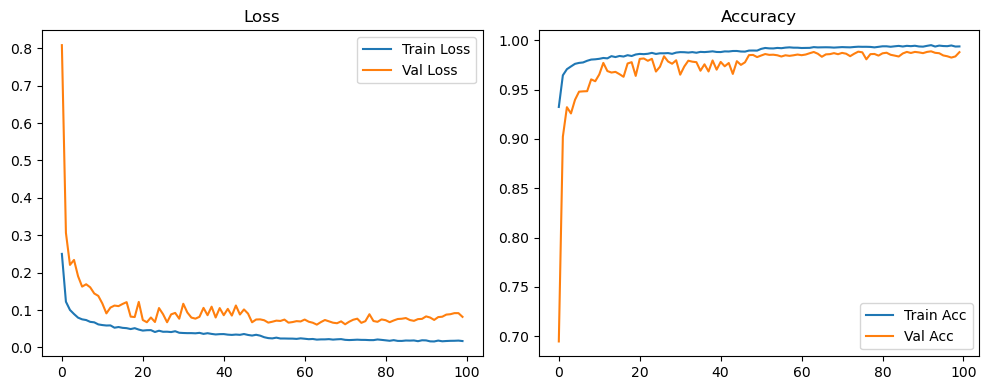

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1539, Acc: 0.9684 | Val Loss: 0.0575, Acc: 0.9824


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9877 | Val Loss: 0.0418, Acc: 0.9875


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9921 | Val Loss: 0.0410, Acc: 0.9876


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.0419, Acc: 0.9874


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9965 | Val Loss: 0.0389, Acc: 0.9880


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.0414, Acc: 0.9868


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.0365, Acc: 0.9894


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0411, Acc: 0.9877


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0757, Acc: 0.9765


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9987 | Val Loss: 0.0437, Acc: 0.9871


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0428, Acc: 0.9889


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0599, Acc: 0.9835


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0403, Acc: 0.9893


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0542, Acc: 0.9864


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0493, Acc: 0.9873


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0530, Acc: 0.9866


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0405, Acc: 0.9900


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0394, Acc: 0.9904


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0473, Acc: 0.9899


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0509, Acc: 0.9879


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0445, Acc: 0.9899


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0542, Acc: 0.9878


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0466, Acc: 0.9902


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0456, Acc: 0.9897


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9908


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0512, Acc: 0.9888


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0695, Acc: 0.9857


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0534, Acc: 0.9885


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0455, Acc: 0.9894


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0388, Acc: 0.9919


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0451, Acc: 0.9905


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0553, Acc: 0.9890


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0463, Acc: 0.9902


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0501, Acc: 0.9895


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0521, Acc: 0.9885


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0463, Acc: 0.9907


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0504, Acc: 0.9884


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0489, Acc: 0.9906


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0466, Acc: 0.9907


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0513, Acc: 0.9906


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0502, Acc: 0.9899


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0645, Acc: 0.9868


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0674, Acc: 0.9877


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0536, Acc: 0.9898


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0471, Acc: 0.9908


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0431, Acc: 0.9913


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0469, Acc: 0.9909


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0454, Acc: 0.9909


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0536, Acc: 0.9890


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0553, Acc: 0.9898


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0489, Acc: 0.9902


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0530, Acc: 0.9901


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9908


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9915


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9911


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9914


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0628, Acc: 0.9895


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0491, Acc: 0.9907


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0449, Acc: 0.9913


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9916


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9922


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0435, Acc: 0.9911


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9918


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9917


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9918


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0701, Acc: 0.9867


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0494, Acc: 0.9910


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0469, Acc: 0.9912


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9905


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0484, Acc: 0.9914


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9916


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0517, Acc: 0.9912


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9913


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0720, Acc: 0.9868


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0566, Acc: 0.9902


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0592, Acc: 0.9899


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0553, Acc: 0.9902


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0533, Acc: 0.9902


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0501, Acc: 0.9909


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0537, Acc: 0.9902


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0517, Acc: 0.9912


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0567, Acc: 0.9899


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0561, Acc: 0.9907


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9992 | Val Loss: 0.0632, Acc: 0.9900


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0535, Acc: 0.9903


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0545, Acc: 0.9902


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0511, Acc: 0.9911


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9912


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0504, Acc: 0.9909


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0514, Acc: 0.9914


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0567, Acc: 0.9912


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0499, Acc: 0.9916


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0496, Acc: 0.9912


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0686, Acc: 0.9873


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0531, Acc: 0.9907


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0532, Acc: 0.9902


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0499, Acc: 0.9908


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9910


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0503, Acc: 0.9909


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9917


Final Test Loss: 0.0513 Accuracy: 0.9900


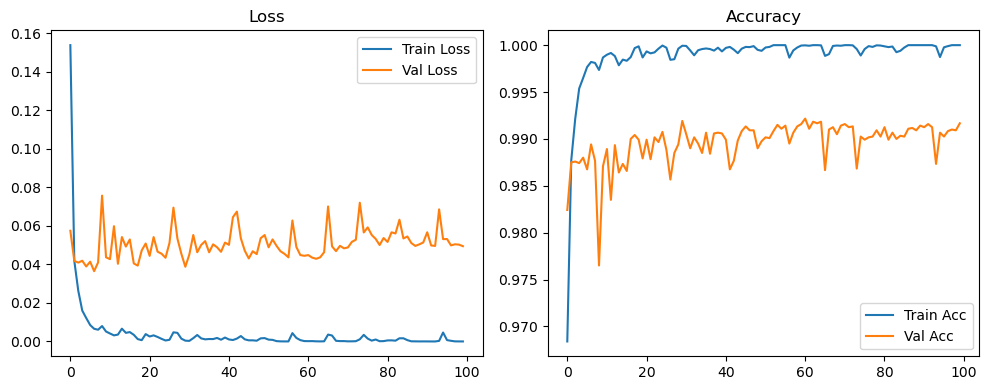

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1826, Acc: 0.9617 | Val Loss: 0.1387, Acc: 0.9596


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0622, Acc: 0.9812 | Val Loss: 0.0825, Acc: 0.9754


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9854 | Val Loss: 0.0804, Acc: 0.9755


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0512, Acc: 0.9850


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0587, Acc: 0.9811


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0565, Acc: 0.9828


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0516, Acc: 0.9836


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0564, Acc: 0.9818


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0448, Acc: 0.9868


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0498, Acc: 0.9856


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.0510, Acc: 0.9853


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0409, Acc: 0.9882


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0510, Acc: 0.9852


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0381, Acc: 0.9898


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0451, Acc: 0.9891


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9958 | Val Loss: 0.0464, Acc: 0.9874


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0417, Acc: 0.9887


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0400, Acc: 0.9895


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0402, Acc: 0.9881


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0319, Acc: 0.9900


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0401, Acc: 0.9873


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0350, Acc: 0.9896


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0426, Acc: 0.9875


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0367, Acc: 0.9902


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0377, Acc: 0.9895


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0412, Acc: 0.9884


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.0403, Acc: 0.9892


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0473, Acc: 0.9878


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0440, Acc: 0.9892


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0486, Acc: 0.9875


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0359, Acc: 0.9908


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0406, Acc: 0.9891


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0356, Acc: 0.9909


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0378, Acc: 0.9898


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0355, Acc: 0.9907


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0439, Acc: 0.9887


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0364, Acc: 0.9911


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0399, Acc: 0.9903


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0396, Acc: 0.9908


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0392, Acc: 0.9907


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0373, Acc: 0.9915


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0395, Acc: 0.9899


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0353, Acc: 0.9909


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0375, Acc: 0.9909


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0351, Acc: 0.9916


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0352, Acc: 0.9917


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0405, Acc: 0.9898


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0453, Acc: 0.9895


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0353, Acc: 0.9912


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0391, Acc: 0.9899


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0420, Acc: 0.9900


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0452, Acc: 0.9889


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0382, Acc: 0.9905


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0414, Acc: 0.9892


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9983 | Val Loss: 0.0359, Acc: 0.9912


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0387, Acc: 0.9901


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0378, Acc: 0.9909


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0406, Acc: 0.9894


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0348, Acc: 0.9908


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0391, Acc: 0.9911


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0407, Acc: 0.9904


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0375, Acc: 0.9911


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0335, Acc: 0.9914


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0386, Acc: 0.9905


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0365, Acc: 0.9913


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0429, Acc: 0.9896


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0334, Acc: 0.9919


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0383, Acc: 0.9919


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.0393, Acc: 0.9920


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0399, Acc: 0.9906


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0372, Acc: 0.9903


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0384, Acc: 0.9906


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0439, Acc: 0.9904


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0353, Acc: 0.9916


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0400, Acc: 0.9903


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0379, Acc: 0.9907


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0349, Acc: 0.9911


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0383, Acc: 0.9904


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0424, Acc: 0.9910


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0402, Acc: 0.9905


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0431, Acc: 0.9906


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0384, Acc: 0.9913


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0384, Acc: 0.9907


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0418, Acc: 0.9904


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0397, Acc: 0.9908


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0325, Acc: 0.9925


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0381, Acc: 0.9910


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0396, Acc: 0.9903


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0416, Acc: 0.9906


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0397, Acc: 0.9909


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0386, Acc: 0.9911


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0425, Acc: 0.9903


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0340, Acc: 0.9918


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0375, Acc: 0.9904


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0390, Acc: 0.9902


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0364, Acc: 0.9912


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0353, Acc: 0.9916


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9987 | Val Loss: 0.0370, Acc: 0.9911


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0369, Acc: 0.9914


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0343, Acc: 0.9921


Final Test Loss: 0.0355 Accuracy: 0.9907


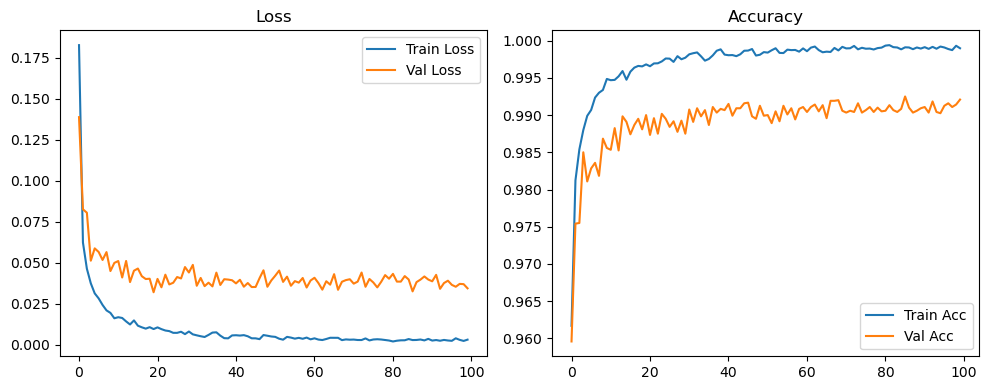

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2982, Acc: 0.9301 | Val Loss: 0.8269, Acc: 0.6997


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1263, Acc: 0.9632 | Val Loss: 0.3966, Acc: 0.8663


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1045, Acc: 0.9689 | Val Loss: 0.4268, Acc: 0.8417


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0887, Acc: 0.9731 | Val Loss: 0.3054, Acc: 0.8973


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0828, Acc: 0.9754 | Val Loss: 0.2988, Acc: 0.8960


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9763 | Val Loss: 0.2497, Acc: 0.9127


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0710, Acc: 0.9781 | Val Loss: 0.1851, Acc: 0.9412


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9809 | Val Loss: 0.1988, Acc: 0.9360


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9809 | Val Loss: 0.1470, Acc: 0.9565


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9808 | Val Loss: 0.1870, Acc: 0.9403


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9825 | Val Loss: 0.1075, Acc: 0.9693


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0568, Acc: 0.9826 | Val Loss: 0.0848, Acc: 0.9777


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9832 | Val Loss: 0.1207, Acc: 0.9623


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.1173, Acc: 0.9641


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.1522, Acc: 0.9504


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9846 | Val Loss: 0.1159, Acc: 0.9647


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0464, Acc: 0.9850 | Val Loss: 0.0983, Acc: 0.9711


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9860 | Val Loss: 0.0909, Acc: 0.9723


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0455, Acc: 0.9864 | Val Loss: 0.1000, Acc: 0.9713


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9868 | Val Loss: 0.1177, Acc: 0.9627


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9868 | Val Loss: 0.1133, Acc: 0.9651


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9860 | Val Loss: 0.0702, Acc: 0.9808


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0425, Acc: 0.9868 | Val Loss: 0.0764, Acc: 0.9782


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9865 | Val Loss: 0.0778, Acc: 0.9783


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9865 | Val Loss: 0.0732, Acc: 0.9788


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9878 | Val Loss: 0.0832, Acc: 0.9757


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.0735, Acc: 0.9814


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9875 | Val Loss: 0.0702, Acc: 0.9817


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.0738, Acc: 0.9800


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9879 | Val Loss: 0.0769, Acc: 0.9782


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0775, Acc: 0.9784


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9890 | Val Loss: 0.0729, Acc: 0.9783


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9891 | Val Loss: 0.0870, Acc: 0.9754


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9893 | Val Loss: 0.0821, Acc: 0.9781


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9886 | Val Loss: 0.0828, Acc: 0.9776


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0722, Acc: 0.9803


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9891 | Val Loss: 0.0797, Acc: 0.9774


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9895 | Val Loss: 0.0666, Acc: 0.9820


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9895 | Val Loss: 0.0625, Acc: 0.9841


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0692, Acc: 0.9822


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0863, Acc: 0.9772


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.0750, Acc: 0.9808


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9899 | Val Loss: 0.0744, Acc: 0.9809


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0791, Acc: 0.9798


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0825, Acc: 0.9776


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0920, Acc: 0.9747


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9900 | Val Loss: 0.0942, Acc: 0.9746


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9903 | Val Loss: 0.0791, Acc: 0.9796


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9901 | Val Loss: 0.0872, Acc: 0.9764


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0738, Acc: 0.9827


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.0868, Acc: 0.9789


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.0800, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.0818, Acc: 0.9794


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9908 | Val Loss: 0.0937, Acc: 0.9747


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9915 | Val Loss: 0.1035, Acc: 0.9705


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0787, Acc: 0.9791


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9912 | Val Loss: 0.0860, Acc: 0.9794


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.0767, Acc: 0.9837


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0871, Acc: 0.9780


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0812, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.0784, Acc: 0.9824


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0897, Acc: 0.9812


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0719, Acc: 0.9854


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9919 | Val Loss: 0.0827, Acc: 0.9828


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0915, Acc: 0.9779


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.0970, Acc: 0.9762


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9918 | Val Loss: 0.1006, Acc: 0.9778


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.1071, Acc: 0.9738


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1175, Acc: 0.9683


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.0975, Acc: 0.9754


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.1023, Acc: 0.9785


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.1259, Acc: 0.9626


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1171, Acc: 0.9713


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9918 | Val Loss: 0.1055, Acc: 0.9782


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.1008, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.1058, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9913 | Val Loss: 0.1102, Acc: 0.9804


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.1040, Acc: 0.9761


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0989, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0983, Acc: 0.9800


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0981, Acc: 0.9842


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.1040, Acc: 0.9784


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.1158, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0933, Acc: 0.9822


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.1217, Acc: 0.9780


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.1194, Acc: 0.9775


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.1109, Acc: 0.9813


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1171, Acc: 0.9757


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0995, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0983, Acc: 0.9826


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1096, Acc: 0.9802


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.1022, Acc: 0.9840


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1053, Acc: 0.9801


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9928 | Val Loss: 0.0871, Acc: 0.9829


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0967, Acc: 0.9822


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.1114, Acc: 0.9788


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1194, Acc: 0.9765


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.1345, Acc: 0.9713


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.1093, Acc: 0.9778


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1263, Acc: 0.9810


Final Test Loss: 0.1214 Accuracy: 0.9806


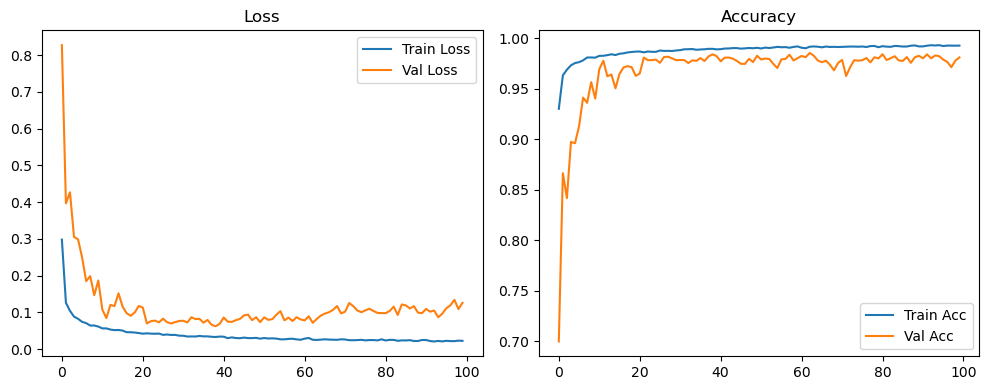

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2032, Acc: 0.9667 | Val Loss: 0.0703, Acc: 0.9818


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9878 | Val Loss: 0.0480, Acc: 0.9872


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9921 | Val Loss: 0.0421, Acc: 0.9876


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9947 | Val Loss: 0.0395, Acc: 0.9882


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9966 | Val Loss: 0.0381, Acc: 0.9876


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9977 | Val Loss: 0.0397, Acc: 0.9870


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9986 | Val Loss: 0.0340, Acc: 0.9892


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9993 | Val Loss: 0.0383, Acc: 0.9881


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.0411, Acc: 0.9877


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0411, Acc: 0.9883


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0542, Acc: 0.9852


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0447, Acc: 0.9880


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.0366, Acc: 0.9907


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9995 | Val Loss: 0.0404, Acc: 0.9894


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0421, Acc: 0.9891


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0589, Acc: 0.9840


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0467, Acc: 0.9878


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0429, Acc: 0.9896


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0391, Acc: 0.9898


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.0380, Acc: 0.9908


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0388, Acc: 0.9911


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0497, Acc: 0.9881


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0471, Acc: 0.9876


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0494, Acc: 0.9882


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0606, Acc: 0.9857


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0406, Acc: 0.9909


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9914


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9911


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9916


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0558, Acc: 0.9879


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.0494, Acc: 0.9885


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0455, Acc: 0.9900


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0444, Acc: 0.9907


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9917


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9912


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9913


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9910


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9915


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0766, Acc: 0.9833


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0472, Acc: 0.9899


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0421, Acc: 0.9902


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0434, Acc: 0.9902


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0419, Acc: 0.9900


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0385, Acc: 0.9912


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9907


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9917


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9918


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9920


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9918


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9918


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0677, Acc: 0.9845


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9977 | Val Loss: 0.0463, Acc: 0.9892


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0452, Acc: 0.9899


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0438, Acc: 0.9908


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9915


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9910


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9917


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0472, Acc: 0.9897


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0509, Acc: 0.9885


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0476, Acc: 0.9903


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9916


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9912


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9919


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0488, Acc: 0.9907


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0531, Acc: 0.9887


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.0462, Acc: 0.9905


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0478, Acc: 0.9902


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0408, Acc: 0.9918


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9920


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0527, Acc: 0.9894


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0445, Acc: 0.9909


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9928


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0468, Acc: 0.9909


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0459, Acc: 0.9903


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0434, Acc: 0.9907


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9915


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9909


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9922


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0421, Acc: 0.9914


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9909


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0518, Acc: 0.9885


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0446, Acc: 0.9909


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0444, Acc: 0.9912


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0484, Acc: 0.9901


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9905


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9912


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9914


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0546, Acc: 0.9891


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0555, Acc: 0.9903


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0487, Acc: 0.9906


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0501, Acc: 0.9901


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9912


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9910


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9912


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9915


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9914


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9916


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9917


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9919


Final Test Loss: 0.0369 Accuracy: 0.9917


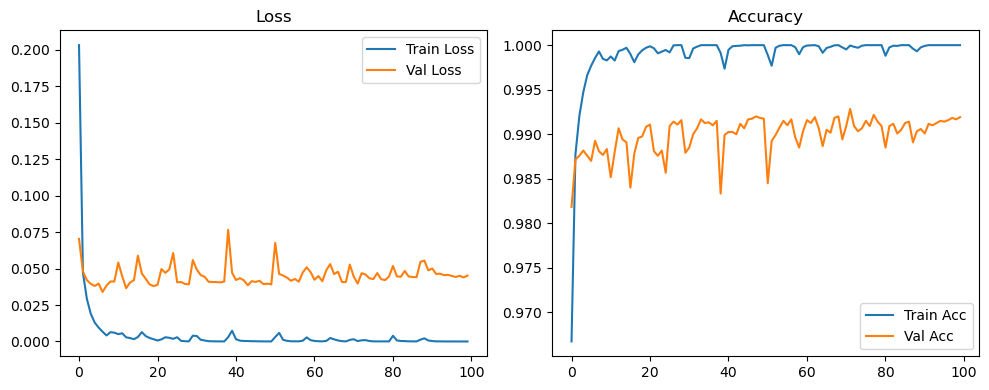

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2412, Acc: 0.9587 | Val Loss: 0.1663, Acc: 0.9578


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0683, Acc: 0.9820 | Val Loss: 0.0921, Acc: 0.9757


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9859 | Val Loss: 0.0926, Acc: 0.9738


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9878 | Val Loss: 0.0712, Acc: 0.9801


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9899 | Val Loss: 0.0650, Acc: 0.9801


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0636, Acc: 0.9810


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0662, Acc: 0.9780


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.0556, Acc: 0.9818


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0463, Acc: 0.9868


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0556, Acc: 0.9832


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0515, Acc: 0.9848


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0457, Acc: 0.9877


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0468, Acc: 0.9862


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0489, Acc: 0.9868


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0520, Acc: 0.9845


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0485, Acc: 0.9863


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0538, Acc: 0.9851


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0412, Acc: 0.9886


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0453, Acc: 0.9870


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0426, Acc: 0.9888


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0418, Acc: 0.9883


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0403, Acc: 0.9892


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0455, Acc: 0.9878


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0469, Acc: 0.9878


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0426, Acc: 0.9890


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0408, Acc: 0.9884


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0386, Acc: 0.9890


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0423, Acc: 0.9888


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0432, Acc: 0.9887


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9975 | Val Loss: 0.0436, Acc: 0.9888


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0384, Acc: 0.9902


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0384, Acc: 0.9892


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0435, Acc: 0.9890


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0425, Acc: 0.9889


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0397, Acc: 0.9900


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0372, Acc: 0.9902


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0417, Acc: 0.9901


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0457, Acc: 0.9894


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0466, Acc: 0.9883


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0420, Acc: 0.9901


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0425, Acc: 0.9894


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0387, Acc: 0.9904


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0460, Acc: 0.9882


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0474, Acc: 0.9892


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0436, Acc: 0.9893


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0391, Acc: 0.9905


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0450, Acc: 0.9884


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0435, Acc: 0.9901


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0415, Acc: 0.9911


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0449, Acc: 0.9906


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0494, Acc: 0.9880


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0432, Acc: 0.9890


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0418, Acc: 0.9900


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0373, Acc: 0.9899


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0443, Acc: 0.9882


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0465, Acc: 0.9891


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0444, Acc: 0.9883


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0424, Acc: 0.9890


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0338, Acc: 0.9906


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0398, Acc: 0.9907


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0356, Acc: 0.9908


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0363, Acc: 0.9912


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0402, Acc: 0.9900


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0399, Acc: 0.9903


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0414, Acc: 0.9894


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0368, Acc: 0.9918


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0379, Acc: 0.9906


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0370, Acc: 0.9908


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0422, Acc: 0.9891


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0415, Acc: 0.9897


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0402, Acc: 0.9894


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0407, Acc: 0.9903


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0443, Acc: 0.9896


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0402, Acc: 0.9893


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0414, Acc: 0.9905


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0397, Acc: 0.9894


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0356, Acc: 0.9908


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0414, Acc: 0.9898


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0385, Acc: 0.9913


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0403, Acc: 0.9904


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0414, Acc: 0.9899


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0376, Acc: 0.9910


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0419, Acc: 0.9900


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0394, Acc: 0.9910


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0419, Acc: 0.9908


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9988 | Val Loss: 0.0408, Acc: 0.9902


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0358, Acc: 0.9911


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0398, Acc: 0.9902


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0459, Acc: 0.9897


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0423, Acc: 0.9902


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0439, Acc: 0.9894


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0443, Acc: 0.9897


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0406, Acc: 0.9912


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0439, Acc: 0.9904


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0432, Acc: 0.9904


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0411, Acc: 0.9900


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0450, Acc: 0.9889


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0417, Acc: 0.9911


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0443, Acc: 0.9894


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0408, Acc: 0.9902


Final Test Loss: 0.0305 Accuracy: 0.9914


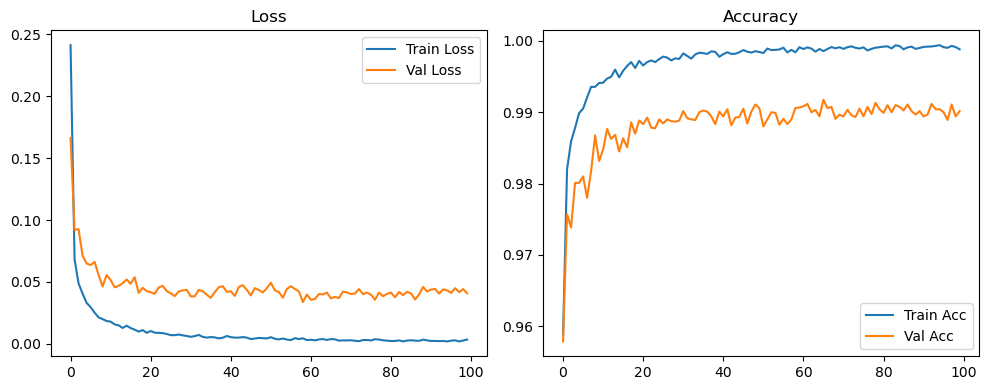

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3827, Acc: 0.9234 | Val Loss: 1.1004, Acc: 0.5824


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1417, Acc: 0.9622 | Val Loss: 0.8090, Acc: 0.6980


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1126, Acc: 0.9690 | Val Loss: 0.7541, Acc: 0.7241


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0968, Acc: 0.9729 | Val Loss: 0.5322, Acc: 0.7960


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0900, Acc: 0.9738 | Val Loss: 0.4084, Acc: 0.8488


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0818, Acc: 0.9759 | Val Loss: 0.5213, Acc: 0.8051


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0762, Acc: 0.9771 | Val Loss: 0.3196, Acc: 0.8930


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0711, Acc: 0.9783 | Val Loss: 0.2938, Acc: 0.8960


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0709, Acc: 0.9791 | Val Loss: 0.3159, Acc: 0.8879


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0653, Acc: 0.9799 | Val Loss: 0.2351, Acc: 0.9213


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0608, Acc: 0.9809 | Val Loss: 0.1468, Acc: 0.9556


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9818 | Val Loss: 0.1292, Acc: 0.9623


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0581, Acc: 0.9818 | Val Loss: 0.2072, Acc: 0.9341


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9834 | Val Loss: 0.1480, Acc: 0.9534


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0543, Acc: 0.9832 | Val Loss: 0.1442, Acc: 0.9552


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9844 | Val Loss: 0.1322, Acc: 0.9590


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0505, Acc: 0.9843 | Val Loss: 0.1534, Acc: 0.9508


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9849 | Val Loss: 0.0959, Acc: 0.9719


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9851 | Val Loss: 0.0916, Acc: 0.9728


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9854 | Val Loss: 0.1233, Acc: 0.9601


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9852 | Val Loss: 0.0944, Acc: 0.9728


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9867 | Val Loss: 0.0821, Acc: 0.9767


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 0.0829, Acc: 0.9763


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9868 | Val Loss: 0.0853, Acc: 0.9762


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9866 | Val Loss: 0.0877, Acc: 0.9754


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9875 | Val Loss: 0.0911, Acc: 0.9732


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9868 | Val Loss: 0.0804, Acc: 0.9771


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9873 | Val Loss: 0.0781, Acc: 0.9795


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0825, Acc: 0.9768


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.0944, Acc: 0.9728


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0387, Acc: 0.9879 | Val Loss: 0.0825, Acc: 0.9763


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9891 | Val Loss: 0.0776, Acc: 0.9769


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9886 | Val Loss: 0.0816, Acc: 0.9769


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.0724, Acc: 0.9803


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 0.0815, Acc: 0.9772


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9886 | Val Loss: 0.0809, Acc: 0.9767


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9887 | Val Loss: 0.0701, Acc: 0.9803


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0706, Acc: 0.9812


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9891 | Val Loss: 0.0592, Acc: 0.9862


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9892 | Val Loss: 0.0680, Acc: 0.9842


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.0758, Acc: 0.9808


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0659, Acc: 0.9848


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.0632, Acc: 0.9834


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9900 | Val Loss: 0.0690, Acc: 0.9823


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9901 | Val Loss: 0.0594, Acc: 0.9855


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9897 | Val Loss: 0.0669, Acc: 0.9853


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9905 | Val Loss: 0.0668, Acc: 0.9833


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0594, Acc: 0.9870


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0621, Acc: 0.9843


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9902 | Val Loss: 0.0581, Acc: 0.9864


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9904 | Val Loss: 0.0665, Acc: 0.9846


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0781, Acc: 0.9803


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9907 | Val Loss: 0.0818, Acc: 0.9788


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0310, Acc: 0.9904 | Val Loss: 0.0686, Acc: 0.9840


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9913 | Val Loss: 0.0812, Acc: 0.9792


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.0662, Acc: 0.9852


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0780, Acc: 0.9818


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.0767, Acc: 0.9838


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0687, Acc: 0.9862


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.0679, Acc: 0.9866


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0783, Acc: 0.9830


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0765, Acc: 0.9848


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.0683, Acc: 0.9848


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0775, Acc: 0.9828


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9921 | Val Loss: 0.0792, Acc: 0.9818


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.0790, Acc: 0.9813


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9921 | Val Loss: 0.0750, Acc: 0.9827


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9912 | Val Loss: 0.0843, Acc: 0.9796


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0891, Acc: 0.9777


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.0831, Acc: 0.9807


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0821, Acc: 0.9822


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0767, Acc: 0.9832


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9923 | Val Loss: 0.0820, Acc: 0.9831


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0854, Acc: 0.9826


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0764, Acc: 0.9833


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.0782, Acc: 0.9830


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9922 | Val Loss: 0.0808, Acc: 0.9842


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0725, Acc: 0.9852


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0762, Acc: 0.9837


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9913 | Val Loss: 0.0730, Acc: 0.9857


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0866, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9919 | Val Loss: 0.0735, Acc: 0.9848


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0746, Acc: 0.9844


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9922 | Val Loss: 0.0727, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9920 | Val Loss: 0.0857, Acc: 0.9810


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9928 | Val Loss: 0.0810, Acc: 0.9846


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.0757, Acc: 0.9853


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9917 | Val Loss: 0.0804, Acc: 0.9852


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0783, Acc: 0.9849


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.0840, Acc: 0.9836


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0946, Acc: 0.9844


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0747, Acc: 0.9857


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.0803, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0783, Acc: 0.9873


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0788, Acc: 0.9863


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0924, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0826, Acc: 0.9853


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9926 | Val Loss: 0.0903, Acc: 0.9818


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0839, Acc: 0.9835


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0923, Acc: 0.9827


Final Test Loss: 0.0899 Accuracy: 0.9817


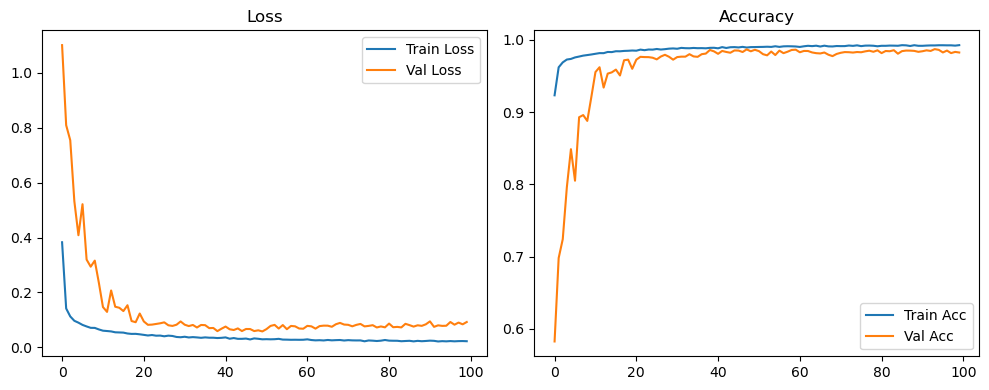

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1404, Acc: 0.9617 | Val Loss: 0.0963, Acc: 0.9704


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9870 | Val Loss: 0.0410, Acc: 0.9882


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.0531, Acc: 0.9847


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0519, Acc: 0.9852


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0603, Acc: 0.9827


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0518, Acc: 0.9843


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0398, Acc: 0.9888


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0431, Acc: 0.9883


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0374, Acc: 0.9897


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0432, Acc: 0.9899


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0504, Acc: 0.9892


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0704, Acc: 0.9829


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0644, Acc: 0.9858


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0457, Acc: 0.9896


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0423, Acc: 0.9908


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0527, Acc: 0.9882


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1166, Acc: 0.9771


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0493, Acc: 0.9890


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0651, Acc: 0.9855


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0495, Acc: 0.9897


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0515, Acc: 0.9896


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0785, Acc: 0.9839


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.0909, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0537, Acc: 0.9893


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0526, Acc: 0.9901


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0542, Acc: 0.9891


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0453, Acc: 0.9912


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0602, Acc: 0.9886


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0644, Acc: 0.9871


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0672, Acc: 0.9887


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0577, Acc: 0.9908


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0539, Acc: 0.9905


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0541, Acc: 0.9897


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0705, Acc: 0.9882


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0516, Acc: 0.9904


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0747, Acc: 0.9875


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0566, Acc: 0.9894


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0623, Acc: 0.9893


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0569, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0500, Acc: 0.9907


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0506, Acc: 0.9915


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9914


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9913


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9912


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9918


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0575, Acc: 0.9903


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9959 | Val Loss: 0.0695, Acc: 0.9869


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0495, Acc: 0.9902


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0459, Acc: 0.9919


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0490, Acc: 0.9915


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0452, Acc: 0.9918


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0523, Acc: 0.9911


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9928


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9929


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9909


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0483, Acc: 0.9918


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9917


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0973, Acc: 0.9850


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0649, Acc: 0.9881


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0630, Acc: 0.9888


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0520, Acc: 0.9912


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0511, Acc: 0.9913


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0521, Acc: 0.9897


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0555, Acc: 0.9900


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0640, Acc: 0.9896


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0572, Acc: 0.9910


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0539, Acc: 0.9908


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0498, Acc: 0.9917


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0524, Acc: 0.9914


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0576, Acc: 0.9916


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0517, Acc: 0.9925


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0579, Acc: 0.9915


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0660, Acc: 0.9904


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9988 | Val Loss: 0.0882, Acc: 0.9849


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0628, Acc: 0.9902


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0590, Acc: 0.9891


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0692, Acc: 0.9888


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0592, Acc: 0.9912


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9921


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0551, Acc: 0.9918


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9922


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9924


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9922


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9924


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9922


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0533, Acc: 0.9922


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9926


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0547, Acc: 0.9924


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9925


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0549, Acc: 0.9924


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0554, Acc: 0.9925


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0534, Acc: 0.9927


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9925


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0542, Acc: 0.9928


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0550, Acc: 0.9925


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0552, Acc: 0.9922


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9927


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0539, Acc: 0.9929


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0548, Acc: 0.9928


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0546, Acc: 0.9928


Final Test Loss: 0.0492 Accuracy: 0.9922


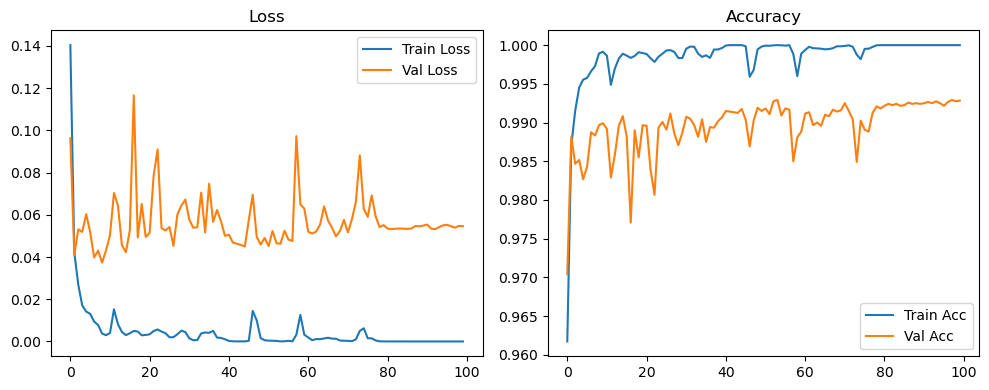

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1704, Acc: 0.9516 | Val Loss: 0.3001, Acc: 0.9035


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9806 | Val Loss: 0.0661, Acc: 0.9804


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9848 | Val Loss: 0.0734, Acc: 0.9758


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9877 | Val Loss: 0.0476, Acc: 0.9859


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.0528, Acc: 0.9837


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9909 | Val Loss: 0.0451, Acc: 0.9866


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0457, Acc: 0.9860


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.0385, Acc: 0.9884


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0394, Acc: 0.9877


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0418, Acc: 0.9872


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9941 | Val Loss: 0.0495, Acc: 0.9853


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9944 | Val Loss: 0.0441, Acc: 0.9871


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9951 | Val Loss: 0.0430, Acc: 0.9877


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0400, Acc: 0.9889


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.0403, Acc: 0.9878


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9953 | Val Loss: 0.0568, Acc: 0.9834


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0404, Acc: 0.9882


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0396, Acc: 0.9895


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0442, Acc: 0.9885


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9952 | Val Loss: 0.0459, Acc: 0.9874


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0399, Acc: 0.9890


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0453, Acc: 0.9891


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0391, Acc: 0.9898


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0415, Acc: 0.9894


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0445, Acc: 0.9885


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0367, Acc: 0.9902


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9964 | Val Loss: 0.0392, Acc: 0.9895


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0461, Acc: 0.9877


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0453, Acc: 0.9878


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0515, Acc: 0.9852


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0345, Acc: 0.9905


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0382, Acc: 0.9896


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0387, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0372, Acc: 0.9892


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9969 | Val Loss: 0.0347, Acc: 0.9914


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0418, Acc: 0.9888


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0393, Acc: 0.9899


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0512, Acc: 0.9880


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0380, Acc: 0.9908


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0343, Acc: 0.9912


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0446, Acc: 0.9895


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0422, Acc: 0.9901


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0376, Acc: 0.9913


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0468, Acc: 0.9880


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0389, Acc: 0.9909


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0390, Acc: 0.9901


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0448, Acc: 0.9899


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0426, Acc: 0.9898


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0379, Acc: 0.9902


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0412, Acc: 0.9898


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0388, Acc: 0.9911


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0455, Acc: 0.9893


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0537, Acc: 0.9882


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0435, Acc: 0.9900


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0462, Acc: 0.9888


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0534, Acc: 0.9872


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.0420, Acc: 0.9902


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0471, Acc: 0.9899


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0394, Acc: 0.9899


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0450, Acc: 0.9904


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0455, Acc: 0.9891


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0358, Acc: 0.9908


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0386, Acc: 0.9911


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0439, Acc: 0.9906


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0427, Acc: 0.9905


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0355, Acc: 0.9908


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0418, Acc: 0.9896


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0459, Acc: 0.9892


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0483, Acc: 0.9886


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0404, Acc: 0.9908


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0368, Acc: 0.9918


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0411, Acc: 0.9907


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0484, Acc: 0.9898


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0513, Acc: 0.9878


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0456, Acc: 0.9908


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0435, Acc: 0.9903


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0512, Acc: 0.9899


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0413, Acc: 0.9915


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0391, Acc: 0.9913


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0481, Acc: 0.9898


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0445, Acc: 0.9914


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0419, Acc: 0.9918


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0441, Acc: 0.9884


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0417, Acc: 0.9905


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0428, Acc: 0.9905


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0386, Acc: 0.9915


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0349, Acc: 0.9918


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0439, Acc: 0.9904


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0435, Acc: 0.9905


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0416, Acc: 0.9908


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0420, Acc: 0.9903


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0458, Acc: 0.9898


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0465, Acc: 0.9888


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0463, Acc: 0.9900


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0414, Acc: 0.9902


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0395, Acc: 0.9909


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0500, Acc: 0.9886


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0417, Acc: 0.9896


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0382, Acc: 0.9919


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0423, Acc: 0.9903


Final Test Loss: 0.0420 Accuracy: 0.9898


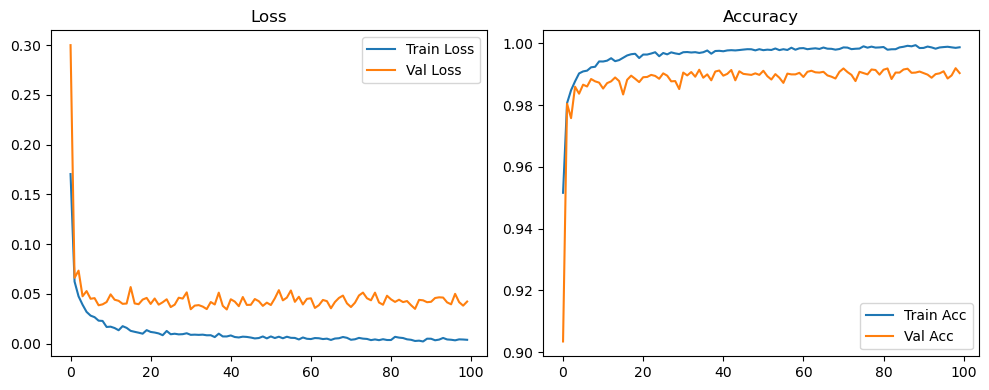

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2666, Acc: 0.9244 | Val Loss: 1.7686, Acc: 0.4323


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1254, Acc: 0.9629 | Val Loss: 0.5656, Acc: 0.8022


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1032, Acc: 0.9688 | Val Loss: 0.7204, Acc: 0.7389


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0911, Acc: 0.9725 | Val Loss: 0.4256, Acc: 0.8461


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9747 | Val Loss: 0.4351, Acc: 0.8439


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9771 | Val Loss: 0.2559, Acc: 0.9147


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0712, Acc: 0.9783 | Val Loss: 0.2737, Acc: 0.9059


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9785 | Val Loss: 0.2621, Acc: 0.9111


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9794 | Val Loss: 0.2880, Acc: 0.9022


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0641, Acc: 0.9813 | Val Loss: 0.2752, Acc: 0.9078


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9804 | Val Loss: 0.2184, Acc: 0.9292


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9826 | Val Loss: 0.1770, Acc: 0.9452


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0566, Acc: 0.9832 | Val Loss: 0.1383, Acc: 0.9573


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0581, Acc: 0.9816 | Val Loss: 0.0995, Acc: 0.9719


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.1151, Acc: 0.9665


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9829 | Val Loss: 0.1636, Acc: 0.9473


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9836 | Val Loss: 0.1769, Acc: 0.9457


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9853 | Val Loss: 0.0796, Acc: 0.9756


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9846 | Val Loss: 0.0994, Acc: 0.9671


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9847 | Val Loss: 0.1143, Acc: 0.9646


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9842 | Val Loss: 0.1493, Acc: 0.9529


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9850 | Val Loss: 0.1255, Acc: 0.9594


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9858 | Val Loss: 0.1044, Acc: 0.9668


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9854 | Val Loss: 0.1393, Acc: 0.9563


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9853 | Val Loss: 0.0864, Acc: 0.9746


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9859 | Val Loss: 0.0811, Acc: 0.9756


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9865 | Val Loss: 0.0886, Acc: 0.9742


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9871 | Val Loss: 0.0817, Acc: 0.9774


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9869 | Val Loss: 0.1396, Acc: 0.9567


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9866 | Val Loss: 0.0878, Acc: 0.9712


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9870 | Val Loss: 0.0882, Acc: 0.9740


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9879 | Val Loss: 0.0824, Acc: 0.9742


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9878 | Val Loss: 0.0979, Acc: 0.9690


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.0745, Acc: 0.9777


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9871 | Val Loss: 0.0929, Acc: 0.9723


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9871 | Val Loss: 0.0748, Acc: 0.9783


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0852, Acc: 0.9737


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9886 | Val Loss: 0.0975, Acc: 0.9708


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9879 | Val Loss: 0.0846, Acc: 0.9756


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0896, Acc: 0.9738


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.0715, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9882 | Val Loss: 0.1253, Acc: 0.9603


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9881 | Val Loss: 0.0926, Acc: 0.9697


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.0835, Acc: 0.9733


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9890 | Val Loss: 0.0690, Acc: 0.9797


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0956, Acc: 0.9685


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.0944, Acc: 0.9698


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9883 | Val Loss: 0.0696, Acc: 0.9792


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9884 | Val Loss: 0.0804, Acc: 0.9753


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0639, Acc: 0.9808


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9881 | Val Loss: 0.0593, Acc: 0.9828


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9894 | Val Loss: 0.0859, Acc: 0.9740


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9890 | Val Loss: 0.0644, Acc: 0.9815


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.0604, Acc: 0.9820


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9895 | Val Loss: 0.0687, Acc: 0.9792


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9895 | Val Loss: 0.0717, Acc: 0.9788


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9901 | Val Loss: 0.0607, Acc: 0.9809


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0619, Acc: 0.9822


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0707, Acc: 0.9780


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.0573, Acc: 0.9823


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.0926, Acc: 0.9698


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.0538, Acc: 0.9835


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.0618, Acc: 0.9827


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9899 | Val Loss: 0.0557, Acc: 0.9852


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0679, Acc: 0.9792


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9898 | Val Loss: 0.0765, Acc: 0.9744


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.0690, Acc: 0.9808


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9903 | Val Loss: 0.0772, Acc: 0.9783


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0796, Acc: 0.9762


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.0616, Acc: 0.9817


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.0637, Acc: 0.9803


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0586, Acc: 0.9828


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.0662, Acc: 0.9812


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.0699, Acc: 0.9786


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9903 | Val Loss: 0.0573, Acc: 0.9856


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0612, Acc: 0.9825


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.0647, Acc: 0.9808


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9903 | Val Loss: 0.0505, Acc: 0.9873


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0615, Acc: 0.9823


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9909 | Val Loss: 0.0586, Acc: 0.9826


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0772, Acc: 0.9761


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0698, Acc: 0.9803


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9909 | Val Loss: 0.0748, Acc: 0.9775


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.0621, Acc: 0.9815


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9910 | Val Loss: 0.0588, Acc: 0.9832


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9914 | Val Loss: 0.0882, Acc: 0.9705


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.0650, Acc: 0.9806


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9911 | Val Loss: 0.0796, Acc: 0.9766


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0615, Acc: 0.9826


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0809, Acc: 0.9752


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0541, Acc: 0.9847


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0689, Acc: 0.9780


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0756, Acc: 0.9769


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0773, Acc: 0.9762


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9919 | Val Loss: 0.0635, Acc: 0.9805


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0645, Acc: 0.9814


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0528, Acc: 0.9855


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0859, Acc: 0.9722


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0732, Acc: 0.9795


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0559, Acc: 0.9849


Final Test Loss: 0.0510 Accuracy: 0.9859


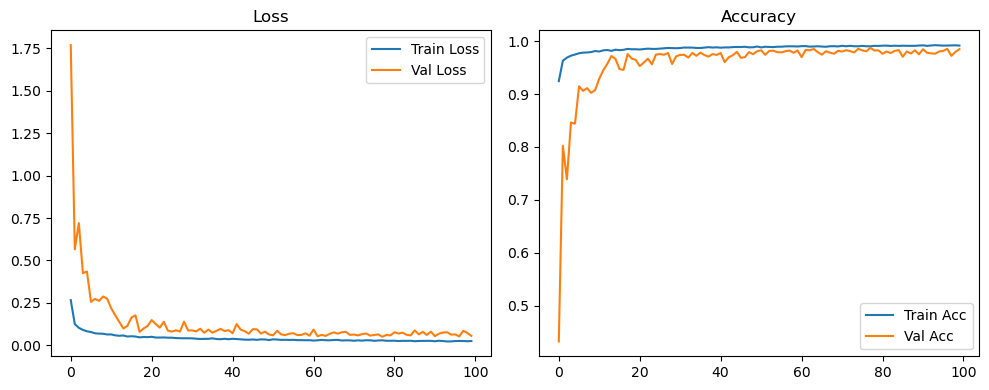

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1404, Acc: 0.9614 | Val Loss: 0.0959, Acc: 0.9712


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 0.0392, Acc: 0.9878


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.0509, Acc: 0.9842


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.0573, Acc: 0.9840


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.0466, Acc: 0.9856


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0401, Acc: 0.9874


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0423, Acc: 0.9882


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0440, Acc: 0.9881


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0411, Acc: 0.9881


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.0543, Acc: 0.9867


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0590, Acc: 0.9850


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0622, Acc: 0.9867


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0434, Acc: 0.9895


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0427, Acc: 0.9906


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0523, Acc: 0.9889


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0501, Acc: 0.9886


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0550, Acc: 0.9875


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0510, Acc: 0.9878


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.0647, Acc: 0.9858


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0505, Acc: 0.9877


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0471, Acc: 0.9893


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0455, Acc: 0.9905


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0390, Acc: 0.9922


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0466, Acc: 0.9906


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0424, Acc: 0.9915


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0546, Acc: 0.9893


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0700, Acc: 0.9857


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0621, Acc: 0.9871


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0424, Acc: 0.9908


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0454, Acc: 0.9900


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0415, Acc: 0.9914


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0452, Acc: 0.9911


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0448, Acc: 0.9908


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0479, Acc: 0.9905


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0458, Acc: 0.9909


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0569, Acc: 0.9886


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0618, Acc: 0.9876


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0893, Acc: 0.9838


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0494, Acc: 0.9901


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0456, Acc: 0.9905


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0436, Acc: 0.9916


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0450, Acc: 0.9914


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0440, Acc: 0.9909


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0442, Acc: 0.9919


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9912


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9913


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9918


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9912


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9918


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1014, Acc: 0.9830


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0524, Acc: 0.9901


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0458, Acc: 0.9909


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9908


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9905


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9909


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9908


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9908


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9911


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9911


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9912


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9914


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9914


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9915


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9908


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9915


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9910


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9917


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9912


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9912


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9914


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9917


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9918


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9918


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9918


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9917


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9913


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9917


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9913


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9914


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0469, Acc: 0.9917


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9919


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9916


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9917


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9918


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9919


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0462, Acc: 0.9918


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9914


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0472, Acc: 0.9919


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9917


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0476, Acc: 0.9918


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9918


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0468, Acc: 0.9918


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9914


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9912


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0474, Acc: 0.9917


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0482, Acc: 0.9917


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0479, Acc: 0.9922


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9918


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9917


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0477, Acc: 0.9917


Final Test Loss: 0.0544 Accuracy: 0.9915


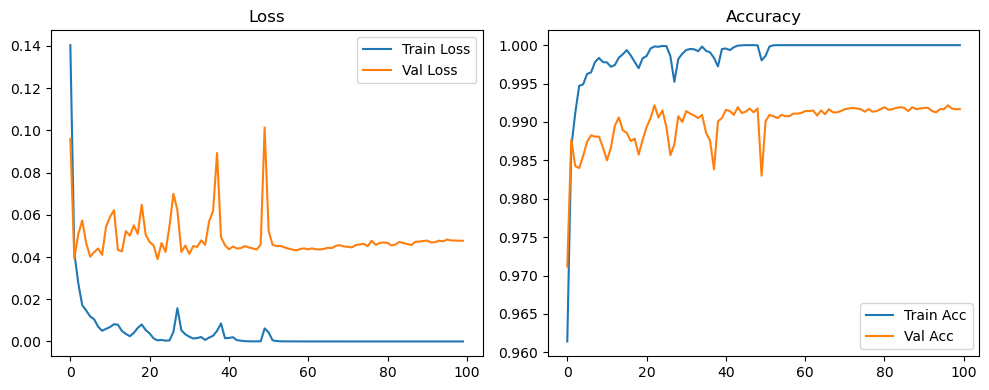

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1702, Acc: 0.9517 | Val Loss: 0.3646, Acc: 0.8820


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9810 | Val Loss: 0.0701, Acc: 0.9778


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9846 | Val Loss: 0.0796, Acc: 0.9747


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9878 | Val Loss: 0.0522, Acc: 0.9844


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0546, Acc: 0.9836


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9905 | Val Loss: 0.0416, Acc: 0.9865


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0512, Acc: 0.9844


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.0452, Acc: 0.9854


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0404, Acc: 0.9888


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0478, Acc: 0.9869


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0402, Acc: 0.9882


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.0434, Acc: 0.9881


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0515, Acc: 0.9849


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0414, Acc: 0.9881


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9944 | Val Loss: 0.0400, Acc: 0.9886


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0509, Acc: 0.9847


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9946 | Val Loss: 0.0409, Acc: 0.9892


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0373, Acc: 0.9892


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0380, Acc: 0.9906


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0386, Acc: 0.9896


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0427, Acc: 0.9881


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9960 | Val Loss: 0.0476, Acc: 0.9878


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0489, Acc: 0.9868


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0451, Acc: 0.9878


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0449, Acc: 0.9870


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9960 | Val Loss: 0.0392, Acc: 0.9900


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0363, Acc: 0.9905


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.0431, Acc: 0.9882


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0430, Acc: 0.9888


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0372, Acc: 0.9896


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0422, Acc: 0.9892


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0639, Acc: 0.9838


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0331, Acc: 0.9907


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0526, Acc: 0.9874


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0348, Acc: 0.9898


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0406, Acc: 0.9897


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0451, Acc: 0.9881


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0383, Acc: 0.9898


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0403, Acc: 0.9902


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0405, Acc: 0.9897


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0372, Acc: 0.9902


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0352, Acc: 0.9910


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0388, Acc: 0.9902


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0399, Acc: 0.9907


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0335, Acc: 0.9912


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0376, Acc: 0.9905


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0429, Acc: 0.9890


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0365, Acc: 0.9913


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9977 | Val Loss: 0.0460, Acc: 0.9890


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0403, Acc: 0.9911


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0377, Acc: 0.9915


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0358, Acc: 0.9918


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0417, Acc: 0.9903


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0335, Acc: 0.9921


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0348, Acc: 0.9916


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0388, Acc: 0.9912


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0379, Acc: 0.9915


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0432, Acc: 0.9910


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0404, Acc: 0.9908


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0384, Acc: 0.9913


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0420, Acc: 0.9910


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0349, Acc: 0.9925


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0373, Acc: 0.9917


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0450, Acc: 0.9902


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0398, Acc: 0.9918


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0385, Acc: 0.9913


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0433, Acc: 0.9902


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0390, Acc: 0.9904


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0408, Acc: 0.9911


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0436, Acc: 0.9904


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0383, Acc: 0.9915


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0440, Acc: 0.9902


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0457, Acc: 0.9908


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0417, Acc: 0.9901


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0452, Acc: 0.9902


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0499, Acc: 0.9906


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0466, Acc: 0.9900


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0402, Acc: 0.9914


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0464, Acc: 0.9903


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0500, Acc: 0.9904


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0460, Acc: 0.9905


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0437, Acc: 0.9918


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0467, Acc: 0.9910


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0424, Acc: 0.9915


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0418, Acc: 0.9914


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0398, Acc: 0.9918


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0408, Acc: 0.9917


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0441, Acc: 0.9917


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0432, Acc: 0.9908


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0448, Acc: 0.9917


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0451, Acc: 0.9916


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0438, Acc: 0.9911


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0413, Acc: 0.9915


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0409, Acc: 0.9918


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0444, Acc: 0.9911


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0431, Acc: 0.9913


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0431, Acc: 0.9912


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0404, Acc: 0.9921


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0396, Acc: 0.9918


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0407, Acc: 0.9921


Final Test Loss: 0.0393 Accuracy: 0.9912


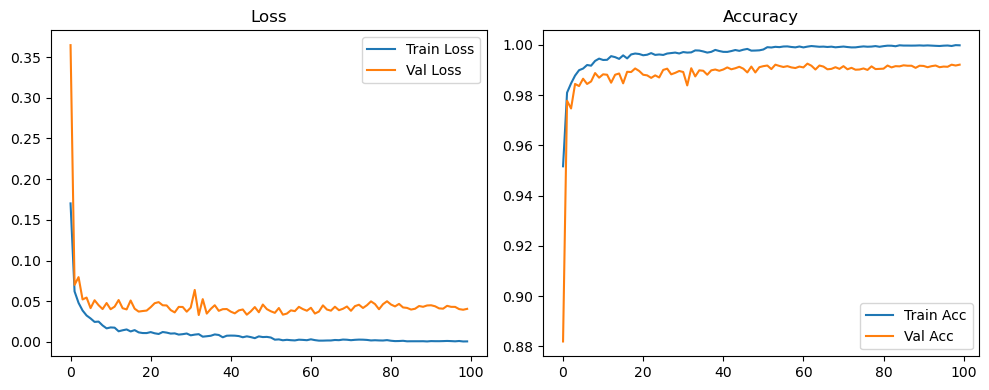

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2670, Acc: 0.9240 | Val Loss: 1.9309, Acc: 0.3860


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1241, Acc: 0.9637 | Val Loss: 0.5198, Acc: 0.8187


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1049, Acc: 0.9682 | Val Loss: 0.5985, Acc: 0.7817


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0893, Acc: 0.9730 | Val Loss: 0.4972, Acc: 0.8175


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0841, Acc: 0.9750 | Val Loss: 0.5955, Acc: 0.7937


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9777 | Val Loss: 0.2691, Acc: 0.9078


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9784 | Val Loss: 0.2529, Acc: 0.9140


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0707, Acc: 0.9783 | Val Loss: 0.2590, Acc: 0.9110


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9814 | Val Loss: 0.2102, Acc: 0.9307


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0627, Acc: 0.9810 | Val Loss: 0.2241, Acc: 0.9286


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9811 | Val Loss: 0.2111, Acc: 0.9324


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9826 | Val Loss: 0.1908, Acc: 0.9428


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9825 | Val Loss: 0.1590, Acc: 0.9519


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0548, Acc: 0.9822 | Val Loss: 0.1507, Acc: 0.9549


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9833 | Val Loss: 0.1667, Acc: 0.9478


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9841 | Val Loss: 0.2113, Acc: 0.9314


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0516, Acc: 0.9846 | Val Loss: 0.2201, Acc: 0.9275


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9849 | Val Loss: 0.1337, Acc: 0.9597


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9844 | Val Loss: 0.1400, Acc: 0.9537


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9849 | Val Loss: 0.1352, Acc: 0.9570


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0489, Acc: 0.9845 | Val Loss: 0.1591, Acc: 0.9502


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9854 | Val Loss: 0.1774, Acc: 0.9417


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9855 | Val Loss: 0.1443, Acc: 0.9550


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9856 | Val Loss: 0.1407, Acc: 0.9554


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9856 | Val Loss: 0.0941, Acc: 0.9712


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 0.1221, Acc: 0.9609


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9870 | Val Loss: 0.1424, Acc: 0.9554


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9868 | Val Loss: 0.0898, Acc: 0.9745


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9874 | Val Loss: 0.1934, Acc: 0.9380


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9874 | Val Loss: 0.0735, Acc: 0.9785


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9868 | Val Loss: 0.1054, Acc: 0.9683


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 0.0981, Acc: 0.9713


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9883 | Val Loss: 0.0910, Acc: 0.9721


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.1031, Acc: 0.9688


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9869 | Val Loss: 0.0934, Acc: 0.9728


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9875 | Val Loss: 0.0902, Acc: 0.9748


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.1109, Acc: 0.9674


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9879 | Val Loss: 0.0880, Acc: 0.9734


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9882 | Val Loss: 0.0784, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.1090, Acc: 0.9667


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9875 | Val Loss: 0.0689, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9883 | Val Loss: 0.1104, Acc: 0.9681


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.0882, Acc: 0.9733


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9887 | Val Loss: 0.0735, Acc: 0.9784


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9889 | Val Loss: 0.0830, Acc: 0.9753


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0760, Acc: 0.9776


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.1032, Acc: 0.9702


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9886 | Val Loss: 0.0615, Acc: 0.9829


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0916, Acc: 0.9722


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9884 | Val Loss: 0.0689, Acc: 0.9793


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0668, Acc: 0.9808


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0682, Acc: 0.9824


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.0616, Acc: 0.9834


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0578, Acc: 0.9845


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9915 | Val Loss: 0.0598, Acc: 0.9828


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9927 | Val Loss: 0.0609, Acc: 0.9825


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0652, Acc: 0.9800


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0649, Acc: 0.9813


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0634, Acc: 0.9810


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0603, Acc: 0.9826


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.0765, Acc: 0.9767


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0535, Acc: 0.9852


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0537, Acc: 0.9843


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.0607, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.0691, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.0625, Acc: 0.9822


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.0560, Acc: 0.9846


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0720, Acc: 0.9798


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.0664, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0541, Acc: 0.9846


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9919 | Val Loss: 0.0674, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0699, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0608, Acc: 0.9820


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0767, Acc: 0.9770


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.0548, Acc: 0.9848


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.0535, Acc: 0.9854


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0592, Acc: 0.9827


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0588, Acc: 0.9830


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0519, Acc: 0.9862


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0627, Acc: 0.9814


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.0563, Acc: 0.9838


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0537, Acc: 0.9853


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0520, Acc: 0.9866


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0481, Acc: 0.9868


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0546, Acc: 0.9847


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9943 | Val Loss: 0.0576, Acc: 0.9828


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9944 | Val Loss: 0.0538, Acc: 0.9842


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0516, Acc: 0.9859


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0510, Acc: 0.9856


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0502, Acc: 0.9867


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0512, Acc: 0.9863


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9942 | Val Loss: 0.0531, Acc: 0.9862


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0557, Acc: 0.9847


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.0559, Acc: 0.9838


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0580, Acc: 0.9823


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.0585, Acc: 0.9827


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0514, Acc: 0.9860


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0544, Acc: 0.9842


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.0527, Acc: 0.9854


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0523, Acc: 0.9852


Final Test Loss: 0.0480 Accuracy: 0.9854


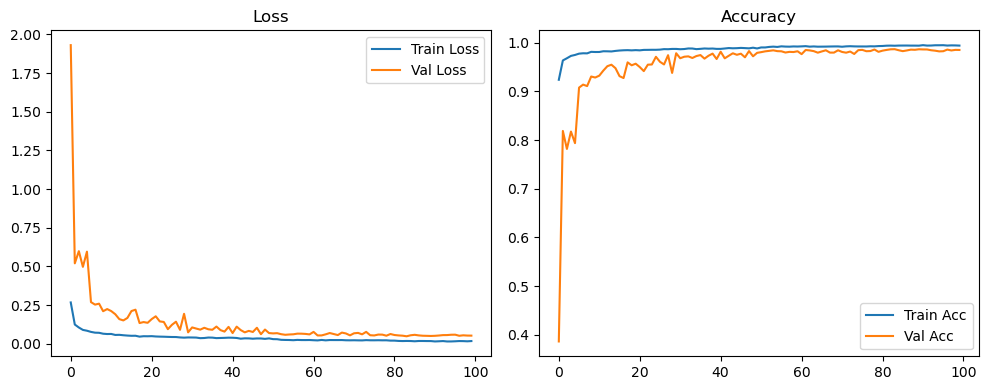

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1400, Acc: 0.9617 | Val Loss: 0.1024, Acc: 0.9688


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9866 | Val Loss: 0.0406, Acc: 0.9886


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9916 | Val Loss: 0.0485, Acc: 0.9852


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9937 | Val Loss: 0.0602, Acc: 0.9827


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0406, Acc: 0.9878


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0501, Acc: 0.9851


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0449, Acc: 0.9878


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0384, Acc: 0.9908


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0560, Acc: 0.9866


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0489, Acc: 0.9874


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0641, Acc: 0.9851


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0732, Acc: 0.9824


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0508, Acc: 0.9879


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0458, Acc: 0.9898


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0386, Acc: 0.9911


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0446, Acc: 0.9904


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0485, Acc: 0.9885


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0669, Acc: 0.9846


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0603, Acc: 0.9860


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0521, Acc: 0.9882


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0456, Acc: 0.9896


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0583, Acc: 0.9884


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0491, Acc: 0.9889


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0497, Acc: 0.9892


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0460, Acc: 0.9909


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0452, Acc: 0.9908


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0423, Acc: 0.9918


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9912


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9919


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0429, Acc: 0.9917


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9922


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9922


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9925


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0425, Acc: 0.9922


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9925


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0437, Acc: 0.9922


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9928


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9922


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9923


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9927


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9920


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0435, Acc: 0.9923


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0439, Acc: 0.9925


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9925


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0631, Acc: 0.9877


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9874 | Val Loss: 0.0406, Acc: 0.9889


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0347, Acc: 0.9922


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0384, Acc: 0.9906


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0354, Acc: 0.9923


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9917


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0359, Acc: 0.9921


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9925


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9927


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9923


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9925


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9923


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9923


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9923


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9922


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9927


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9924


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0388, Acc: 0.9927


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9925


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9923


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9926


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9928


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9928


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9926


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9916


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0615, Acc: 0.9879


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0476, Acc: 0.9910


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0498, Acc: 0.9907


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0482, Acc: 0.9914


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0495, Acc: 0.9904


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9918


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9921


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9921


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9924


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9922


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9921


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9922


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9923


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9924


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9921


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9923


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9921


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9922


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9920


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9925


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0466, Acc: 0.9920


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9926


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0458, Acc: 0.9924


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9925


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0461, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9923


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9922


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9923


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0457, Acc: 0.9924


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9922


Final Test Loss: 0.0481 Accuracy: 0.9917


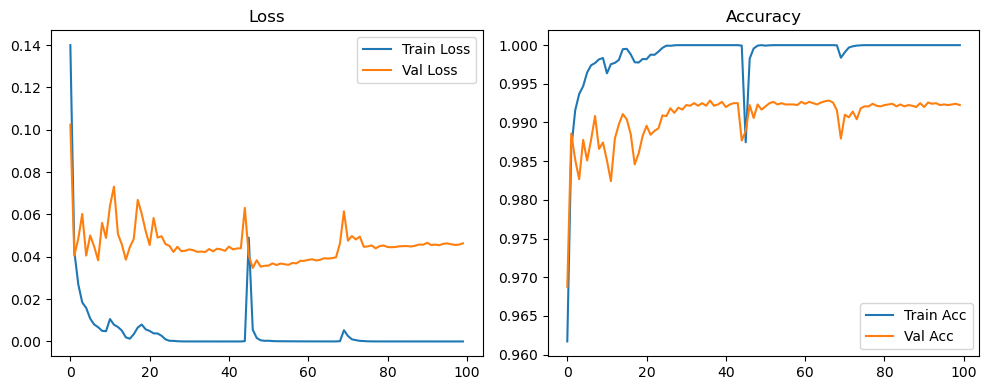

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1704, Acc: 0.9518 | Val Loss: 0.3276, Acc: 0.8917


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0623, Acc: 0.9807 | Val Loss: 0.0650, Acc: 0.9801


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9851 | Val Loss: 0.0711, Acc: 0.9770


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 0.0506, Acc: 0.9848


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9898 | Val Loss: 0.0570, Acc: 0.9813


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9914 | Val Loss: 0.0449, Acc: 0.9868


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9919 | Val Loss: 0.0457, Acc: 0.9853


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0427, Acc: 0.9882


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0448, Acc: 0.9876


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.0555, Acc: 0.9833


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0424, Acc: 0.9880


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0382, Acc: 0.9878


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9949 | Val Loss: 0.0514, Acc: 0.9861


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9941 | Val Loss: 0.0516, Acc: 0.9858


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0452, Acc: 0.9865


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9947 | Val Loss: 0.0442, Acc: 0.9870


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0462, Acc: 0.9878


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9960 | Val Loss: 0.0461, Acc: 0.9873


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0467, Acc: 0.9881


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0455, Acc: 0.9873


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0366, Acc: 0.9892


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.0507, Acc: 0.9871


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0448, Acc: 0.9880


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0527, Acc: 0.9856


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0534, Acc: 0.9857


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.0431, Acc: 0.9895


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0440, Acc: 0.9884


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0512, Acc: 0.9872


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0499, Acc: 0.9873


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9953 | Val Loss: 0.0460, Acc: 0.9883


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0418, Acc: 0.9898


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0474, Acc: 0.9876


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0375, Acc: 0.9903


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0435, Acc: 0.9891


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0402, Acc: 0.9898


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0424, Acc: 0.9902


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0429, Acc: 0.9898


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0413, Acc: 0.9902


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0434, Acc: 0.9908


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0396, Acc: 0.9901


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0411, Acc: 0.9889


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0391, Acc: 0.9908


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0487, Acc: 0.9888


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0412, Acc: 0.9888


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0425, Acc: 0.9895


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0436, Acc: 0.9896


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0426, Acc: 0.9901


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0420, Acc: 0.9900


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0394, Acc: 0.9908


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0359, Acc: 0.9904


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0353, Acc: 0.9914


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0391, Acc: 0.9907


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0402, Acc: 0.9902


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0363, Acc: 0.9921


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0400, Acc: 0.9908


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0366, Acc: 0.9913


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9991 | Val Loss: 0.0400, Acc: 0.9919


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0380, Acc: 0.9910


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0405, Acc: 0.9922


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0386, Acc: 0.9916


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0427, Acc: 0.9908


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0415, Acc: 0.9914


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0453, Acc: 0.9912


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0445, Acc: 0.9918


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0458, Acc: 0.9908


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0435, Acc: 0.9918


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0432, Acc: 0.9920


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0423, Acc: 0.9915


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0492, Acc: 0.9904


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0484, Acc: 0.9902


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0442, Acc: 0.9912


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0460, Acc: 0.9913


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0506, Acc: 0.9904


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0543, Acc: 0.9893


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0491, Acc: 0.9892


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0484, Acc: 0.9898


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0469, Acc: 0.9910


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0441, Acc: 0.9912


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0465, Acc: 0.9903


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0459, Acc: 0.9913


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0448, Acc: 0.9917


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0427, Acc: 0.9915


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0430, Acc: 0.9921


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0430, Acc: 0.9922


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0424, Acc: 0.9918


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0417, Acc: 0.9921


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0405, Acc: 0.9924


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0416, Acc: 0.9922


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0417, Acc: 0.9926


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0414, Acc: 0.9923


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0434, Acc: 0.9919


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0416, Acc: 0.9920


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0416, Acc: 0.9919


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0413, Acc: 0.9921


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0439, Acc: 0.9916


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0433, Acc: 0.9919


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0451, Acc: 0.9914


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0430, Acc: 0.9918


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0416, Acc: 0.9920


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0400, Acc: 0.9917


Final Test Loss: 0.0384 Accuracy: 0.9916


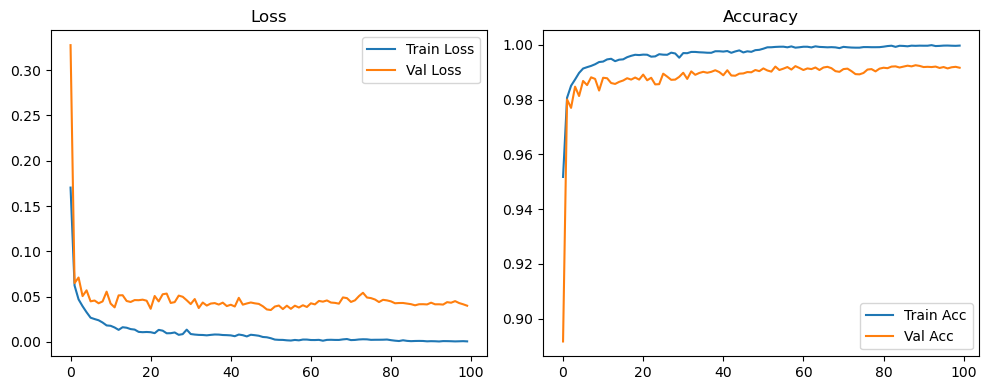

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2668, Acc: 0.9241 | Val Loss: 1.8610, Acc: 0.3986


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1238, Acc: 0.9633 | Val Loss: 0.5047, Acc: 0.8271


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1041, Acc: 0.9687 | Val Loss: 0.7777, Acc: 0.7228


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0904, Acc: 0.9730 | Val Loss: 0.5765, Acc: 0.7992


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0834, Acc: 0.9751 | Val Loss: 0.3413, Acc: 0.8814


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9767 | Val Loss: 0.2518, Acc: 0.9160


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9776 | Val Loss: 0.2829, Acc: 0.9022


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0691, Acc: 0.9789 | Val Loss: 0.3939, Acc: 0.8631


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0669, Acc: 0.9797 | Val Loss: 0.1683, Acc: 0.9497


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0637, Acc: 0.9802 | Val Loss: 0.2474, Acc: 0.9200


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0650, Acc: 0.9806 | Val Loss: 0.2216, Acc: 0.9272


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9814 | Val Loss: 0.2350, Acc: 0.9209


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0567, Acc: 0.9825 | Val Loss: 0.1585, Acc: 0.9515


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0551, Acc: 0.9832 | Val Loss: 0.1310, Acc: 0.9618


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9834 | Val Loss: 0.2295, Acc: 0.9250


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9834 | Val Loss: 0.1927, Acc: 0.9363


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9839 | Val Loss: 0.1603, Acc: 0.9495


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9847 | Val Loss: 0.0859, Acc: 0.9748


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0504, Acc: 0.9839 | Val Loss: 0.1342, Acc: 0.9573


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.1700, Acc: 0.9463


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9844 | Val Loss: 0.1865, Acc: 0.9400


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9849 | Val Loss: 0.2204, Acc: 0.9283


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.1057, Acc: 0.9662


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9851 | Val Loss: 0.1250, Acc: 0.9613


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9857 | Val Loss: 0.1935, Acc: 0.9352


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9864 | Val Loss: 0.1200, Acc: 0.9631


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9864 | Val Loss: 0.1027, Acc: 0.9708


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9864 | Val Loss: 0.1163, Acc: 0.9660


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9871 | Val Loss: 0.1572, Acc: 0.9504


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9860 | Val Loss: 0.0907, Acc: 0.9738


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9870 | Val Loss: 0.1145, Acc: 0.9657


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 0.1259, Acc: 0.9612


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9885 | Val Loss: 0.1172, Acc: 0.9637


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9883 | Val Loss: 0.0769, Acc: 0.9769


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9881 | Val Loss: 0.1226, Acc: 0.9626


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9878 | Val Loss: 0.1028, Acc: 0.9697


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9878 | Val Loss: 0.0931, Acc: 0.9707


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9879 | Val Loss: 0.0965, Acc: 0.9696


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9889 | Val Loss: 0.0706, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9877 | Val Loss: 0.1199, Acc: 0.9631


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9872 | Val Loss: 0.0819, Acc: 0.9753


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.1307, Acc: 0.9578


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.0813, Acc: 0.9740


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0747, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9888 | Val Loss: 0.0843, Acc: 0.9754


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0971, Acc: 0.9701


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9892 | Val Loss: 0.1067, Acc: 0.9668


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0336, Acc: 0.9888 | Val Loss: 0.0816, Acc: 0.9735


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.1048, Acc: 0.9668


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0647, Acc: 0.9798


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.0706, Acc: 0.9782


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0757, Acc: 0.9762


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.0700, Acc: 0.9791


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0644, Acc: 0.9816


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0637, Acc: 0.9809


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.0652, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0831, Acc: 0.9753


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0722, Acc: 0.9769


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0703, Acc: 0.9783


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.0645, Acc: 0.9813


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.0735, Acc: 0.9769


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0707, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9923 | Val Loss: 0.0729, Acc: 0.9768


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0685, Acc: 0.9783


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0790, Acc: 0.9758


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0676, Acc: 0.9783


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.0685, Acc: 0.9789


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.0722, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.0710, Acc: 0.9776


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0646, Acc: 0.9794


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0616, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.0670, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0652, Acc: 0.9803


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0771, Acc: 0.9764


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9922 | Val Loss: 0.0609, Acc: 0.9819


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.0634, Acc: 0.9806


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0614, Acc: 0.9806


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0672, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0735, Acc: 0.9781


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.0768, Acc: 0.9765


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0733, Acc: 0.9780


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9942 | Val Loss: 0.0640, Acc: 0.9804


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9943 | Val Loss: 0.0616, Acc: 0.9821


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9936 | Val Loss: 0.0596, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.0602, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0634, Acc: 0.9806


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0585, Acc: 0.9830


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9941 | Val Loss: 0.0600, Acc: 0.9814


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0599, Acc: 0.9819


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0624, Acc: 0.9816


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0685, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0614, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0640, Acc: 0.9811


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9946 | Val Loss: 0.0645, Acc: 0.9810


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0635, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0642, Acc: 0.9807


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0577, Acc: 0.9829


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0653, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0575, Acc: 0.9837


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.0607, Acc: 0.9828


Final Test Loss: 0.0585 Accuracy: 0.9809


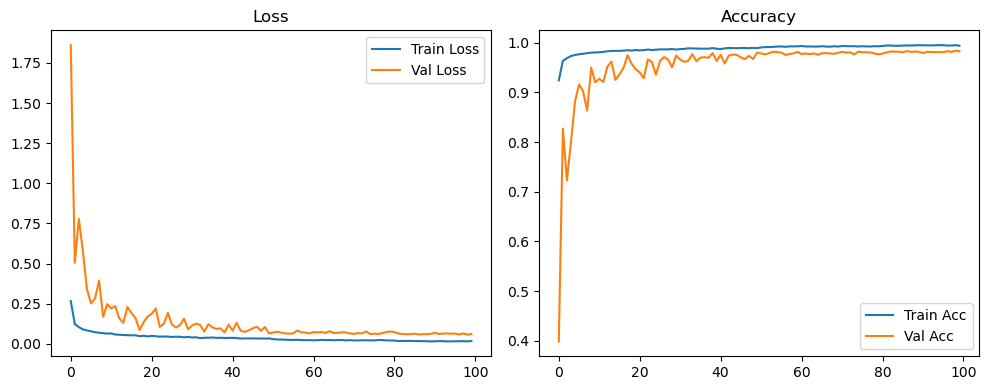

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1401, Acc: 0.9616 | Val Loss: 0.0990, Acc: 0.9697


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9865 | Val Loss: 0.0415, Acc: 0.9877


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0440, Acc: 0.9865


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0595, Acc: 0.9826


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.0481, Acc: 0.9859


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0412, Acc: 0.9880


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0392, Acc: 0.9899


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0484, Acc: 0.9868


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.0537, Acc: 0.9871


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0475, Acc: 0.9878


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0888, Acc: 0.9767


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0397, Acc: 0.9892


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0534, Acc: 0.9881


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0552, Acc: 0.9876


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0566, Acc: 0.9878


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0489, Acc: 0.9892


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0567, Acc: 0.9881


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0514, Acc: 0.9892


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0749, Acc: 0.9825


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0606, Acc: 0.9857


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0579, Acc: 0.9879


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0607, Acc: 0.9871


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0523, Acc: 0.9889


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0547, Acc: 0.9892


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0524, Acc: 0.9888


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0424, Acc: 0.9918


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0516, Acc: 0.9903


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0550, Acc: 0.9908


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0512, Acc: 0.9892


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0741, Acc: 0.9862


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0584, Acc: 0.9888


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0601, Acc: 0.9892


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0527, Acc: 0.9899


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0642, Acc: 0.9874


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9830


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0597, Acc: 0.9890


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0546, Acc: 0.9902


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0555, Acc: 0.9913


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0572, Acc: 0.9907


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0647, Acc: 0.9884


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0565, Acc: 0.9892


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0652, Acc: 0.9886


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0610, Acc: 0.9888


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0578, Acc: 0.9905


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0561, Acc: 0.9895


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0561, Acc: 0.9905


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0578, Acc: 0.9902


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9912


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9912


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9913


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9914


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9912


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9912


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0527, Acc: 0.9913


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9914


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9914


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9912


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9913


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9916


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9914


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9913


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9915


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9913


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9912


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9915


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9912


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9913


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0524, Acc: 0.9913


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9914


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0520, Acc: 0.9912


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0518, Acc: 0.9912


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0519, Acc: 0.9912


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0523, Acc: 0.9915


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0531, Acc: 0.9912


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0530, Acc: 0.9916


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9913


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0532, Acc: 0.9916


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0525, Acc: 0.9912


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0526, Acc: 0.9912


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9916


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0522, Acc: 0.9914


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0516, Acc: 0.9912


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0521, Acc: 0.9912


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0528, Acc: 0.9915


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0533, Acc: 0.9916


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9915


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0529, Acc: 0.9914


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0533, Acc: 0.9914


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9916


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9915


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9917


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9916


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0535, Acc: 0.9913


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0536, Acc: 0.9914


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0544, Acc: 0.9918


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0544, Acc: 0.9917


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0538, Acc: 0.9916


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0541, Acc: 0.9912


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0545, Acc: 0.9915


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0549, Acc: 0.9915


Final Test Loss: 0.0521 Accuracy: 0.9915


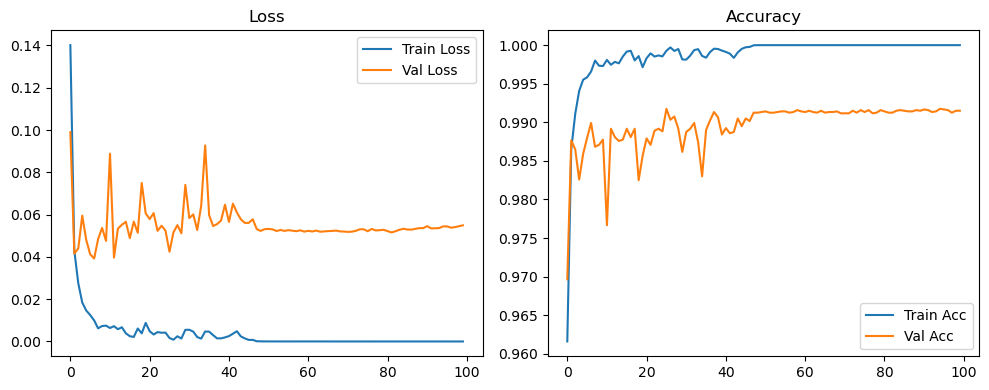

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.1702, Acc: 0.9518 | Val Loss: 0.3378, Acc: 0.8898


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9807 | Val Loss: 0.0651, Acc: 0.9808


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9844 | Val Loss: 0.0726, Acc: 0.9771


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0539, Acc: 0.9828


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9900 | Val Loss: 0.0498, Acc: 0.9845


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.0399, Acc: 0.9885


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0445, Acc: 0.9860


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0394, Acc: 0.9888


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0470, Acc: 0.9864


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9936 | Val Loss: 0.0521, Acc: 0.9845


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9935 | Val Loss: 0.0526, Acc: 0.9842


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0456, Acc: 0.9866


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0530, Acc: 0.9841


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0387, Acc: 0.9887


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0439, Acc: 0.9872


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0445, Acc: 0.9883


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0406, Acc: 0.9889


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 0.0440, Acc: 0.9877


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0429, Acc: 0.9875


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9949 | Val Loss: 0.0384, Acc: 0.9888


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0380, Acc: 0.9896


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0394, Acc: 0.9898


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0351, Acc: 0.9903


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0450, Acc: 0.9876


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0414, Acc: 0.9897


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0318, Acc: 0.9914


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0375, Acc: 0.9891


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.0431, Acc: 0.9877


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0481, Acc: 0.9872


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0474, Acc: 0.9878


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0379, Acc: 0.9900


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.0338, Acc: 0.9909


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0364, Acc: 0.9905


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.0399, Acc: 0.9905


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9971 | Val Loss: 0.0373, Acc: 0.9908


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0391, Acc: 0.9894


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9964 | Val Loss: 0.0395, Acc: 0.9892


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0498, Acc: 0.9870


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0483, Acc: 0.9877


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0370, Acc: 0.9898


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0364, Acc: 0.9896


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0328, Acc: 0.9915


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0386, Acc: 0.9895


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0420, Acc: 0.9892


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9975 | Val Loss: 0.0450, Acc: 0.9891


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0502, Acc: 0.9874


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0499, Acc: 0.9872


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.0431, Acc: 0.9897


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0518, Acc: 0.9883


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0356, Acc: 0.9909


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0350, Acc: 0.9916


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0343, Acc: 0.9912


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0347, Acc: 0.9918


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0358, Acc: 0.9914


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0367, Acc: 0.9914


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0356, Acc: 0.9914


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0349, Acc: 0.9921


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0355, Acc: 0.9913


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0356, Acc: 0.9919


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0373, Acc: 0.9918


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0373, Acc: 0.9911


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0394, Acc: 0.9908


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0367, Acc: 0.9915


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0362, Acc: 0.9922


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0399, Acc: 0.9916


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0377, Acc: 0.9921


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0394, Acc: 0.9914


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0366, Acc: 0.9919


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0371, Acc: 0.9917


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0358, Acc: 0.9925


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0368, Acc: 0.9924


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0378, Acc: 0.9918


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0380, Acc: 0.9922


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0420, Acc: 0.9908


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0388, Acc: 0.9911


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0371, Acc: 0.9912


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0377, Acc: 0.9921


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0356, Acc: 0.9922


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0379, Acc: 0.9915


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0395, Acc: 0.9908


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0374, Acc: 0.9917


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0367, Acc: 0.9921


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0373, Acc: 0.9922


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0371, Acc: 0.9916


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0369, Acc: 0.9920


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0360, Acc: 0.9925


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0351, Acc: 0.9929


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0362, Acc: 0.9926


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0365, Acc: 0.9922


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0379, Acc: 0.9922


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0408, Acc: 0.9920


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0397, Acc: 0.9915


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0415, Acc: 0.9914


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0414, Acc: 0.9915


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0403, Acc: 0.9913


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0404, Acc: 0.9915


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0404, Acc: 0.9921


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0405, Acc: 0.9923


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0387, Acc: 0.9918


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0374, Acc: 0.9924


Final Test Loss: 0.0404 Accuracy: 0.9901


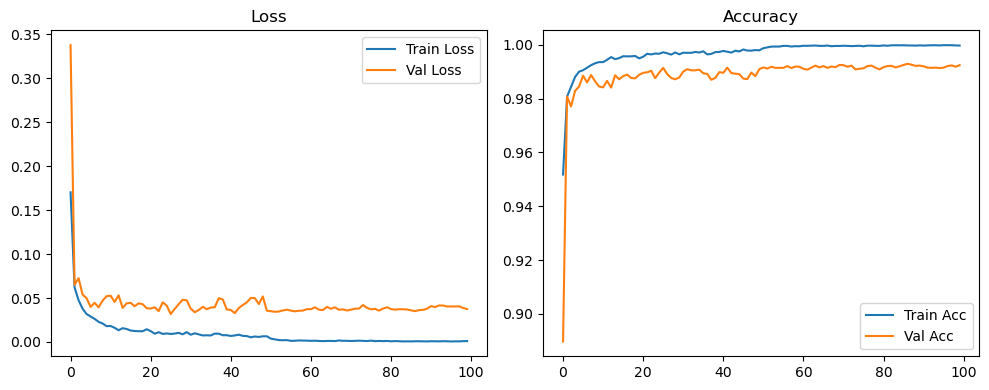

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2664, Acc: 0.9241 | Val Loss: 1.8135, Acc: 0.4071


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1257, Acc: 0.9633 | Val Loss: 0.3918, Acc: 0.8722


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9689 | Val Loss: 0.5862, Acc: 0.7903


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0896, Acc: 0.9728 | Val Loss: 0.4565, Acc: 0.8391


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9748 | Val Loss: 0.3080, Acc: 0.8958


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0792, Acc: 0.9764 | Val Loss: 0.2718, Acc: 0.9086


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9783 | Val Loss: 0.1935, Acc: 0.9360


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0715, Acc: 0.9779 | Val Loss: 0.3095, Acc: 0.8947


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9793 | Val Loss: 0.1896, Acc: 0.9398


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9805 | Val Loss: 0.2163, Acc: 0.9298


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0629, Acc: 0.9803 | Val Loss: 0.1867, Acc: 0.9388


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0579, Acc: 0.9817 | Val Loss: 0.1645, Acc: 0.9479


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9824 | Val Loss: 0.1218, Acc: 0.9625


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0571, Acc: 0.9825 | Val Loss: 0.1167, Acc: 0.9664


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9832 | Val Loss: 0.1511, Acc: 0.9526


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9843 | Val Loss: 0.1845, Acc: 0.9417


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9839 | Val Loss: 0.1830, Acc: 0.9427


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9849 | Val Loss: 0.1373, Acc: 0.9564


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9839 | Val Loss: 0.1315, Acc: 0.9581


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9843 | Val Loss: 0.1198, Acc: 0.9626


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.1430, Acc: 0.9537


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9852 | Val Loss: 0.1356, Acc: 0.9553


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9856 | Val Loss: 0.1017, Acc: 0.9678


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9850 | Val Loss: 0.1306, Acc: 0.9603


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0468, Acc: 0.9852 | Val Loss: 0.1100, Acc: 0.9672


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9861 | Val Loss: 0.1034, Acc: 0.9674


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9865 | Val Loss: 0.1272, Acc: 0.9626


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9865 | Val Loss: 0.0940, Acc: 0.9731


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9876 | Val Loss: 0.1732, Acc: 0.9455


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0717, Acc: 0.9791


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.0913, Acc: 0.9717


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.1021, Acc: 0.9671


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.1346, Acc: 0.9556


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9878 | Val Loss: 0.0822, Acc: 0.9747


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.1111, Acc: 0.9658


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.0956, Acc: 0.9695


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9872 | Val Loss: 0.1122, Acc: 0.9670


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.1017, Acc: 0.9673


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9881 | Val Loss: 0.0844, Acc: 0.9745


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9870 | Val Loss: 0.0986, Acc: 0.9694


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.0762, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0359, Acc: 0.9880 | Val Loss: 0.1112, Acc: 0.9650


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.0805, Acc: 0.9762


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0844, Acc: 0.9746


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9895 | Val Loss: 0.0653, Acc: 0.9798


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9890 | Val Loss: 0.0763, Acc: 0.9766


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9894 | Val Loss: 0.1085, Acc: 0.9656


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.0758, Acc: 0.9758


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9896 | Val Loss: 0.0978, Acc: 0.9698


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.0795, Acc: 0.9756


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0631, Acc: 0.9805


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0687, Acc: 0.9791


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0589, Acc: 0.9821


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.0561, Acc: 0.9833


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.0601, Acc: 0.9814


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9922 | Val Loss: 0.0632, Acc: 0.9807


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0624, Acc: 0.9805


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.0618, Acc: 0.9803


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.0589, Acc: 0.9817


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0603, Acc: 0.9810


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0726, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0690, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.0618, Acc: 0.9810


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0606, Acc: 0.9821


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.0669, Acc: 0.9794


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0638, Acc: 0.9801


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9932 | Val Loss: 0.0595, Acc: 0.9824


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0582, Acc: 0.9832


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0531, Acc: 0.9839


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.0526, Acc: 0.9843


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0561, Acc: 0.9840


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0628, Acc: 0.9822


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0595, Acc: 0.9827


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0605, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0588, Acc: 0.9833


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9932 | Val Loss: 0.0511, Acc: 0.9852


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9932 | Val Loss: 0.0571, Acc: 0.9832


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0545, Acc: 0.9834


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0532, Acc: 0.9842


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9938 | Val Loss: 0.0551, Acc: 0.9830


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0561, Acc: 0.9834


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0527, Acc: 0.9845


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0587, Acc: 0.9820


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9941 | Val Loss: 0.0557, Acc: 0.9837


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0529, Acc: 0.9851


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0557, Acc: 0.9833


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.0541, Acc: 0.9842


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0540, Acc: 0.9843


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0505, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0529, Acc: 0.9854


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0569, Acc: 0.9835


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9939 | Val Loss: 0.0515, Acc: 0.9854


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.0576, Acc: 0.9843


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9942 | Val Loss: 0.0566, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0527, Acc: 0.9851


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0517, Acc: 0.9854


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0476, Acc: 0.9861


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0550, Acc: 0.9842


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9942 | Val Loss: 0.0501, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9943 | Val Loss: 0.0498, Acc: 0.9852


Final Test Loss: 0.0483 Accuracy: 0.9848


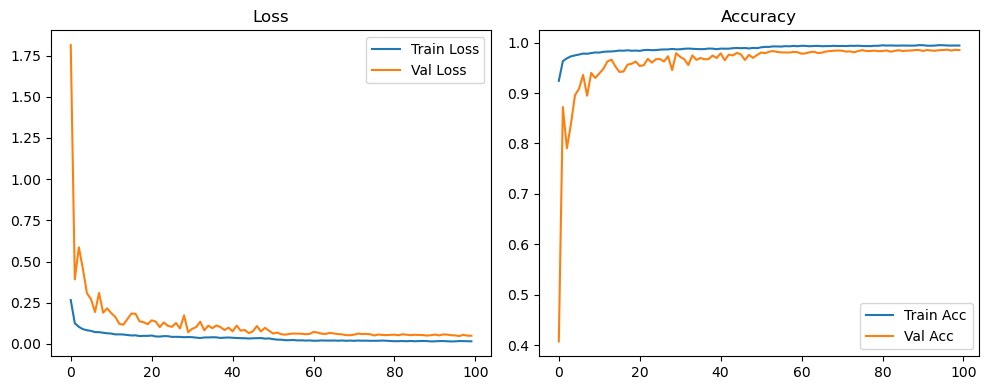

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1553, Acc: 0.9635 | Val Loss: 0.0849, Acc: 0.9732


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9873 | Val Loss: 0.0389, Acc: 0.9873


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0456, Acc: 0.9850


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.0470, Acc: 0.9852


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0428, Acc: 0.9868


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0376, Acc: 0.9881


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9987 | Val Loss: 0.0357, Acc: 0.9902


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0457, Acc: 0.9874


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0393, Acc: 0.9887


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0599, Acc: 0.9828


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0560, Acc: 0.9856


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0375, Acc: 0.9906


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0356, Acc: 0.9910


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0383, Acc: 0.9908


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0560, Acc: 0.9869


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0443, Acc: 0.9892


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0374, Acc: 0.9901


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.0341, Acc: 0.9918


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0347, Acc: 0.9908


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9919


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9922


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9922


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0336, Acc: 0.9922


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9924


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9926


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9926


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9923


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9922


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9921


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9923


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0519, Acc: 0.9862


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.0427, Acc: 0.9884


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0320, Acc: 0.9912


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0305, Acc: 0.9924


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.0301, Acc: 0.9923


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0304, Acc: 0.9927


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0302, Acc: 0.9924


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9929


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0309, Acc: 0.9923


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0306, Acc: 0.9927


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0317, Acc: 0.9926


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9928


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0320, Acc: 0.9922


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0325, Acc: 0.9925


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0607, Acc: 0.9840


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0402, Acc: 0.9899


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0372, Acc: 0.9917


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0331, Acc: 0.9918


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9924


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9923


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9927


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0329, Acc: 0.9925


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9929


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9928


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9929


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0331, Acc: 0.9929


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0337, Acc: 0.9932


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0332, Acc: 0.9931


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9928


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0339, Acc: 0.9932


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9932


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0346, Acc: 0.9932


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0344, Acc: 0.9932


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9932


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0356, Acc: 0.9932


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0351, Acc: 0.9932


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9932


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9932


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9933


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9932


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9935


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9932


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9933


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9932


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9935


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0364, Acc: 0.9934


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9932


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9936


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9937


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9933


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9935


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9935


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9934


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9927 | Val Loss: 0.0481, Acc: 0.9885


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0424, Acc: 0.9898


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0376, Acc: 0.9908


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9916


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9924


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0360, Acc: 0.9918


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0359, Acc: 0.9918


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9923


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9922


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9921


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9919


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9922


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0371, Acc: 0.9922


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9921


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0374, Acc: 0.9922


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9922


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0377, Acc: 0.9922


Final Test Loss: 0.0430 Accuracy: 0.9914


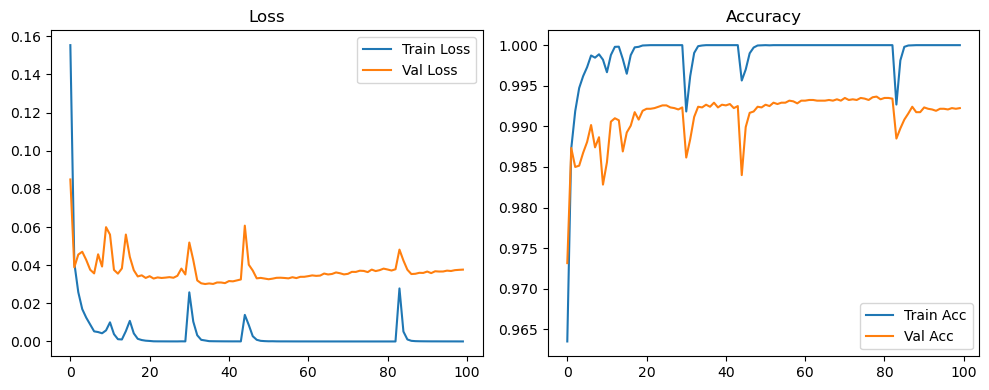

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1847, Acc: 0.9550 | Val Loss: 0.2470, Acc: 0.9208


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9817 | Val Loss: 0.0758, Acc: 0.9772


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9850 | Val Loss: 0.0797, Acc: 0.9742


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0383, Acc: 0.9880 | Val Loss: 0.0563, Acc: 0.9828


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0522, Acc: 0.9846


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0378, Acc: 0.9892


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0509, Acc: 0.9843


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0505, Acc: 0.9843


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0398, Acc: 0.9890


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0404, Acc: 0.9888


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0405, Acc: 0.9882


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9943 | Val Loss: 0.0366, Acc: 0.9900


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0463, Acc: 0.9879


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0402, Acc: 0.9888


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0433, Acc: 0.9872


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0438, Acc: 0.9872


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0352, Acc: 0.9913


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0353, Acc: 0.9912


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0389, Acc: 0.9898


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0390, Acc: 0.9894


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.0318, Acc: 0.9912


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0384, Acc: 0.9896


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0407, Acc: 0.9884


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0390, Acc: 0.9892


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0394, Acc: 0.9903


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0368, Acc: 0.9896


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0342, Acc: 0.9908


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0411, Acc: 0.9896


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0387, Acc: 0.9902


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0348, Acc: 0.9904


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0349, Acc: 0.9907


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0369, Acc: 0.9906


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0376, Acc: 0.9903


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0440, Acc: 0.9894


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0394, Acc: 0.9894


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0436, Acc: 0.9890


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0396, Acc: 0.9897


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0374, Acc: 0.9908


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0429, Acc: 0.9895


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0341, Acc: 0.9912


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0397, Acc: 0.9899


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0416, Acc: 0.9899


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0388, Acc: 0.9891


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0352, Acc: 0.9908


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0415, Acc: 0.9900


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0479, Acc: 0.9892


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0462, Acc: 0.9884


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0424, Acc: 0.9910


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0436, Acc: 0.9892


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0442, Acc: 0.9898


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0381, Acc: 0.9907


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0409, Acc: 0.9898


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0390, Acc: 0.9901


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0366, Acc: 0.9915


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0440, Acc: 0.9904


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0388, Acc: 0.9901


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0415, Acc: 0.9904


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0450, Acc: 0.9892


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0433, Acc: 0.9892


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0515, Acc: 0.9895


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0463, Acc: 0.9892


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0439, Acc: 0.9900


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0420, Acc: 0.9906


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0478, Acc: 0.9892


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0426, Acc: 0.9898


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0373, Acc: 0.9908


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0445, Acc: 0.9907


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0355, Acc: 0.9908


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0417, Acc: 0.9908


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0395, Acc: 0.9908


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0397, Acc: 0.9901


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0403, Acc: 0.9914


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0441, Acc: 0.9904


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0389, Acc: 0.9909


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0428, Acc: 0.9905


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0385, Acc: 0.9920


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0415, Acc: 0.9911


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0411, Acc: 0.9916


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0454, Acc: 0.9910


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0418, Acc: 0.9909


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0403, Acc: 0.9913


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0399, Acc: 0.9920


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0400, Acc: 0.9914


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0401, Acc: 0.9912


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.0411, Acc: 0.9912


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0455, Acc: 0.9908


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0435, Acc: 0.9908


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0452, Acc: 0.9903


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0422, Acc: 0.9912


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0478, Acc: 0.9898


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0394, Acc: 0.9908


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0518, Acc: 0.9894


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0471, Acc: 0.9897


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0458, Acc: 0.9906


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0443, Acc: 0.9902


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0471, Acc: 0.9900


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0479, Acc: 0.9902


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0504, Acc: 0.9894


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0408, Acc: 0.9905


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0420, Acc: 0.9915


Final Test Loss: 0.0465 Accuracy: 0.9894


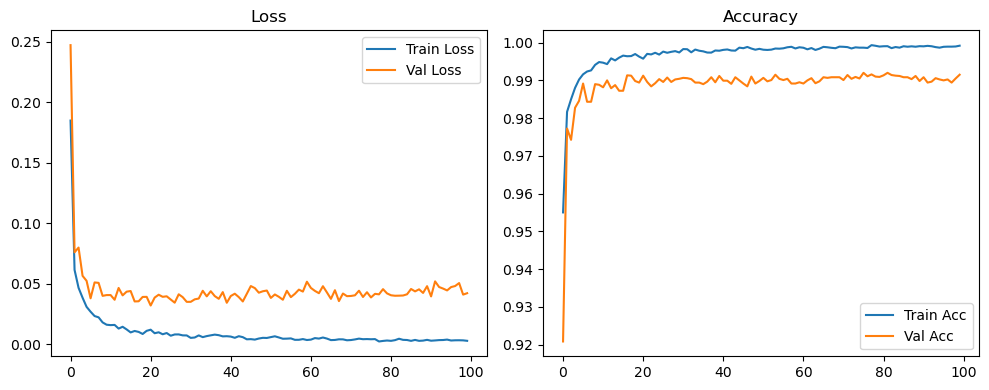

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2857, Acc: 0.9252 | Val Loss: 1.7492, Acc: 0.4253


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1235, Acc: 0.9643 | Val Loss: 0.5051, Acc: 0.8138


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1021, Acc: 0.9703 | Val Loss: 0.6857, Acc: 0.7468


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9746 | Val Loss: 0.4696, Acc: 0.8271


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0804, Acc: 0.9764 | Val Loss: 0.2298, Acc: 0.9224


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0765, Acc: 0.9768 | Val Loss: 0.2030, Acc: 0.9347


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9797 | Val Loss: 0.1740, Acc: 0.9428


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0642, Acc: 0.9804 | Val Loss: 0.2887, Acc: 0.8949


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0634, Acc: 0.9809 | Val Loss: 0.1817, Acc: 0.9414


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9820 | Val Loss: 0.1862, Acc: 0.9387


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0594, Acc: 0.9818 | Val Loss: 0.1659, Acc: 0.9463


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0535, Acc: 0.9834 | Val Loss: 0.1946, Acc: 0.9379


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9836 | Val Loss: 0.1700, Acc: 0.9437


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9845 | Val Loss: 0.1487, Acc: 0.9513


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9837 | Val Loss: 0.1633, Acc: 0.9491


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0480, Acc: 0.9855 | Val Loss: 0.1907, Acc: 0.9350


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9849 | Val Loss: 0.1835, Acc: 0.9422


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9863 | Val Loss: 0.1117, Acc: 0.9657


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9854 | Val Loss: 0.1111, Acc: 0.9650


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 0.1127, Acc: 0.9661


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0460, Acc: 0.9853 | Val Loss: 0.1676, Acc: 0.9454


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0438, Acc: 0.9858 | Val Loss: 0.1205, Acc: 0.9627


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9867 | Val Loss: 0.0948, Acc: 0.9719


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9861 | Val Loss: 0.0976, Acc: 0.9717


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9867 | Val Loss: 0.0962, Acc: 0.9711


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9874 | Val Loss: 0.1052, Acc: 0.9676


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9874 | Val Loss: 0.0862, Acc: 0.9751


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9880 | Val Loss: 0.0843, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9887 | Val Loss: 0.1270, Acc: 0.9611


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9875 | Val Loss: 0.0710, Acc: 0.9782


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.1085, Acc: 0.9668


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.1325, Acc: 0.9593


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.1216, Acc: 0.9609


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9885 | Val Loss: 0.0707, Acc: 0.9793


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9880 | Val Loss: 0.1074, Acc: 0.9676


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9893 | Val Loss: 0.1052, Acc: 0.9673


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9888 | Val Loss: 0.1034, Acc: 0.9687


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.1181, Acc: 0.9642


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0812, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.1158, Acc: 0.9633


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.0855, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.0887, Acc: 0.9732


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0667, Acc: 0.9799


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.0763, Acc: 0.9761


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.0917, Acc: 0.9696


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0766, Acc: 0.9752


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9901 | Val Loss: 0.0867, Acc: 0.9731


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9900 | Val Loss: 0.0743, Acc: 0.9772


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.0771, Acc: 0.9770


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.0724, Acc: 0.9769


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.0616, Acc: 0.9803


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.0676, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9902 | Val Loss: 0.0563, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0628, Acc: 0.9812


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9907 | Val Loss: 0.0738, Acc: 0.9762


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.0579, Acc: 0.9831


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.0834, Acc: 0.9745


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9909 | Val Loss: 0.0864, Acc: 0.9726


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0763, Acc: 0.9776


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9906 | Val Loss: 0.0744, Acc: 0.9770


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9910 | Val Loss: 0.0951, Acc: 0.9706


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0716, Acc: 0.9765


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9907 | Val Loss: 0.0602, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0606, Acc: 0.9817


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0263, Acc: 0.9920 | Val Loss: 0.0751, Acc: 0.9766


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0861, Acc: 0.9724


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.0834, Acc: 0.9735


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.0762, Acc: 0.9775


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9911 | Val Loss: 0.0623, Acc: 0.9813


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.0622, Acc: 0.9809


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0706, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0676, Acc: 0.9803


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0862, Acc: 0.9746


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.0689, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0539, Acc: 0.9837


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9920 | Val Loss: 0.0659, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0736, Acc: 0.9774


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.0726, Acc: 0.9778


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.0580, Acc: 0.9827


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9921 | Val Loss: 0.0669, Acc: 0.9782


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9919 | Val Loss: 0.0659, Acc: 0.9803


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0645, Acc: 0.9800


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.0638, Acc: 0.9793


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0618, Acc: 0.9812


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.0642, Acc: 0.9794


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.0727, Acc: 0.9773


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.0629, Acc: 0.9809


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9917 | Val Loss: 0.0639, Acc: 0.9803


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0569, Acc: 0.9830


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0731, Acc: 0.9753


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.0734, Acc: 0.9764


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0682, Acc: 0.9791


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0594, Acc: 0.9821


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9927 | Val Loss: 0.0739, Acc: 0.9756


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0576, Acc: 0.9834


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.0594, Acc: 0.9827


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9920 | Val Loss: 0.0593, Acc: 0.9821


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.0729, Acc: 0.9772


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0607, Acc: 0.9816


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0539, Acc: 0.9830


Final Test Loss: 0.0520 Accuracy: 0.9823


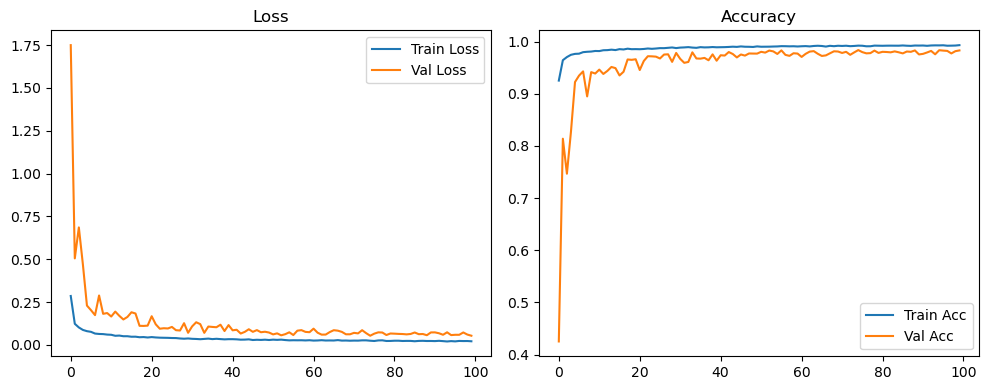

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1551, Acc: 0.9635 | Val Loss: 0.0861, Acc: 0.9734


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9871 | Val Loss: 0.0388, Acc: 0.9882


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.0473, Acc: 0.9852


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9948 | Val Loss: 0.0427, Acc: 0.9873


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0405, Acc: 0.9868


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0380, Acc: 0.9885


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0370, Acc: 0.9898


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0391, Acc: 0.9886


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0455, Acc: 0.9874


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0506, Acc: 0.9865


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0415, Acc: 0.9882


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.0385, Acc: 0.9902


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0491, Acc: 0.9875


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0403, Acc: 0.9902


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0624, Acc: 0.9856


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0439, Acc: 0.9893


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0413, Acc: 0.9907


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0375, Acc: 0.9915


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0372, Acc: 0.9918


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0363, Acc: 0.9922


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9922


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0398, Acc: 0.9909


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9918


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9919


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9916


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9921


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9917


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9918


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9918


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9918


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9922


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0399, Acc: 0.9918


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9920


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9919


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9918


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9919


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0404, Acc: 0.9918


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0416, Acc: 0.9922


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0413, Acc: 0.9922


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9921


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0426, Acc: 0.9920


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9920


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0412, Acc: 0.9923


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9923


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0419, Acc: 0.9921


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0424, Acc: 0.9921


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9920


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9922


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9919


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0430, Acc: 0.9921


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9922


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9922


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9923


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9919


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9922


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9922


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9921


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0438, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9921


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9922


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9922


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9921


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9921


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9918


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9920


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9921


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9919


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1659, Acc: 0.9732


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.0534, Acc: 0.9895


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0499, Acc: 0.9909


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0447, Acc: 0.9922


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9921


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9921


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9919


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9920


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9923


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9922


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9922


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9922


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9927


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0445, Acc: 0.9926


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0440, Acc: 0.9924


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0443, Acc: 0.9928


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9927


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9923


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9928


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0441, Acc: 0.9925


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9925


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9926


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9925


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0459, Acc: 0.9925


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9928


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0450, Acc: 0.9928


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0446, Acc: 0.9928


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0447, Acc: 0.9928


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9930


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0452, Acc: 0.9927


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0453, Acc: 0.9932


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9928


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9929


Final Test Loss: 0.0436 Accuracy: 0.9923


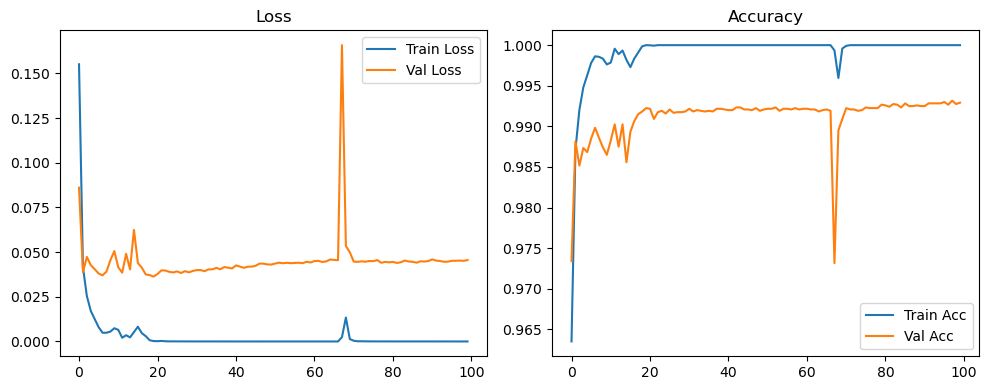

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.1847, Acc: 0.9551 | Val Loss: 0.2697, Acc: 0.9133


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0617, Acc: 0.9810 | Val Loss: 0.0692, Acc: 0.9792


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9853 | Val Loss: 0.0698, Acc: 0.9780


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9877 | Val Loss: 0.0472, Acc: 0.9852


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 0.0482, Acc: 0.9853


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9917 | Val Loss: 0.0410, Acc: 0.9874


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.0418, Acc: 0.9868


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0407, Acc: 0.9889


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0393, Acc: 0.9875


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0579, Acc: 0.9818


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0354, Acc: 0.9891


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0411, Acc: 0.9887


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0458, Acc: 0.9864


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0385, Acc: 0.9893


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0382, Acc: 0.9895


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0426, Acc: 0.9879


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0506, Acc: 0.9862


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0352, Acc: 0.9908


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0518, Acc: 0.9868


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0420, Acc: 0.9894


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0453, Acc: 0.9880


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9965 | Val Loss: 0.0385, Acc: 0.9890


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0347, Acc: 0.9918


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0366, Acc: 0.9901


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0401, Acc: 0.9900


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9969 | Val Loss: 0.0412, Acc: 0.9892


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0407, Acc: 0.9892


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0461, Acc: 0.9888


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0403, Acc: 0.9893


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9973 | Val Loss: 0.0345, Acc: 0.9906


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0419, Acc: 0.9888


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.0449, Acc: 0.9892


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0405, Acc: 0.9890


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0344, Acc: 0.9909


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0467, Acc: 0.9872


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0425, Acc: 0.9887


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0346, Acc: 0.9913


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0462, Acc: 0.9876


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0398, Acc: 0.9911


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0383, Acc: 0.9908


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0378, Acc: 0.9902


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0447, Acc: 0.9885


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0385, Acc: 0.9904


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0373, Acc: 0.9903


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0356, Acc: 0.9905


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0400, Acc: 0.9898


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0373, Acc: 0.9904


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0392, Acc: 0.9908


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0433, Acc: 0.9892


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0394, Acc: 0.9903


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0389, Acc: 0.9903


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0364, Acc: 0.9909


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0375, Acc: 0.9907


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0364, Acc: 0.9905


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0349, Acc: 0.9909


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0373, Acc: 0.9909


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0361, Acc: 0.9915


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0344, Acc: 0.9921


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0388, Acc: 0.9913


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0432, Acc: 0.9908


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0407, Acc: 0.9908


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0391, Acc: 0.9910


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0415, Acc: 0.9908


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0393, Acc: 0.9915


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0388, Acc: 0.9914


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0394, Acc: 0.9914


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0414, Acc: 0.9917


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0400, Acc: 0.9910


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0414, Acc: 0.9909


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0437, Acc: 0.9903


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0429, Acc: 0.9908


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0448, Acc: 0.9888


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0382, Acc: 0.9913


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0489, Acc: 0.9893


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0476, Acc: 0.9899


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0402, Acc: 0.9910


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0374, Acc: 0.9913


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0390, Acc: 0.9911


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0412, Acc: 0.9914


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0445, Acc: 0.9901


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0398, Acc: 0.9914


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0382, Acc: 0.9918


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0378, Acc: 0.9921


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0382, Acc: 0.9921


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0395, Acc: 0.9921


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0399, Acc: 0.9919


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0390, Acc: 0.9920


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0406, Acc: 0.9918


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0395, Acc: 0.9922


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0415, Acc: 0.9915


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0422, Acc: 0.9921


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0416, Acc: 0.9922


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0401, Acc: 0.9922


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0409, Acc: 0.9922


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0415, Acc: 0.9922


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0419, Acc: 0.9917


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0419, Acc: 0.9914


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0416, Acc: 0.9914


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0378, Acc: 0.9922


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0412, Acc: 0.9913


Final Test Loss: 0.0443 Accuracy: 0.9887


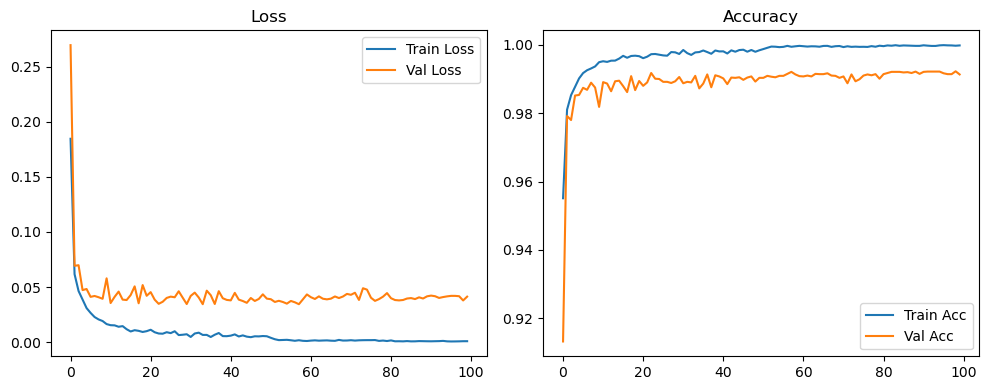

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2861, Acc: 0.9249 | Val Loss: 1.6554, Acc: 0.4570


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1239, Acc: 0.9637 | Val Loss: 0.5431, Acc: 0.7976


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1027, Acc: 0.9701 | Val Loss: 0.6239, Acc: 0.7722


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9752 | Val Loss: 0.6443, Acc: 0.7621


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0810, Acc: 0.9752 | Val Loss: 0.3360, Acc: 0.8803


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0758, Acc: 0.9769 | Val Loss: 0.2426, Acc: 0.9163


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9801 | Val Loss: 0.2136, Acc: 0.9290


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9796 | Val Loss: 0.2291, Acc: 0.9218


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9815 | Val Loss: 0.1298, Acc: 0.9626


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9813 | Val Loss: 0.1401, Acc: 0.9566


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0610, Acc: 0.9818 | Val Loss: 0.1991, Acc: 0.9342


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9831 | Val Loss: 0.1446, Acc: 0.9566


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9832 | Val Loss: 0.1574, Acc: 0.9517


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0530, Acc: 0.9838 | Val Loss: 0.1164, Acc: 0.9651


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9842 | Val Loss: 0.1994, Acc: 0.9353


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9864 | Val Loss: 0.1986, Acc: 0.9347


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 0.1666, Acc: 0.9463


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.1268, Acc: 0.9597


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9862 | Val Loss: 0.1049, Acc: 0.9674


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0456, Acc: 0.9852 | Val Loss: 0.0829, Acc: 0.9767


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9847 | Val Loss: 0.1221, Acc: 0.9639


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.1181, Acc: 0.9633


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9868 | Val Loss: 0.1009, Acc: 0.9697


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9870 | Val Loss: 0.1298, Acc: 0.9591


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.1043, Acc: 0.9668


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9874 | Val Loss: 0.0959, Acc: 0.9700


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9882 | Val Loss: 0.1091, Acc: 0.9669


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9887 | Val Loss: 0.0778, Acc: 0.9770


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9886 | Val Loss: 0.1094, Acc: 0.9687


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9882 | Val Loss: 0.0851, Acc: 0.9732


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9888 | Val Loss: 0.0936, Acc: 0.9705


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9887 | Val Loss: 0.1063, Acc: 0.9665


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9892 | Val Loss: 0.0787, Acc: 0.9770


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0863, Acc: 0.9745


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9895 | Val Loss: 0.0923, Acc: 0.9723


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0792, Acc: 0.9758


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.1003, Acc: 0.9686


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0850, Acc: 0.9738


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0748, Acc: 0.9774


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9889 | Val Loss: 0.0862, Acc: 0.9737


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0834, Acc: 0.9741


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9904 | Val Loss: 0.0875, Acc: 0.9729


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0604, Acc: 0.9825


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0982, Acc: 0.9694


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0664, Acc: 0.9804


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0695, Acc: 0.9796


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0932, Acc: 0.9708


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.0625, Acc: 0.9821


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9897 | Val Loss: 0.0870, Acc: 0.9722


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9899 | Val Loss: 0.0629, Acc: 0.9816


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9915 | Val Loss: 0.0599, Acc: 0.9819


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.0616, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0655, Acc: 0.9815


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0591, Acc: 0.9826


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0589, Acc: 0.9838


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0624, Acc: 0.9805


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0611, Acc: 0.9823


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0676, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0665, Acc: 0.9803


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0625, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9931 | Val Loss: 0.0723, Acc: 0.9784


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0654, Acc: 0.9793


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0517, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0649, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9928 | Val Loss: 0.0584, Acc: 0.9821


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.0603, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.0598, Acc: 0.9811


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0586, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0583, Acc: 0.9816


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0505, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.0553, Acc: 0.9829


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0551, Acc: 0.9836


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0569, Acc: 0.9828


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0587, Acc: 0.9818


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0558, Acc: 0.9838


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0556, Acc: 0.9827


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0560, Acc: 0.9838


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9929 | Val Loss: 0.0495, Acc: 0.9851


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0497, Acc: 0.9853


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0484, Acc: 0.9859


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0450, Acc: 0.9876


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.0454, Acc: 0.9877


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0452, Acc: 0.9879


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0417, Acc: 0.9888


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9939 | Val Loss: 0.0419, Acc: 0.9886


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0466, Acc: 0.9871


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0449, Acc: 0.9872


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0526, Acc: 0.9850


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0484, Acc: 0.9856


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0480, Acc: 0.9861


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9946 | Val Loss: 0.0456, Acc: 0.9864


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0440, Acc: 0.9875


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9945 | Val Loss: 0.0478, Acc: 0.9861


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0485, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0463, Acc: 0.9862


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0499, Acc: 0.9853


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0492, Acc: 0.9847


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0506, Acc: 0.9856


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9942 | Val Loss: 0.0442, Acc: 0.9876


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0445, Acc: 0.9871


Final Test Loss: 0.0439 Accuracy: 0.9851


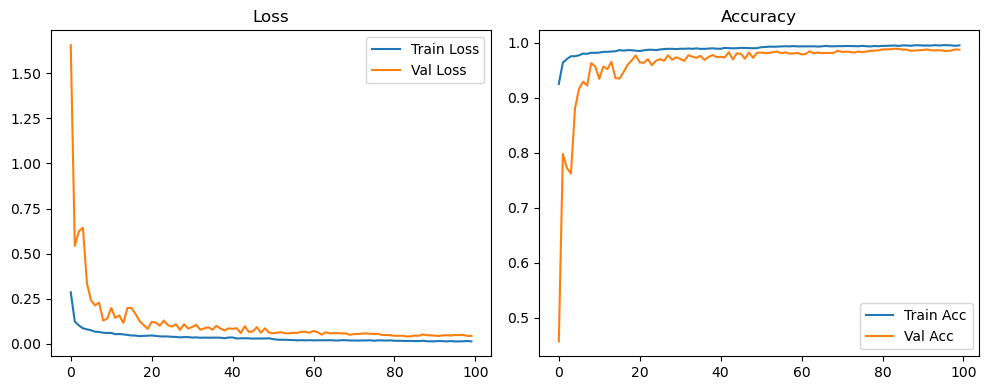

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2087, Acc: 0.9632 | Val Loss: 0.0750, Acc: 0.9791


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9880 | Val Loss: 0.0446, Acc: 0.9876


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9924 | Val Loss: 0.0458, Acc: 0.9861


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9961 | Val Loss: 0.0446, Acc: 0.9867


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9971 | Val Loss: 0.0363, Acc: 0.9885


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9986 | Val Loss: 0.0390, Acc: 0.9878


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9990 | Val Loss: 0.0403, Acc: 0.9883


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9996 | Val Loss: 0.0357, Acc: 0.9905


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0433, Acc: 0.9866


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9991 | Val Loss: 0.0455, Acc: 0.9874


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.0445, Acc: 0.9871


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9997 | Val Loss: 0.0389, Acc: 0.9891


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9898


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0367, Acc: 0.9899


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9909


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9909


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9910


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9909


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9908


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0352, Acc: 0.9908


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9908


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0355, Acc: 0.9911


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9909


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9910


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9911


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0369, Acc: 0.9910


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9912


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9909


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9912


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9908


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9912


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0387, Acc: 0.9910


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9909


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9911


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9910


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9912


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9912


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9908


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9908


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9911


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9912


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9909


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9911


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0496, Acc: 0.9851 | Val Loss: 0.0478, Acc: 0.9857


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0344, Acc: 0.9892


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9993 | Val Loss: 0.0329, Acc: 0.9905


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9999 | Val Loss: 0.0329, Acc: 0.9917


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0319, Acc: 0.9912


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0315, Acc: 0.9916


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0318, Acc: 0.9918


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0327, Acc: 0.9918


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9919


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9916


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0342, Acc: 0.9911


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0335, Acc: 0.9921


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9915


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0354, Acc: 0.9921


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0349, Acc: 0.9922


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9918


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9922


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0368, Acc: 0.9921


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9924


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0367, Acc: 0.9923


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9920


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0381, Acc: 0.9919


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0379, Acc: 0.9920


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0394, Acc: 0.9918


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9918


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9920


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0401, Acc: 0.9918


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9919


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9919


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0410, Acc: 0.9919


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0418, Acc: 0.9919


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9920


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9917


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9917


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0420, Acc: 0.9920


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9918


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0431, Acc: 0.9923


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0434, Acc: 0.9922


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0436, Acc: 0.9923


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9922


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0456, Acc: 0.9918


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9918


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0454, Acc: 0.9918


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9919


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0471, Acc: 0.9918


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0470, Acc: 0.9919


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0488, Acc: 0.9916


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0478, Acc: 0.9919


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0485, Acc: 0.9922


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9922


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0489, Acc: 0.9918


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0495, Acc: 0.9922


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0497, Acc: 0.9921


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0505, Acc: 0.9925


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0491, Acc: 0.9918


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9919 | Val Loss: 0.0537, Acc: 0.9864


Final Test Loss: 0.0485 Accuracy: 0.9867


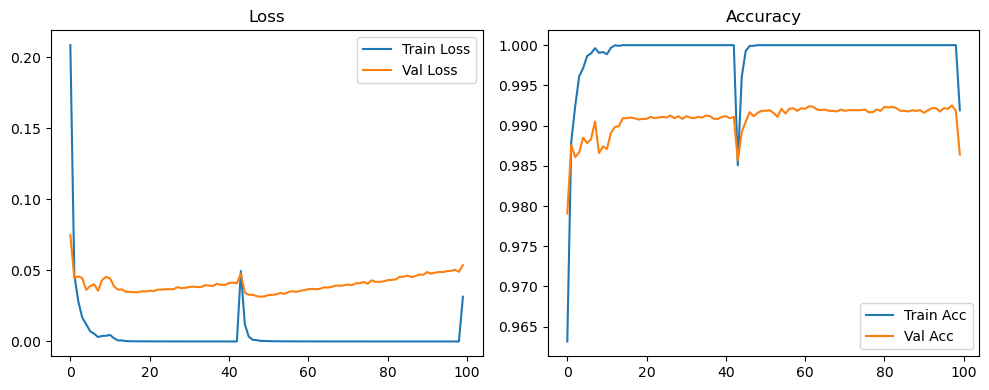

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2436, Acc: 0.9551 | Val Loss: 0.2336, Acc: 0.9329


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9820 | Val Loss: 0.0860, Acc: 0.9770


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9858 | Val Loss: 0.0859, Acc: 0.9749


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0387, Acc: 0.9884 | Val Loss: 0.0590, Acc: 0.9829


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9906 | Val Loss: 0.0608, Acc: 0.9812


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9920 | Val Loss: 0.0562, Acc: 0.9828


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0460, Acc: 0.9858


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.0523, Acc: 0.9846


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9944 | Val Loss: 0.0432, Acc: 0.9872


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.0538, Acc: 0.9841


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0436, Acc: 0.9875


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0428, Acc: 0.9878


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0412, Acc: 0.9880


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0405, Acc: 0.9875


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0413, Acc: 0.9884


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0443, Acc: 0.9872


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0445, Acc: 0.9870


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0392, Acc: 0.9883


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0468, Acc: 0.9861


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0434, Acc: 0.9877


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.0405, Acc: 0.9882


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0425, Acc: 0.9886


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0465, Acc: 0.9865


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0471, Acc: 0.9869


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0556, Acc: 0.9844


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0381, Acc: 0.9894


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0366, Acc: 0.9896


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0412, Acc: 0.9885


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0415, Acc: 0.9891


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0397, Acc: 0.9889


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0350, Acc: 0.9902


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0432, Acc: 0.9889


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0381, Acc: 0.9901


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0470, Acc: 0.9874


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0387, Acc: 0.9908


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0446, Acc: 0.9884


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0364, Acc: 0.9900


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0468, Acc: 0.9883


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0387, Acc: 0.9905


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0414, Acc: 0.9895


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0455, Acc: 0.9889


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0419, Acc: 0.9899


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0355, Acc: 0.9908


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0401, Acc: 0.9905


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0486, Acc: 0.9884


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0367, Acc: 0.9916


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0455, Acc: 0.9895


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0352, Acc: 0.9912


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0378, Acc: 0.9902


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0394, Acc: 0.9906


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0380, Acc: 0.9902


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0439, Acc: 0.9888


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0421, Acc: 0.9905


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0383, Acc: 0.9908


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0421, Acc: 0.9902


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0419, Acc: 0.9904


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0437, Acc: 0.9909


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0388, Acc: 0.9917


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0404, Acc: 0.9903


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0392, Acc: 0.9908


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0438, Acc: 0.9907


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0362, Acc: 0.9921


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0358, Acc: 0.9922


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0392, Acc: 0.9911


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0380, Acc: 0.9909


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.0438, Acc: 0.9904


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0350, Acc: 0.9918


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0402, Acc: 0.9902


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0450, Acc: 0.9898


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0411, Acc: 0.9902


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0415, Acc: 0.9900


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0372, Acc: 0.9913


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0432, Acc: 0.9897


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0444, Acc: 0.9895


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0424, Acc: 0.9903


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0392, Acc: 0.9904


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0411, Acc: 0.9904


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0381, Acc: 0.9914


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0431, Acc: 0.9905


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0388, Acc: 0.9903


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0427, Acc: 0.9898


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0420, Acc: 0.9915


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0420, Acc: 0.9902


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0387, Acc: 0.9901


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0447, Acc: 0.9905


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0440, Acc: 0.9896


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0473, Acc: 0.9906


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0437, Acc: 0.9907


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0414, Acc: 0.9905


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0446, Acc: 0.9894


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0466, Acc: 0.9901


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0426, Acc: 0.9904


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0434, Acc: 0.9908


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0402, Acc: 0.9918


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0417, Acc: 0.9907


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0452, Acc: 0.9900


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0420, Acc: 0.9908


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0434, Acc: 0.9908


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0381, Acc: 0.9906


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0435, Acc: 0.9910


Final Test Loss: 0.0361 Accuracy: 0.9894


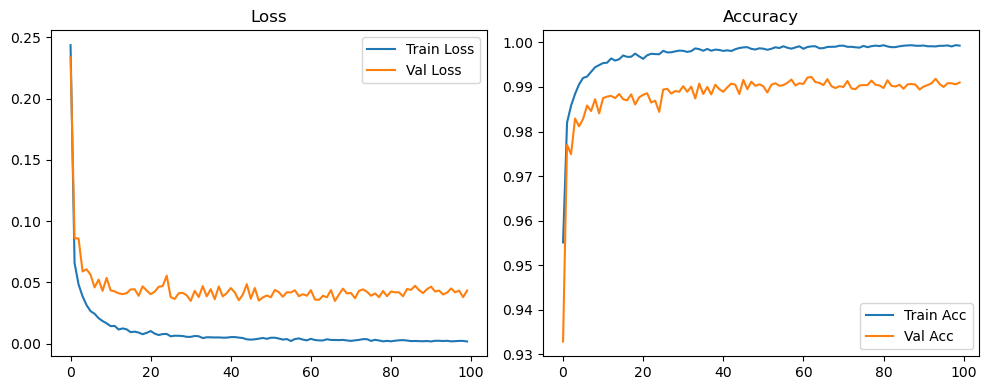

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3655, Acc: 0.9209 | Val Loss: 1.5506, Acc: 0.4183


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1362, Acc: 0.9622 | Val Loss: 0.7519, Acc: 0.7191


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1101, Acc: 0.9691 | Val Loss: 0.6271, Acc: 0.7661


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0940, Acc: 0.9734 | Val Loss: 0.4183, Acc: 0.8442


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0864, Acc: 0.9746 | Val Loss: 0.2378, Acc: 0.9233


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9758 | Val Loss: 0.2690, Acc: 0.9061


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0701, Acc: 0.9798 | Val Loss: 0.2196, Acc: 0.9257


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0679, Acc: 0.9800 | Val Loss: 0.2275, Acc: 0.9233


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0625, Acc: 0.9812 | Val Loss: 0.1411, Acc: 0.9578


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0627, Acc: 0.9813 | Val Loss: 0.1593, Acc: 0.9497


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0609, Acc: 0.9818 | Val Loss: 0.1305, Acc: 0.9605


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0547, Acc: 0.9833 | Val Loss: 0.1271, Acc: 0.9624


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0555, Acc: 0.9835 | Val Loss: 0.1427, Acc: 0.9562


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0529, Acc: 0.9842 | Val Loss: 0.1704, Acc: 0.9454


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9843 | Val Loss: 0.1391, Acc: 0.9560


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0488, Acc: 0.9851 | Val Loss: 0.1997, Acc: 0.9352


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0477, Acc: 0.9858 | Val Loss: 0.0848, Acc: 0.9748


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9858 | Val Loss: 0.1048, Acc: 0.9679


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9862 | Val Loss: 0.0861, Acc: 0.9742


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0749, Acc: 0.9786


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9853 | Val Loss: 0.0914, Acc: 0.9730


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9872 | Val Loss: 0.1128, Acc: 0.9635


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9876 | Val Loss: 0.0848, Acc: 0.9749


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9875 | Val Loss: 0.0844, Acc: 0.9738


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9876 | Val Loss: 0.0753, Acc: 0.9773


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9873 | Val Loss: 0.0909, Acc: 0.9725


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9875 | Val Loss: 0.0761, Acc: 0.9774


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0765, Acc: 0.9782


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9885 | Val Loss: 0.0887, Acc: 0.9734


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9889 | Val Loss: 0.0635, Acc: 0.9821


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9891 | Val Loss: 0.0662, Acc: 0.9812


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.0801, Acc: 0.9766


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9890 | Val Loss: 0.0737, Acc: 0.9772


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0577, Acc: 0.9837


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0623, Acc: 0.9827


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9891 | Val Loss: 0.0577, Acc: 0.9832


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9888 | Val Loss: 0.0697, Acc: 0.9803


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0338, Acc: 0.9892 | Val Loss: 0.0676, Acc: 0.9799


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9899 | Val Loss: 0.0660, Acc: 0.9809


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9899 | Val Loss: 0.0574, Acc: 0.9834


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0603, Acc: 0.9825


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9902 | Val Loss: 0.0603, Acc: 0.9822


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9902 | Val Loss: 0.0586, Acc: 0.9838


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0525, Acc: 0.9852


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9903 | Val Loss: 0.0567, Acc: 0.9839


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9911 | Val Loss: 0.0533, Acc: 0.9856


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9897 | Val Loss: 0.0643, Acc: 0.9810


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9906 | Val Loss: 0.0543, Acc: 0.9850


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0629, Acc: 0.9824


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9914 | Val Loss: 0.0652, Acc: 0.9800


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9907 | Val Loss: 0.0603, Acc: 0.9828


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9911 | Val Loss: 0.0470, Acc: 0.9865


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9908 | Val Loss: 0.0517, Acc: 0.9858


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.0542, Acc: 0.9847


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9912 | Val Loss: 0.0574, Acc: 0.9839


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0591, Acc: 0.9835


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9922 | Val Loss: 0.0669, Acc: 0.9805


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9919 | Val Loss: 0.0503, Acc: 0.9852


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0608, Acc: 0.9816


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.0622, Acc: 0.9810


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0607, Acc: 0.9820


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0549, Acc: 0.9840


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0418, Acc: 0.9883


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.0455, Acc: 0.9865


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0614, Acc: 0.9822


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0602, Acc: 0.9819


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0599, Acc: 0.9828


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0576, Acc: 0.9830


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.0519, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.0468, Acc: 0.9875


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0635, Acc: 0.9805


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0600, Acc: 0.9828


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.0501, Acc: 0.9859


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9916 | Val Loss: 0.0522, Acc: 0.9853


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0531, Acc: 0.9847


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9926 | Val Loss: 0.0504, Acc: 0.9860


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9925 | Val Loss: 0.0601, Acc: 0.9826


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.0504, Acc: 0.9858


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9924 | Val Loss: 0.0524, Acc: 0.9849


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9922 | Val Loss: 0.0481, Acc: 0.9867


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9919 | Val Loss: 0.0517, Acc: 0.9858


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.0503, Acc: 0.9859


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9932 | Val Loss: 0.0493, Acc: 0.9863


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0540, Acc: 0.9842


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.0500, Acc: 0.9855


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0473, Acc: 0.9857


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0492, Acc: 0.9854


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0522, Acc: 0.9858


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9922 | Val Loss: 0.0513, Acc: 0.9844


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0498, Acc: 0.9864


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0480, Acc: 0.9871


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9936 | Val Loss: 0.0451, Acc: 0.9880


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0488, Acc: 0.9875


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0537, Acc: 0.9843


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0493, Acc: 0.9872


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0535, Acc: 0.9849


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0475, Acc: 0.9878


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.0479, Acc: 0.9877


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.0490, Acc: 0.9872


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0509, Acc: 0.9870


Final Test Loss: 0.0456 Accuracy: 0.9859


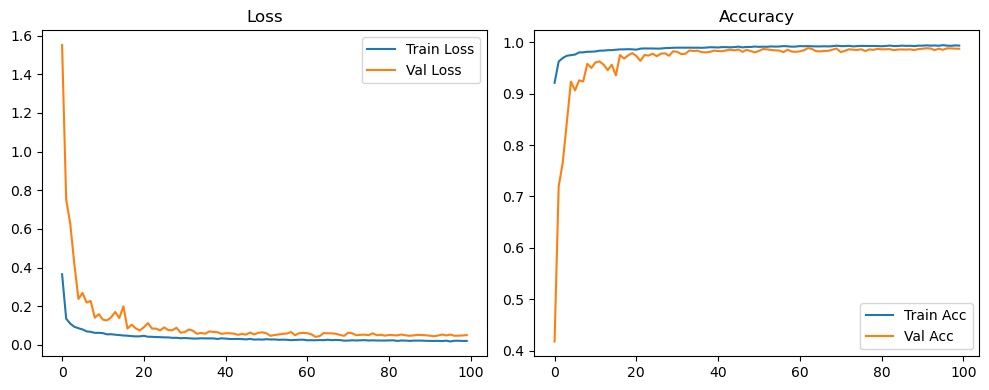

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2895, Acc: 0.9602 | Val Loss: 0.0865, Acc: 0.9833


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0600, Acc: 0.9877 | Val Loss: 0.0567, Acc: 0.9863


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9920 | Val Loss: 0.0517, Acc: 0.9853


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9958 | Val Loss: 0.0447, Acc: 0.9869


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9971 | Val Loss: 0.0530, Acc: 0.9842


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9984 | Val Loss: 0.0348, Acc: 0.9897


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9994 | Val Loss: 0.0339, Acc: 0.9897


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9997 | Val Loss: 0.0319, Acc: 0.9905


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 1.0000 | Val Loss: 0.0326, Acc: 0.9899


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9999 | Val Loss: 0.0322, Acc: 0.9894


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9998 | Val Loss: 0.0389, Acc: 0.9883


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9991 | Val Loss: 0.0598, Acc: 0.9825


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.0479, Acc: 0.9858


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9989 | Val Loss: 0.0435, Acc: 0.9878


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9999 | Val Loss: 0.0355, Acc: 0.9912


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0330, Acc: 0.9915


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0328, Acc: 0.9913


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0333, Acc: 0.9912


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0334, Acc: 0.9913


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0340, Acc: 0.9914


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9912


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0347, Acc: 0.9909


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9911


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0353, Acc: 0.9912


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9915


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0362, Acc: 0.9911


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9915


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0372, Acc: 0.9912


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9913


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9912


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9915


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0375, Acc: 0.9912


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0378, Acc: 0.9910


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0376, Acc: 0.9913


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0383, Acc: 0.9910


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9913


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0386, Acc: 0.9909


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9915


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9914


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0389, Acc: 0.9912


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9912


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0405, Acc: 0.9909


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0397, Acc: 0.9914


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9884 | Val Loss: 0.0421, Acc: 0.9868


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0359, Acc: 0.9895


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9997 | Val Loss: 0.0361, Acc: 0.9908


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0352, Acc: 0.9910


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 1.0000 | Val Loss: 0.0345, Acc: 0.9910


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0348, Acc: 0.9912


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0350, Acc: 0.9916


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0357, Acc: 0.9908


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0358, Acc: 0.9913


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0361, Acc: 0.9915


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0365, Acc: 0.9912


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0370, Acc: 0.9909


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0373, Acc: 0.9911


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0382, Acc: 0.9915


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0380, Acc: 0.9912


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0385, Acc: 0.9915


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9913


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9916


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0395, Acc: 0.9915


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0396, Acc: 0.9919


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9916


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0409, Acc: 0.9915


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0411, Acc: 0.9918


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0415, Acc: 0.9917


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0423, Acc: 0.9915


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0422, Acc: 0.9913


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0428, Acc: 0.9915


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9915


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0427, Acc: 0.9917


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0442, Acc: 0.9918


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0444, Acc: 0.9912


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0455, Acc: 0.9917


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0448, Acc: 0.9912


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0464, Acc: 0.9917


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0451, Acc: 0.9913


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0449, Acc: 0.9917


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0460, Acc: 0.9912


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0463, Acc: 0.9917


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0465, Acc: 0.9917


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0467, Acc: 0.9917


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0473, Acc: 0.9913


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0481, Acc: 0.9912


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0480, Acc: 0.9914


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 1.0194, Acc: 0.8330


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9912 | Val Loss: 0.0478, Acc: 0.9870


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0410, Acc: 0.9898


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 1.0000 | Val Loss: 0.0406, Acc: 0.9902


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0393, Acc: 0.9910


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0391, Acc: 0.9911


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0392, Acc: 0.9911


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9912


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0390, Acc: 0.9914


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0400, Acc: 0.9916


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0398, Acc: 0.9912


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9916


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0407, Acc: 0.9913


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0414, Acc: 0.9911


Final Test Loss: 0.0367 Accuracy: 0.9911


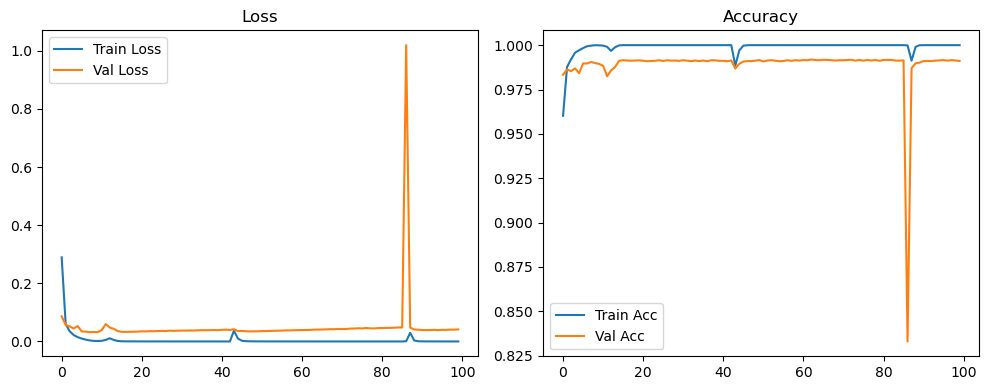

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3360, Acc: 0.9497 | Val Loss: 0.2666, Acc: 0.9414


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0823, Acc: 0.9820 | Val Loss: 0.1180, Acc: 0.9734


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0569, Acc: 0.9849 | Val Loss: 0.1085, Acc: 0.9718


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9881 | Val Loss: 0.0876, Acc: 0.9764


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0352, Acc: 0.9907 | Val Loss: 0.0794, Acc: 0.9780


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9913 | Val Loss: 0.0685, Acc: 0.9812


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9926 | Val Loss: 0.0585, Acc: 0.9826


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9933 | Val Loss: 0.0594, Acc: 0.9820


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9938 | Val Loss: 0.0503, Acc: 0.9852


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9945 | Val Loss: 0.0528, Acc: 0.9839


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9950 | Val Loss: 0.0550, Acc: 0.9837


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.0475, Acc: 0.9863


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.0502, Acc: 0.9851


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0457, Acc: 0.9861


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0468, Acc: 0.9868


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0448, Acc: 0.9868


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9968 | Val Loss: 0.0432, Acc: 0.9873


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0456, Acc: 0.9865


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0484, Acc: 0.9859


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0414, Acc: 0.9886


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0455, Acc: 0.9870


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0497, Acc: 0.9857


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0545, Acc: 0.9840


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0444, Acc: 0.9864


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.0409, Acc: 0.9881


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0416, Acc: 0.9882


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0397, Acc: 0.9893


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0485, Acc: 0.9869


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0455, Acc: 0.9870


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0393, Acc: 0.9888


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0374, Acc: 0.9905


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0425, Acc: 0.9870


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0390, Acc: 0.9892


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0387, Acc: 0.9887


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0379, Acc: 0.9896


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0443, Acc: 0.9874


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0364, Acc: 0.9898


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0482, Acc: 0.9875


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0401, Acc: 0.9895


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0401, Acc: 0.9882


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0357, Acc: 0.9906


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0420, Acc: 0.9894


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0411, Acc: 0.9893


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0372, Acc: 0.9907


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0414, Acc: 0.9891


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0371, Acc: 0.9902


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0409, Acc: 0.9894


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0407, Acc: 0.9901


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0398, Acc: 0.9900


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0410, Acc: 0.9884


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0381, Acc: 0.9899


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0358, Acc: 0.9907


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0410, Acc: 0.9893


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0431, Acc: 0.9890


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0412, Acc: 0.9900


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0425, Acc: 0.9891


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0357, Acc: 0.9906


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0396, Acc: 0.9898


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0429, Acc: 0.9892


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0402, Acc: 0.9898


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0407, Acc: 0.9901


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0402, Acc: 0.9907


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0379, Acc: 0.9909


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0392, Acc: 0.9904


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0380, Acc: 0.9911


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0421, Acc: 0.9892


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0415, Acc: 0.9908


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0434, Acc: 0.9899


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0433, Acc: 0.9891


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0400, Acc: 0.9902


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0407, Acc: 0.9898


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0433, Acc: 0.9897


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0483, Acc: 0.9893


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0422, Acc: 0.9900


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0455, Acc: 0.9892


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0431, Acc: 0.9904


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0466, Acc: 0.9899


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0414, Acc: 0.9908


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0393, Acc: 0.9905


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0412, Acc: 0.9907


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0392, Acc: 0.9909


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0422, Acc: 0.9902


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0377, Acc: 0.9908


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0427, Acc: 0.9900


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0419, Acc: 0.9902


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0418, Acc: 0.9905


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.0445, Acc: 0.9895


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0445, Acc: 0.9898


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0364, Acc: 0.9909


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0433, Acc: 0.9905


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0428, Acc: 0.9892


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0427, Acc: 0.9904


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0447, Acc: 0.9894


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0436, Acc: 0.9899


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0437, Acc: 0.9900


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0436, Acc: 0.9903


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.0431, Acc: 0.9905


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0370, Acc: 0.9917


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0383, Acc: 0.9917


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0381, Acc: 0.9912


Final Test Loss: 0.0335 Accuracy: 0.9907


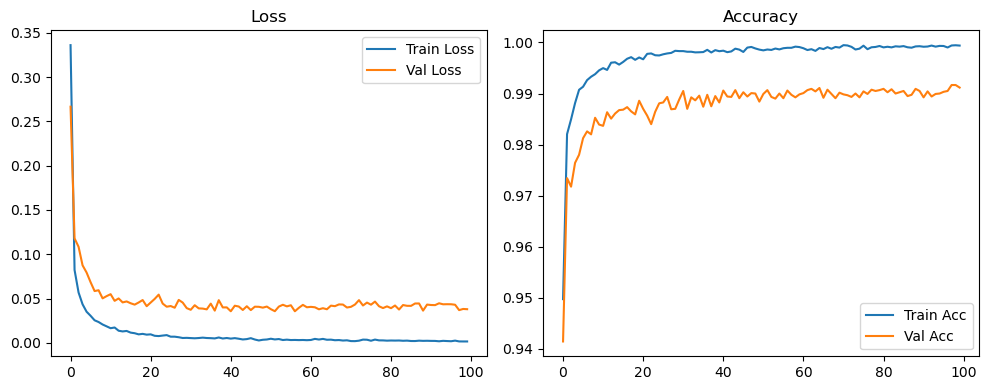

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4904, Acc: 0.9074 | Val Loss: 1.6897, Acc: 0.2992


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1659, Acc: 0.9615 | Val Loss: 0.9307, Acc: 0.6428


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1253, Acc: 0.9677 | Val Loss: 0.8201, Acc: 0.6762


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1052, Acc: 0.9719 | Val Loss: 0.5722, Acc: 0.7724


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0955, Acc: 0.9735 | Val Loss: 0.4040, Acc: 0.8523


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0892, Acc: 0.9740 | Val Loss: 0.4389, Acc: 0.8349


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0781, Acc: 0.9775 | Val Loss: 0.3394, Acc: 0.8785


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0760, Acc: 0.9783 | Val Loss: 0.3599, Acc: 0.8712


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0701, Acc: 0.9799 | Val Loss: 0.1743, Acc: 0.9479


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9803 | Val Loss: 0.2404, Acc: 0.9235


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0658, Acc: 0.9804 | Val Loss: 0.1788, Acc: 0.9449


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9818 | Val Loss: 0.1539, Acc: 0.9547


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0590, Acc: 0.9829 | Val Loss: 0.1522, Acc: 0.9552


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0587, Acc: 0.9829 | Val Loss: 0.2014, Acc: 0.9343


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9834 | Val Loss: 0.1883, Acc: 0.9367


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0542, Acc: 0.9837 | Val Loss: 0.1918, Acc: 0.9390


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9841 | Val Loss: 0.1420, Acc: 0.9563


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9843 | Val Loss: 0.1241, Acc: 0.9614


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9848 | Val Loss: 0.1305, Acc: 0.9583


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9858 | Val Loss: 0.1023, Acc: 0.9705


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0497, Acc: 0.9847 | Val Loss: 0.1141, Acc: 0.9670


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9857 | Val Loss: 0.1302, Acc: 0.9602


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9866 | Val Loss: 0.1070, Acc: 0.9689


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0437, Acc: 0.9866 | Val Loss: 0.1011, Acc: 0.9700


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9873 | Val Loss: 0.0912, Acc: 0.9736


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9868 | Val Loss: 0.1029, Acc: 0.9676


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0968, Acc: 0.9702


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0404, Acc: 0.9879 | Val Loss: 0.0990, Acc: 0.9718


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9878 | Val Loss: 0.1342, Acc: 0.9591


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9882 | Val Loss: 0.0841, Acc: 0.9755


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0932, Acc: 0.9722


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9885 | Val Loss: 0.0897, Acc: 0.9739


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9891 | Val Loss: 0.0879, Acc: 0.9738


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9886 | Val Loss: 0.0827, Acc: 0.9765


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.0791, Acc: 0.9778


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9896 | Val Loss: 0.0826, Acc: 0.9763


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0348, Acc: 0.9895 | Val Loss: 0.0532, Acc: 0.9864


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0351, Acc: 0.9889 | Val Loss: 0.0819, Acc: 0.9768


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9897 | Val Loss: 0.0722, Acc: 0.9790


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0670, Acc: 0.9808


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9897 | Val Loss: 0.0728, Acc: 0.9792


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.0745, Acc: 0.9780


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9893 | Val Loss: 0.0640, Acc: 0.9840


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9902 | Val Loss: 0.0647, Acc: 0.9818


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9900 | Val Loss: 0.0641, Acc: 0.9817


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9911 | Val Loss: 0.0706, Acc: 0.9786


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9896 | Val Loss: 0.0825, Acc: 0.9748


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.0665, Acc: 0.9807


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0746, Acc: 0.9777


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9906 | Val Loss: 0.0825, Acc: 0.9752


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.0702, Acc: 0.9786


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9910 | Val Loss: 0.0769, Acc: 0.9756


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.0765, Acc: 0.9765


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.0664, Acc: 0.9799


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9907 | Val Loss: 0.0757, Acc: 0.9762


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9903 | Val Loss: 0.0663, Acc: 0.9812


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.0695, Acc: 0.9788


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0686, Acc: 0.9788


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9911 | Val Loss: 0.0701, Acc: 0.9788


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9909 | Val Loss: 0.0632, Acc: 0.9810


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0727, Acc: 0.9784


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0713, Acc: 0.9781


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0592, Acc: 0.9825


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.0617, Acc: 0.9828


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0613, Acc: 0.9832


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0769, Acc: 0.9765


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9909 | Val Loss: 0.0859, Acc: 0.9730


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9916 | Val Loss: 0.0741, Acc: 0.9765


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.0644, Acc: 0.9803


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0576, Acc: 0.9828


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.0634, Acc: 0.9817


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0622, Acc: 0.9803


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9918 | Val Loss: 0.0575, Acc: 0.9833


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0630, Acc: 0.9822


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9929 | Val Loss: 0.0620, Acc: 0.9812


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0621, Acc: 0.9811


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9920 | Val Loss: 0.0534, Acc: 0.9847


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0523, Acc: 0.9847


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0595, Acc: 0.9819


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0644, Acc: 0.9799


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9925 | Val Loss: 0.0573, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0598, Acc: 0.9824


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.0605, Acc: 0.9820


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.0589, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9931 | Val Loss: 0.0577, Acc: 0.9825


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9932 | Val Loss: 0.0578, Acc: 0.9830


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.0535, Acc: 0.9849


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0633, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0230, Acc: 0.9925 | Val Loss: 0.0536, Acc: 0.9849


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0568, Acc: 0.9839


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.0521, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0573, Acc: 0.9837


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0605, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9928 | Val Loss: 0.0620, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9932 | Val Loss: 0.0571, Acc: 0.9825


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0605, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0519, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0595, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0522, Acc: 0.9848


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0473, Acc: 0.9872


Final Test Loss: 0.0451 Accuracy: 0.9864


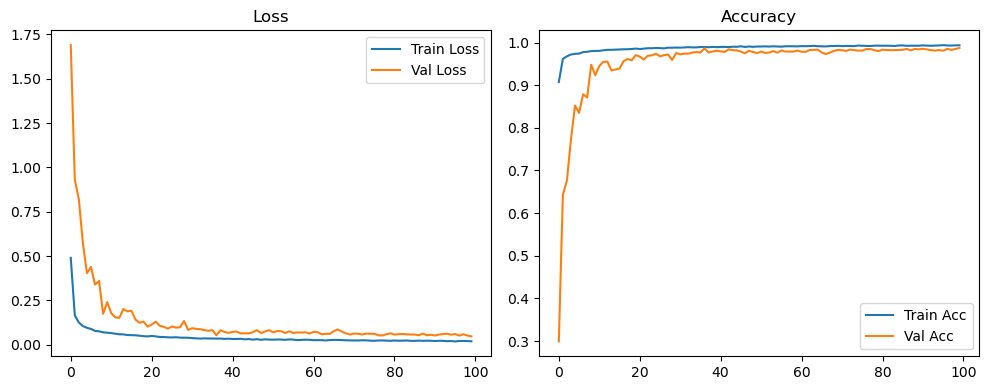

🏆 Best Config: batch64_lr0.01_0.002_0.001_dp0.0 Accuracy: 0.9926


In [8]:
root_path = "TCV_8bit_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)